In [679]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as ptchs
from matplotlib import gridspec
import matplotlib.text as mtext
import scipy.integrate
import scipy.optimize

class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, r'\textbf{' + orig_handle + '}', usetex=True, **self.text_props)
        handlebox.add_artist(title)
        return title

In [655]:
class MinorSymLogLocator(ticker.Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))

import ROOT
ROOT.gROOT.ProcessLine( "gErrorIgnoreLevel = kError;");
ROOT.gStyle.SetCanvasDefW(2400);
ROOT.gStyle.SetCanvasDefH(900);
ROOT.gStyle.SetLegendTextSize(0.05)
ROOT.gStyle.SetLabelSize(0.05)
ROOT.gStyle.SetMarkerSize(1)
ROOT.gStyle.SetMarkerStyle(8)
ROOT.gStyle.SetLineWidth(2)
ROOT.gStyle.SetTextFont(42)
ROOT.gStyle.SetTextSize(0.05)
ROOT.gStyle.SetTickLength(0.02, "y")
ROOT.gStyle.SetHatchesSpacing(1) #to define the spacing between hatches.
ROOT.gStyle.SetHatchesLineWidth(1) #to define the hatches line width.
plt.rcParams.update({
    'axes.labelsize': 15
})

def get_symlog_bins(max_val, base):
    max_exp = np.ceil(np.log(max_val)/np.log(base))
    a = np.append(0, np.power(base, np.arange(max_exp+1)))
    
    s = 3       # number of intervals between two numbers
    l = (a.size - 1) * s + 1          # total length after interpolation
    return np.interp(np.arange(l), np.arange(l, step=s), a)        # interpolate

In [143]:
def convert_to_type(df, col, type):
    df[col] =  df[col].apply(lambda s: type(s))

In [144]:
def normalize_df(df, cols, norm):
    for col in cols:
        df[col] = df[col].div(df[norm])

In [145]:
def map_distr_name(distr):
    s = distr.split("-")
    n = distr
    if "constant" in distr:
        n = f"{s[0]}({s[1]})"
    elif "normal" in distr:
        n = f"{s[0]}({s[1]}, {s[2]})"
    return n.title()

In [146]:
def human_readable(val):
    if int(val/1e9) > 0:
        return f"{int(val/1e9)}B"
    elif int(val/1e6) > 0:
        return f"{int(val/1e6)}M"
    elif int(val/1e3) > 0:
        return f"{int(val/1e3)}K"
    else:
        return str(int(val))
        
def convert_unit(x):
    """
    Get factor to convert to seconds
    """
    if x == "s":
        return 1
    elif x == "ms":
        return 1e3
    elif x == "us":
        return 1e6
    elif x == "ns":
        return 1e9

def unit_to_unit_factor(u1, u2):
    f1 = convert_unit(u1)
    f2 = convert_unit(u2)
    return f2/f1

In [147]:
def mae(pred, observ):
    return np.sum(np.abs(pred-observ))/len(pred)

def r2(pred, observ):
    return 1- (np.sum(np.power(pred-observ, 2)) / np.sum(np.power(observ - np.mean(observ), 2)))

# Benchmarks
Plot benchmark results from running histond_benchmark.C with timers within TH1

## No Bulk API

### Fixed Bins

In [148]:
filename = "nonbulk_1d_fixedbins.csv" 
df_bm = pd.read_csv(filename)
df_bm["nvals"] =  df_bm["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
df_bm["distribution"] =  df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_type(df_bm, "tfindbin", np.float64)
convert_to_type(df_bm, "tfill", np.float64)
convert_to_type(df_bm, "tstats", np.float64)
del df_bm["input"]
df_bm.head(7)

,iter,env,nbins,bulksize,tfindbin,tfill,tstats,nvals,distribution
0,0,CPU,1,1,1.937491,1.620788,1.555348,1.000000e+08,uniform
1,0,CPU,1,1,9.478474,7.850704,7.620397,5.000000e+08,uniform
2,0,CPU,1,1,19.088344,15.712114,15.305721,1.000000e+09,uniform
3,0,CPU,1,1,94.319963,87.005841,75.569822,5.000000e+09,uniform
4,0,CPU,2,1,1.883125,1.552552,1.507859,1.000000e+08,uniform
5,0,CPU,2,1,9.347063,7.682685,7.485839,5.000000e+08,uniform
6,0,CPU,2,1,18.750533,15.447757,15.021956,1.000000e+09,uniform


In [149]:
gp_bm = df_bm.groupby(["env", "distribution", "nvals", "nbins", "bulksize"])
gp_bm.mean()

iter   tfindbin      tfill  \
env distribution nvals        nbins bulksize                               
CPU uniform      1.000000e+08 1     1          1.0   1.875294   1.551172   
                              2     1          1.0   1.862105   1.540116   
                              5     1          1.0   1.876629   1.579942   
                              10    1          1.0   1.867486   1.538372   
                              20    1          1.0   1.861202   1.534309   
                              50    1          1.0   1.826746   1.556542   
                              100   1          1.0   1.822405   1.498089   
                              500   1          1.0   1.827565   1.562940   
                              1000  1          1.0   1.850249   1.542947   
                 5.000000e+08 1     1          1.0   9.333347   7.917787   
                              2     1          1.0   9.248723   7.584963   
                              5     1          1.0   9.256350   7.631018   
                              10    1          1.0   9.256568   7.609552   
                              20    1          1.0   9.342807   7.892647   
                              50    1          1.0   9.261069   8.100508   
                              100   1          1.0   9.203016   7.481004   
                              500   1          1.0   9.147344   7.538352   
                              1000  1          1.0   9.227314   8.092365   
                 1.000000e+09 1     1          1.0  18.951855  15.468729   
                              2     1          1.0  18.545456  15.268573   
                              5     1          1.0  18.611900  15.309308   
                              10    1          1.0  18.657480  15.357767   
                              20    1          1.0  18.797937  15.647771   
                              50    1          1.0  18.441803  16.397713   
                              100   1          1.0  18.210651  15.044283   
                              500   1          1.0  18.319942  15.118158   
                              1000  1          1.0  18.474962  15.552236   
                 5.000000e+09 1     1          1.0  92.750470  86.291794   
                              2     1          1.0  92.807932  79.815401   
                              5     1          1.0  93.170286  77.519193   
                              10    1          1.0  95.189293  76.317781   
                              20    1          1.0  92.653465  76.921896   
                              50    1          1.0  91.370868  75.648633   
                              100   1          1.0  91.926550  77.635879   
                              500   1          1.0  91.307255  75.821473   
                              1000  1          1.0  91.581583  77.306689   

                                                 tstats  
env distribution nvals        nbins bulksize             
CPU uniform      1.000000e+08 1     1          1.503002  
                              2     1          1.492257  
                              5     1          1.496295  
                              10    1          1.496536  
                              20    1          1.490506  
                              50    1          1.463339  
                              100   1          1.458444  
                              500   1          1.464790  
                              1000  1          1.513280  
                 5.000000e+08 1     1          7.487946  
                              2     1          7.378729  
                              5     1          7.412561  
                              10    1          7.409907  
                              20    1          7.414596  
                              50    1          7.324639  
                              100   1          7.267518  
                              500   1          7.319509  
                              1000  1          7.520136

In [150]:
unique_nbins = df_bm["nbins"].unique().astype(np.float64)
unique_nvals = df_bm["nvals"].unique().astype(np.float64)
unique_bulksize = df_bm["bulksize"].unique().astype(np.float64)
unique_edges = [True, False]
unique_nbins, unique_nvals, unique_bulksize

(array([   1.,    2.,    5.,   10.,   20.,   50.,  100.,  500., 1000.]),
 array([1.e+08, 5.e+08, 1.e+09, 5.e+09]),
 array([1.]))

Plots the total time spent on finding bins, filling bins, and updating stats for **1D** histograms with **fixed bins**, **different** number of bins and **different** number of **doubles**. Total time averaged over **3 runs**

In [151]:
selected_env = "CPU"
selected_bulksize = 1
selected_bins = unique_nbins
selected_nvals = 500000000
selected_distr = "uniform"
selected_edges = True

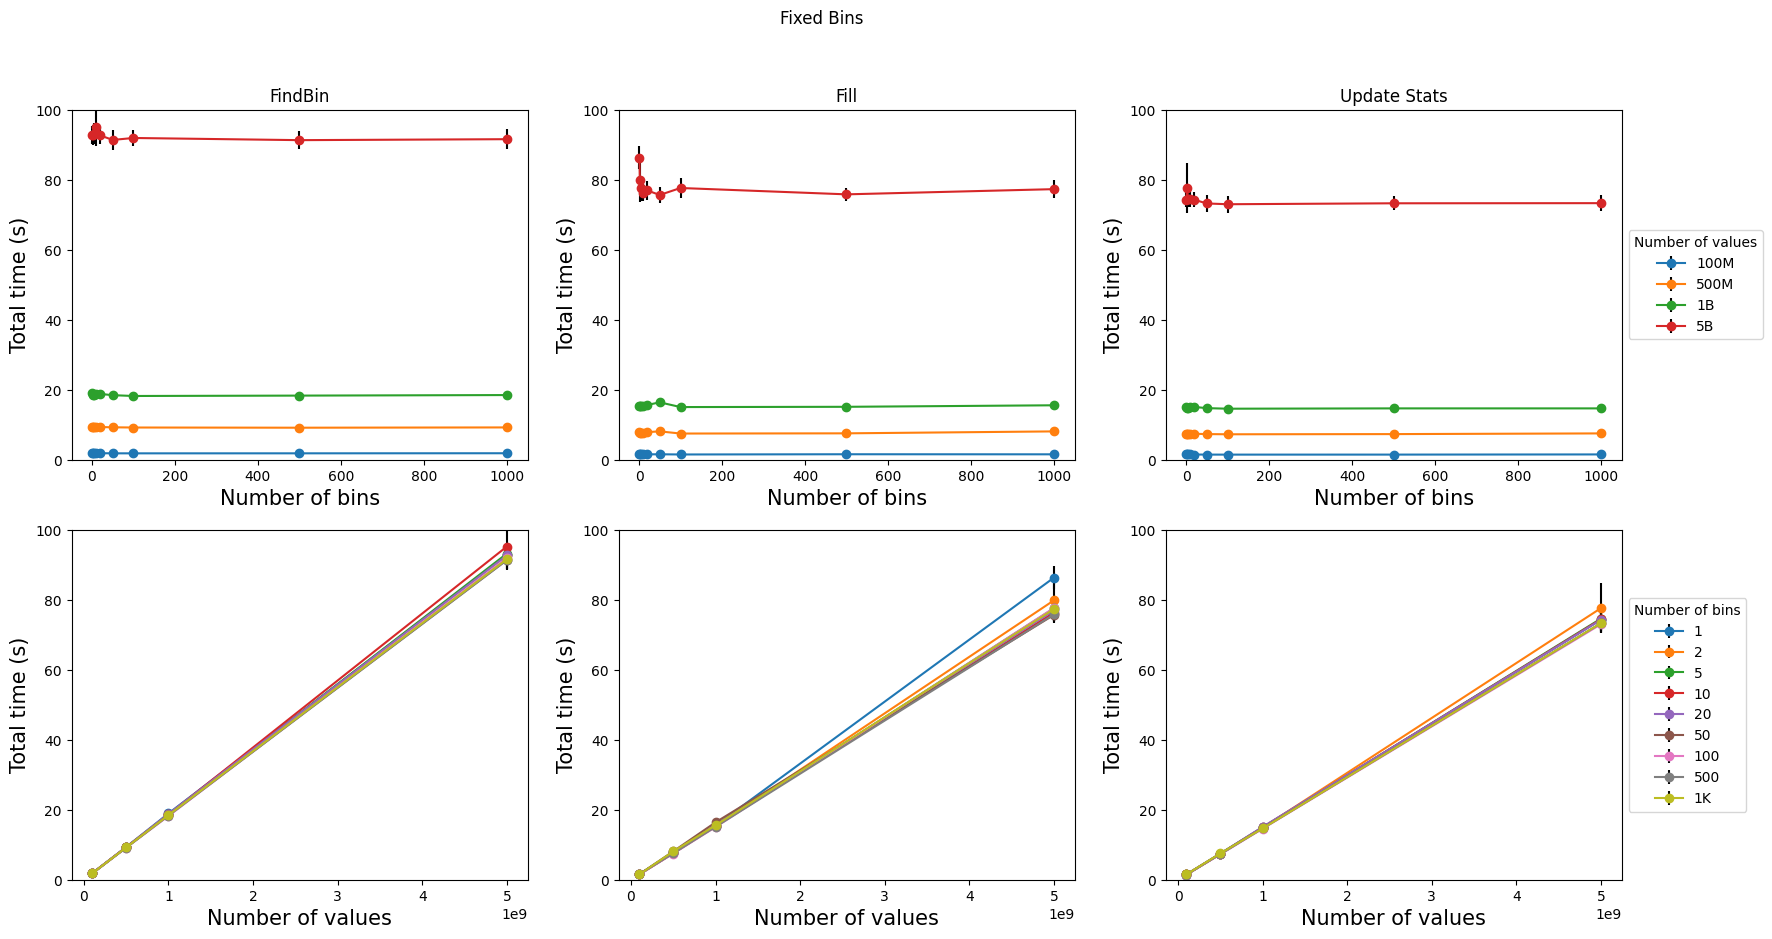

In [152]:
plt.figure(figsize=(20,10))
plt.suptitle("Fixed Bins")

def plot_perval(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nv in unique_nvals:
        plt.errorbar(unique_nbins, 
                     gp_bm.mean().loc[selected_env, selected_distr, nv, :, selected_bulksize][col], 
                     yerr=gp_bm.std().loc[selected_env, selected_distr, nv, :, selected_bulksize][col], 
                     marker="o", ecolor="k", label=f"{human_readable(nv)}")
    plt.xlabel(xlabel)
    plt.ylim(ylim)
    plt.ylabel(ylabel)

def plot_perbin(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nb in unique_nbins:
        plt.errorbar(unique_nvals, gp_bm.mean().loc[selected_env, selected_distr, :, nb, selected_bulksize][col], 
                     yerr=gp_bm.std().loc[selected_env, selected_distr, :, nb, selected_bulksize][col], 
                     marker="o", ecolor="k", label=f"{human_readable(nb)}")
    plt.xlabel("Number of values")
    plt.ylim(ylim)
    plt.ylabel(ylabel)

ylim=[0,100]
plt.subplot(231)
plot_perval("FindBin", "tfindbin", "Number of bins",  "Total time (s)", ylim)

plt.subplot(232)
plot_perval("Fill", "tfill", "Number of bins",  "Total time (s)", ylim)

plt.subplot(233)
plot_perval("Update Stats", "tstats", "Number of bins",  "Total time (s)", ylim)
plt.legend(title="Number of values", loc='center left', bbox_to_anchor=(1, 0.5))

ylim = [0, 100]
plt.subplot(234)
plot_perbin("", "tfindbin", "Number of values",  "Total time (s)", ylim)

plt.subplot(235)
plot_perbin("", "tfill", "Number of values",  "Total time (s)", ylim)

plt.subplot(236)
plot_perbin("", "tstats", "Number of values",  "Total time (s)", ylim)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

Plots the *average* time spent *per value* on finding bins, filling bins, and updating stats for **1D** histograms with **fixed bins**, **different** number of bins and **different** number of **doubles**. Total time averaged over **3 runs**

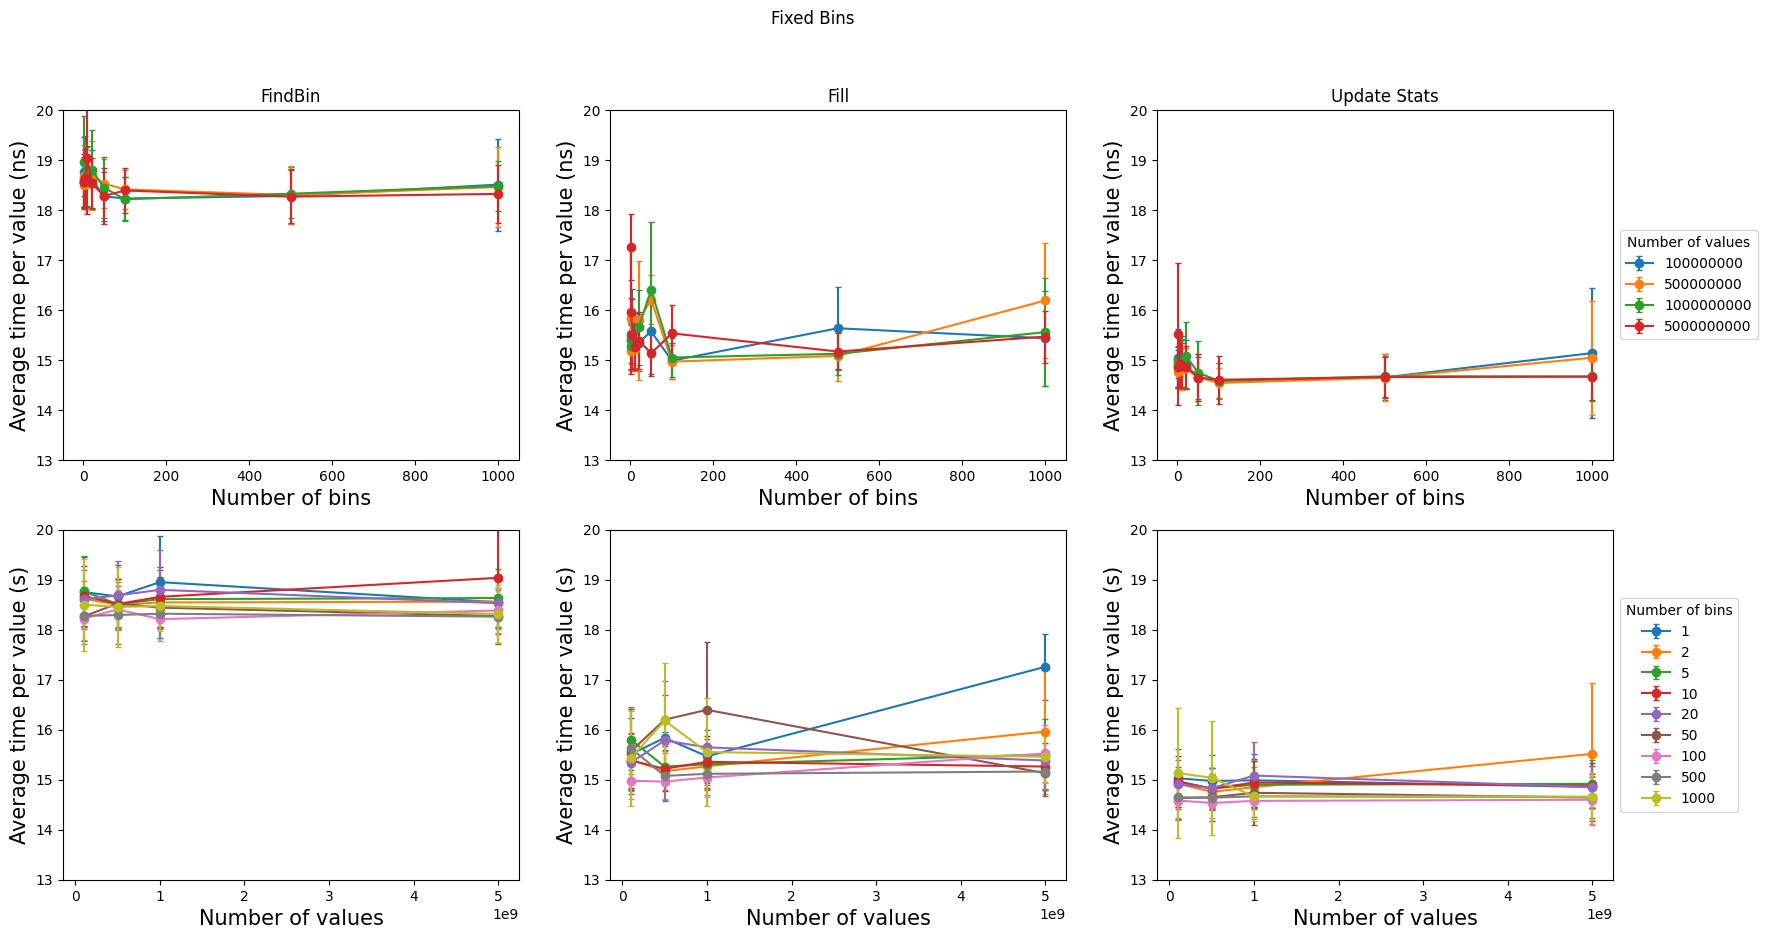

In [153]:
plt.figure(figsize=(20,10))
plt.suptitle("Fixed Bins")

def plot_perval_normalized(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nv in unique_nvals:
        plt.errorbar(unique_nbins, gp_bm.mean().loc[selected_env, selected_distr, nv, :, selected_bulksize][col]/nv/norm, 
                     yerr=gp_bm.std().loc[selected_env, selected_distr, nv, :, 1][col]/nv/norm, 
                     marker="o", capsize=2, label=f"{int(nv)}")
    plt.xlabel(xlabel)
    plt.ylim(ylim)
    plt.ylabel(ylabel)

def plot_perbin_normalized(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nb in unique_nbins:
        plt.errorbar(unique_nvals, gp_bm.mean().loc[selected_env, selected_distr, :, nb, selected_bulksize][col]/unique_nvals/norm, 
                     yerr=gp_bm.std().loc[selected_env, selected_distr, :, nb, selected_bulksize][col]/unique_nvals/norm, 
                     marker="o",  capsize=2, label=f"{int(nb)}")
    plt.xlabel("Number of values")
    plt.ylim(ylim)
    plt.ylabel("Average time per value (s)")

norm = 1e-9
ylim = [13, 20]
plt.subplot(231)
plot_perval_normalized("FindBin", "tfindbin", "Number of bins",  
                       "Average time per value (ns)", ylim, norm)

plt.subplot(232)
plot_perval_normalized("Fill", "tfill", "Number of bins",  
                       "Average time per value (ns)", ylim, norm)

plt.subplot(233)
plot_perval_normalized("Update Stats", "tstats", "Number of bins",  
                       "Average time per value (ns)", ylim, norm)
plt.legend(title="Number of values", loc='center left', bbox_to_anchor=(1, 0.5))

ylim = [13, 20]
plt.subplot(234)
plot_perbin_normalized("", "tfindbin", "Number of values",  
                       "Average time per value (ns)", ylim, norm)

plt.subplot(235)
plot_perbin_normalized("", "tfill", "Number of values",  
                       "Average time per value (ns)", ylim, norm)

plt.subplot(236)
plot_perbin_normalized("", "tstats", "Number of values",  
                       "Average time per value (ns)", ylim, norm)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

#### root plot

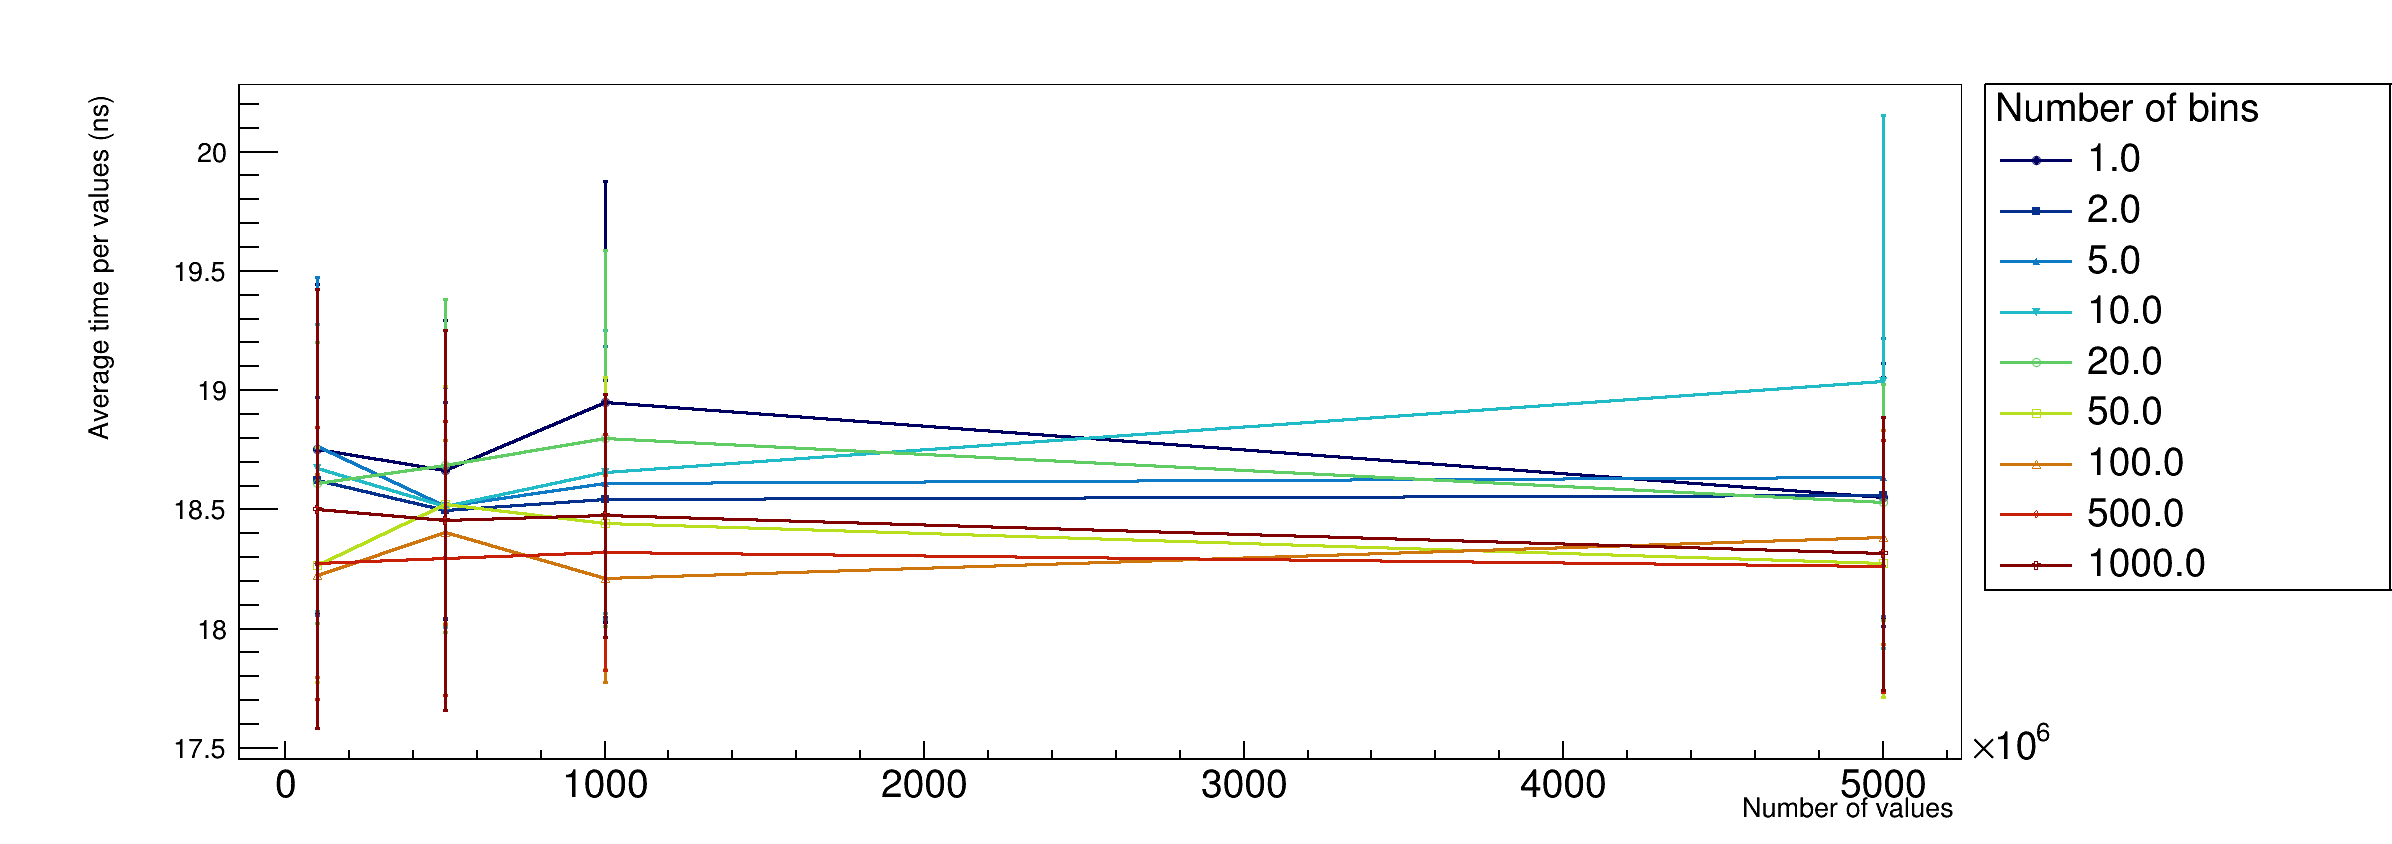

In [154]:
%jsroot off

selected_env = "CPU"
selected_bulksize = 1
selected_bins = unique_nbins
selected_nvals = 500000000
selected_distr = "uniform"
selected_edges = True

c = ROOT.TCanvas("c1", "")
rmargin = 0.18
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.3, 1, 0.9)
l.SetHeader("Number of bins")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for nbi, nb in enumerate(selected_bins):
    g = ROOT.TGraphErrors(len(unique_nvals), unique_nvals, 
                          gp_bm.mean().loc[selected_env, selected_distr, :, nb, selected_bulksize]
                                          ["tfindbin"].values/unique_nvals/norm,
                          ROOT.kNone,
                          gp_bm.std().loc[selected_env, selected_distr, :, nb, selected_bulksize]
                                          ["tfindbin"].values/unique_nvals/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(nb))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of values")

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")

l.Draw()
c.SaveAs("findbin_benchmark.pdf")
c.DrawClone()

### Variable Bins

In [155]:
filename = "nonbulk_1d_varbins.csv" 
df_bm = pd.read_csv(filename)
df_bm["nvals"] =  df_bm["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
df_bm["distribution"] =  df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_type(df_bm, "tfindbin", np.float64)
convert_to_type(df_bm, "tfill", np.float64)
convert_to_type(df_bm, "tstats", np.float64)
del df_bm["input"]
df_bm.head(7)

,iter,env,nbins,bulksize,tfindbin,tfill,tstats,nvals,distribution
0,0,CPU,1,1,8.505813,7.377600,7.210849,500000000.0,uniform
1,0,CPU,2,1,10.373811,7.340820,7.208909,500000000.0,uniform
2,0,CPU,5,1,12.226278,7.348425,7.215204,500000000.0,uniform
3,0,CPU,10,1,13.837383,7.321588,7.191632,500000000.0,uniform
4,0,CPU,20,1,15.398913,7.350384,7.185699,500000000.0,uniform
5,0,CPU,50,1,17.970907,7.431197,7.193031,500000000.0,uniform
6,0,CPU,100,1,19.601212,7.319499,7.188359,500000000.0,uniform


In [156]:
gp_bm = df_bm.groupby(["env", "distribution", "nvals", "nbins", "bulksize"])
gp_bm.mean()

iter   tfindbin     tfill  \
env distribution nvals       nbins bulksize                              
CPU uniform      500000000.0 1     1          1.0   8.486525  7.361389   
                             2     1          1.0  10.338577  7.629487   
                             5     1          1.0  12.239609  7.333011   
                             10    1          1.0  13.823583  7.317982   
                             20    1          1.0  15.489936  7.324246   
                             50    1          1.0  18.713807  7.593892   
                             100   1          1.0  19.838589  7.320013   
                             500   1          1.0  24.023485  7.404909   
                             1000  1          1.0  26.373816  7.720180   

                                               tstats  
env distribution nvals       nbins bulksize            
CPU uniform      500000000.0 1     1         7.196308  
                             2     1         7.200462  
                             5     1         7.201386  
                             10    1         7.189661  
                             20    1         7.184463  
                             50    1         7.301179  
                             100   1         7.184397  
                             500   1         7.198944  
                             1000  1         7.264606

In [157]:
unique_nbins = df_bm["nbins"].unique().astype(np.float64)
unique_nvals = df_bm["nvals"].unique().astype(np.float64)
unique_bulksize = df_bm["bulksize"].unique().astype(np.float64)
unique_nbins, unique_nvals, unique_bulksize

(array([   1.,    2.,    5.,   10.,   20.,   50.,  100.,  500., 1000.]),
 array([5.e+08]),
 array([1.]))

Plots the *average* time spent *per value* on finding bins, filling bins, and updating stats for **1D** histograms with **fixed bins**, **different** number of bins and **0.5B** number of **doubles**. Total time averaged over **3 runs**

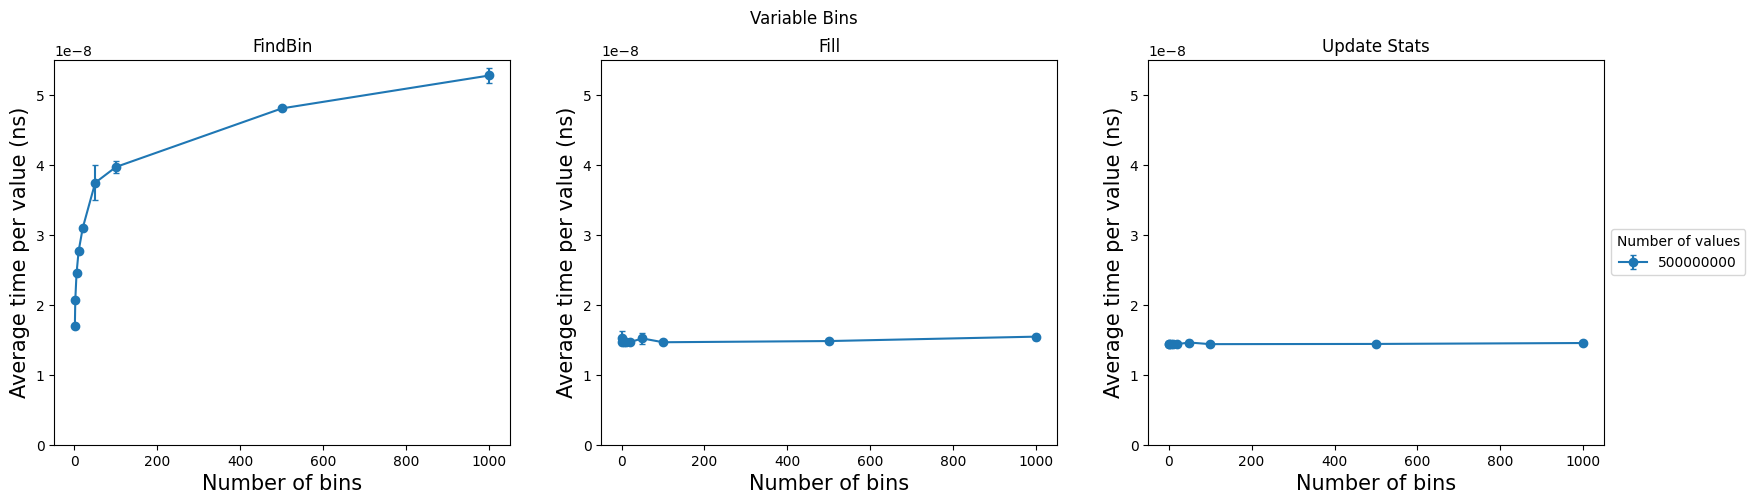

In [158]:
plt.figure(figsize=(20,5))
plt.suptitle("Variable Bins")

norm=1
ylim = [0*1e-8, 5.5*1e-8]
plt.subplot(131)
plot_perval_normalized("FindBin", "tfindbin", "Number of bins",  "Average time per value (ns)", ylim, norm)

plt.subplot(132)
plot_perval_normalized("Fill", "tfill", "Number of bins",  "Average time per value (ns)", ylim, norm)

plt.subplot(133)
plot_perval_normalized("Update Stats", "tstats", "Number of bins",  "Average time per value (ns)", ylim, norm)
plt.legend(title="Number of values", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [159]:
def convert_to_double_list(df, col):
    df[col] =  df[col].apply(lambda s: [np.float64(x) for x in s.split()])
    
filename = "nonbulk_1d_pervarbin.csv" 
df_bm = pd.read_csv(filename)
df_bm["nvals"] =  df_bm["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
df_bm["distribution"] =  df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_double_list(df_bm, "tfindbin")
convert_to_double_list(df_bm, "tfill")
convert_to_type(df_bm, "tstats", np.float64)
del df_bm["input"]
df_bm.head(7)

,iter,env,nbins,bulksize,tfindbin,tfill,tstats,nvals,distribution
0,0,CPU,1,1,"[0.0, 8.68143, 0.0]","[0.0, 7.492751, 0.0]",7.351574,500000000.0,uniform
1,0,CPU,2,1,"[0.0, 5.307118, 5.488702, 0.0]","[0.0, 3.86027, 3.858507, 0.0]",7.514040,500000000.0,uniform
2,0,CPU,5,1,"[0.0, 2.560204, 2.291943, 2.353472, 2.777817, ...","[0.0, 1.540131, 1.537355, 1.539111, 1.640972, ...",7.509003,500000000.0,uniform
3,0,CPU,10,1,"[0.0, 1.5087, 1.476285, 1.335727, 1.330733, 1....","[0.0, 0.753668, 0.752452, 0.750736, 0.752771, ...",7.362476,500000000.0,uniform
4,0,CPU,20,1,"[0.0, 0.813019, 0.798153, 0.786152, 0.78333, 0...","[0.0, 0.373925, 0.373674, 0.372761, 0.37377, 0...",7.267337,500000000.0,uniform
5,0,CPU,50,1,"[0.0, 0.378423, 0.363008, 0.362506, 0.369732, ...","[0.0, 0.186196, 0.1864, 0.186037, 0.18645, 0.1...",8.004499,500000000.0,uniform
6,0,CPU,100,1,"[0.0, 0.216131, 0.208753, 0.207718, 0.211024, ...","[0.0, 0.077682, 0.078071, 0.078216, 0.07779, 0...",7.602194,500000000.0,uniform


Plots the *average* time spent on finding a specific bin in an array with **100** bins for **0.5B** number of **doubles**. Total time averaged over **3 runs**

In [160]:
# w = 2400
# h = 900
# c = ROOT.TCanvas("c1", title, w, h)
# c.SetRightMargin(0.32)
# c.SetBottomMargin(0.33)
# c.Divide(2,1)

# l = ROOT.TLegend(0.7, 0.7, 0.96, 0.9)
# l.SetTextSize(0.05)

# g = ROOT.TGraph(100, np.arange(100, dtype=np.float64), gp_bm.agg(mean_list).loc["CPU", "uniform", 500000000, 100, 1]["tfindbin"][1:-1])
# g.SetMarkerSize(1)
# g.SetMarkerStyle(8)
# l.AddEntry(g, "Microbenchmark", "p")
# xaxis = g.GetXaxis()
# xaxis.SetTitle("Bin")
# yaxis = g.GetYaxis()
# yaxis.SetTitle(f"Time (ns)")
# xaxis.SetRangeUser(0, 100)

# c.cd(1)
# g.Draw("ALP")

# title="Time to find bin in an array with 100 bins"
# g.SetTitle(title)

# l.Draw()
# c.Draw()

Investigate caching within Histogram Filling

## With Bulk API

### Fixed Bins

In [161]:
filename = "das6-cpu/20231219-223056" 
df_bm = pd.read_csv(filename)
df_bm["nvals"] =  df_bm["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
df_bm["distribution"] =  df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_type(df_bm, "tfindbin", np.float64)
convert_to_type(df_bm, "tfill", np.float64)
convert_to_type(df_bm, "tstats", np.float64)
convert_to_type(df_bm, "edges", np.bool_)
del df_bm["input"]
df_bm.head(7)

,iter,env,nbins,bulksize,edges,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,CPU,10,32768,False,1.554148,1.554227,1.503259,6.917691,5.000000e+07,uniform
1,0,CPU,10,32768,True,2.312583,1.486713,1.437748,7.445708,5.000000e+07,uniform
2,0,CPU,10,32768,False,2.943891,2.943578,2.846900,13.057316,1.000000e+08,uniform
3,0,CPU,10,32768,True,4.502433,2.905612,2.811582,14.488305,1.000000e+08,uniform
4,0,CPU,10,32768,False,13.770380,13.769145,13.314771,60.914742,5.000000e+08,uniform
5,0,CPU,10,32768,True,21.315543,13.755605,13.322301,68.433975,5.000000e+08,uniform
6,0,CPU,10,32768,False,27.472334,27.472643,26.566176,121.638575,1.000000e+09,uniform


In [162]:
gp_bm = df_bm.groupby(["env", "distribution", "nvals", "nbins", "bulksize", "edges"])
gp_bm.mean()

iter    tfindbin  \
env distribution nvals        nbins    bulksize edges                     
CPU constant-0   1.000000e+08 10       32768    False   2.0    2.896366   
                                                True    2.0    3.127572   
                              1000     32768    False   2.0    2.901438   
                                                True    2.0    3.428760   
                              100000   32768    False   2.0    2.888056   
...                                                     ...         ...   
    uniform      1.000000e+09 1000     32768    True    2.0   82.364007   
                              100000   32768    False   2.0   27.887413   
                                                True    2.0  144.027271   
                              10000000 32768    False   2.0   27.178392   
                                                True    2.0  566.263470   

                                                            tfill     tstats  \
env distribution nvals        nbins    bulksize edges                          
CPU constant-0   1.000000e+08 10       32768    False    2.896346   2.800798   
                                                True     2.896089   2.800592   
                              1000     32768    False    2.899062   2.805596   
                                                True     2.886696   2.792135   
                              100000   32768    False    2.887984   2.792711   
...                                                           ...        ...   
    uniform      1.000000e+09 1000     32768    True    27.406209  26.488705   
                              100000   32768    False   29.504383  26.960920   
                                                True    30.345982  26.534830   
                              10000000 32768    False  155.969159  26.291931   
                                                True   182.106682  26.560186   

                                                           ttotal  
env distribution nvals        nbins    bulksize edges              
CPU constant-0   1.000000e+08 10       32768    False   12.872558  
                                                True    13.099753  
                              1000     32768    False   12.890801  
                                                True    13.368879  
                              100000   32768    False   12.835142  
...                                                           ...  
    uniform      1.000000e+09 1000     32768    True   176.369659  
                              100000   32768    False  130.899138  
                                                True   240.800159  
                              10000000 32768    False  249.588431  
                                                True   817.198956  

[88 rows x 5 columns]

In [163]:
unique_nbins = df_bm["nbins"].unique().astype(np.float64)
unique_nvals = df_bm["nvals"].unique().astype(np.float64)
unique_bulksize = df_bm["bulksize"].unique().astype(np.float64)
unique_distribution = df_bm["distribution"].unique()
unique_edges = [True, False]
unique_nbins, unique_nvals, unique_bulksize

(array([1.e+01, 1.e+03, 1.e+05, 1.e+07]),
 array([5.e+07, 1.e+08, 5.e+08, 1.e+09]),
 array([32768.]))

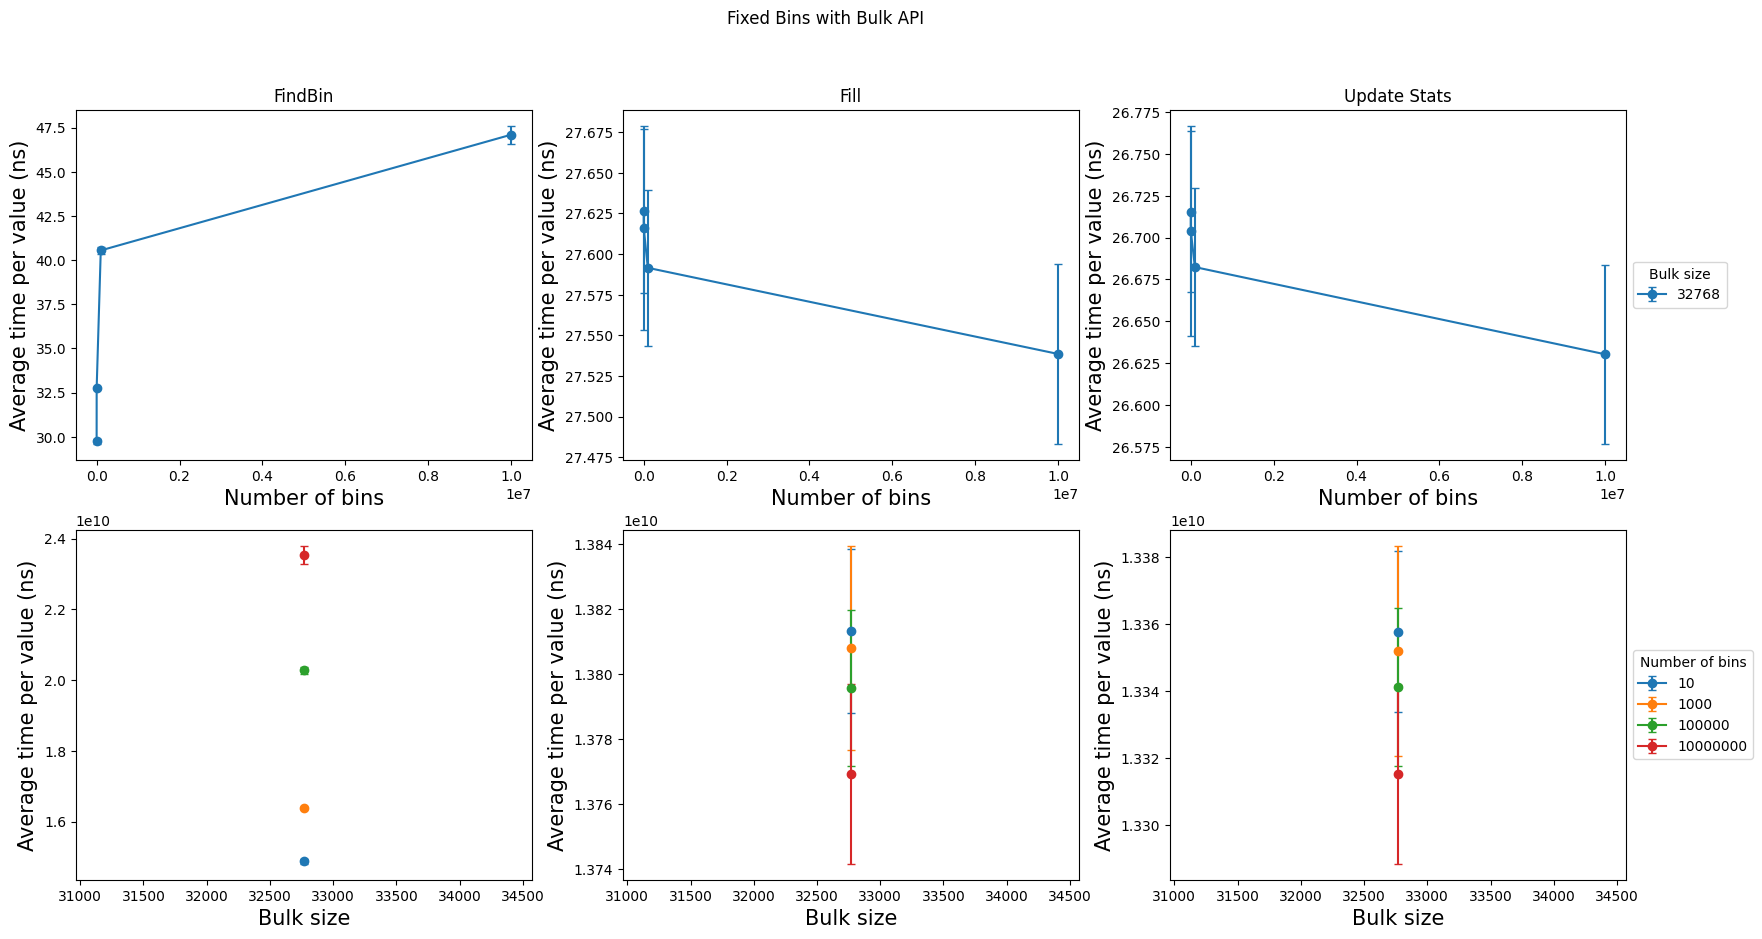

In [164]:
selected_env = "CPU"
selected_bulksize = 32768
selected_bins = unique_nbins[:-1]
selected_nvals = 500000000
selected_distr = "constant-0"
selected_edges = True

def plot_perbulk_normalized(title, col, xlabel, ylabel, xlim, ylim, norm=1):
    plt.title(title)
    for bs in unique_bulksize:
        plt.errorbar(unique_nbins, 
                     gp_bm.mean().loc[selected_env, selected_distr, selected_nvals, :, bs, selected_edges][col]/norm, 
                     yerr=gp_bm.std().loc[selected_env, selected_distr, selected_nvals, :, bs, selected_edges][col]/norm,
                     marker="o", capsize=3, label=f"{int(bs)}")
    plt.xlabel(xlabel)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.ylabel(ylabel)

def plot_perbin_normalized(title, col, xlabel, ylabel, xlim, ylim, norm=1):
    plt.title(title)
    for nb in unique_nbins:
        plt.errorbar(unique_bulksize, 
                     gp_bm.mean().loc[selected_env, selected_distr, selected_nvals, nb, :, selected_edges][col]/norm, 
                     yerr=gp_bm.std().loc[selected_env, selected_distr, selected_nvals, nb, :, selected_edges][col]/norm, 
                     marker="o", capsize=3, label=f"{int(nb)}")
    plt.xlabel(xlabel)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.ylabel(ylabel)
    
plt.figure(figsize=(20,10))
plt.suptitle("Fixed Bins with Bulk API")

norm=selected_nvals*1e-9
xlim = []
ylim = []
plt.subplot(231)
plot_perbulk_normalized("FindBin", "tfindbin", "Number of bins",  "Average time per value (ns)", xlim, ylim, norm)

plt.subplot(232)
plot_perbulk_normalized("Fill", "tfill", "Number of bins",  "Average time per value (ns)", xlim, ylim, norm)

plt.subplot(233)
plot_perbulk_normalized("Update Stats", "tstats", "Number of bins",  "Average time per value (ns)", xlim, ylim, norm)
plt.legend(title="Bulk size", loc='center left', bbox_to_anchor=(1, 0.5))

norm=1e-9
xlim = []
ylim = []
plt.subplot(234)
plot_perbin_normalized("", "tfindbin", "Bulk size",  "Average time per value (ns)", xlim, ylim, norm)

plt.subplot(235)
plot_perbin_normalized("", "tfill", "Bulk size",  "Average time per value (ns)", xlim, ylim, norm)

plt.subplot(236)
plot_perbin_normalized("", "tstats", "Bulk size",  "Average time per value (ns)", xlim, ylim, norm)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Plot average total time. **Note that this timing includes overhead of timers for the measurements above**

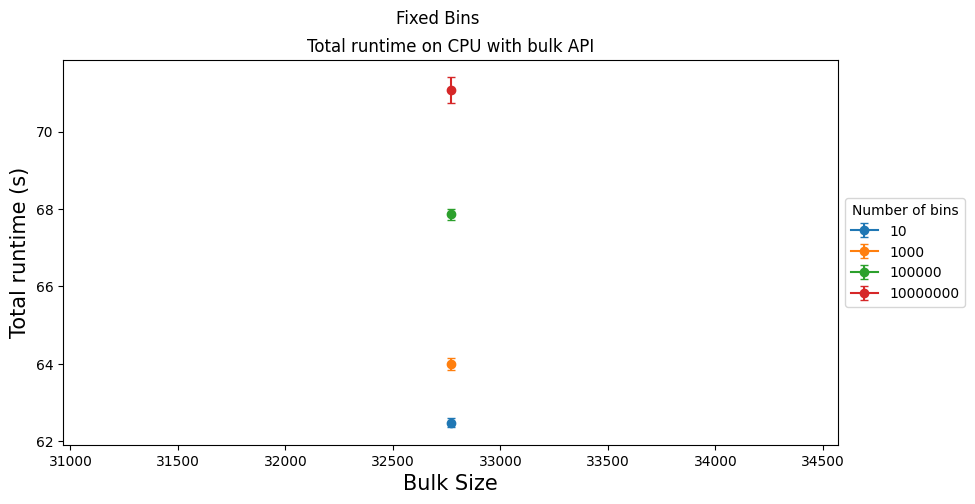

In [165]:
plt.figure(figsize=(10,5))
plt.suptitle("Fixed Bins")

norm=1
xlim = []
ylim = []
plt.subplot(111)
plot_perbin_normalized("Total runtime on CPU with bulk API", "ttotal", "Bulk Size", "Total runtime (s)", xlim, ylim, norm)
plt.legend(title="Number of bins", loc='center left', bbox_to_anchor=(1, 0.5))

**ROOT plot** Plot average time per value for different number of bins

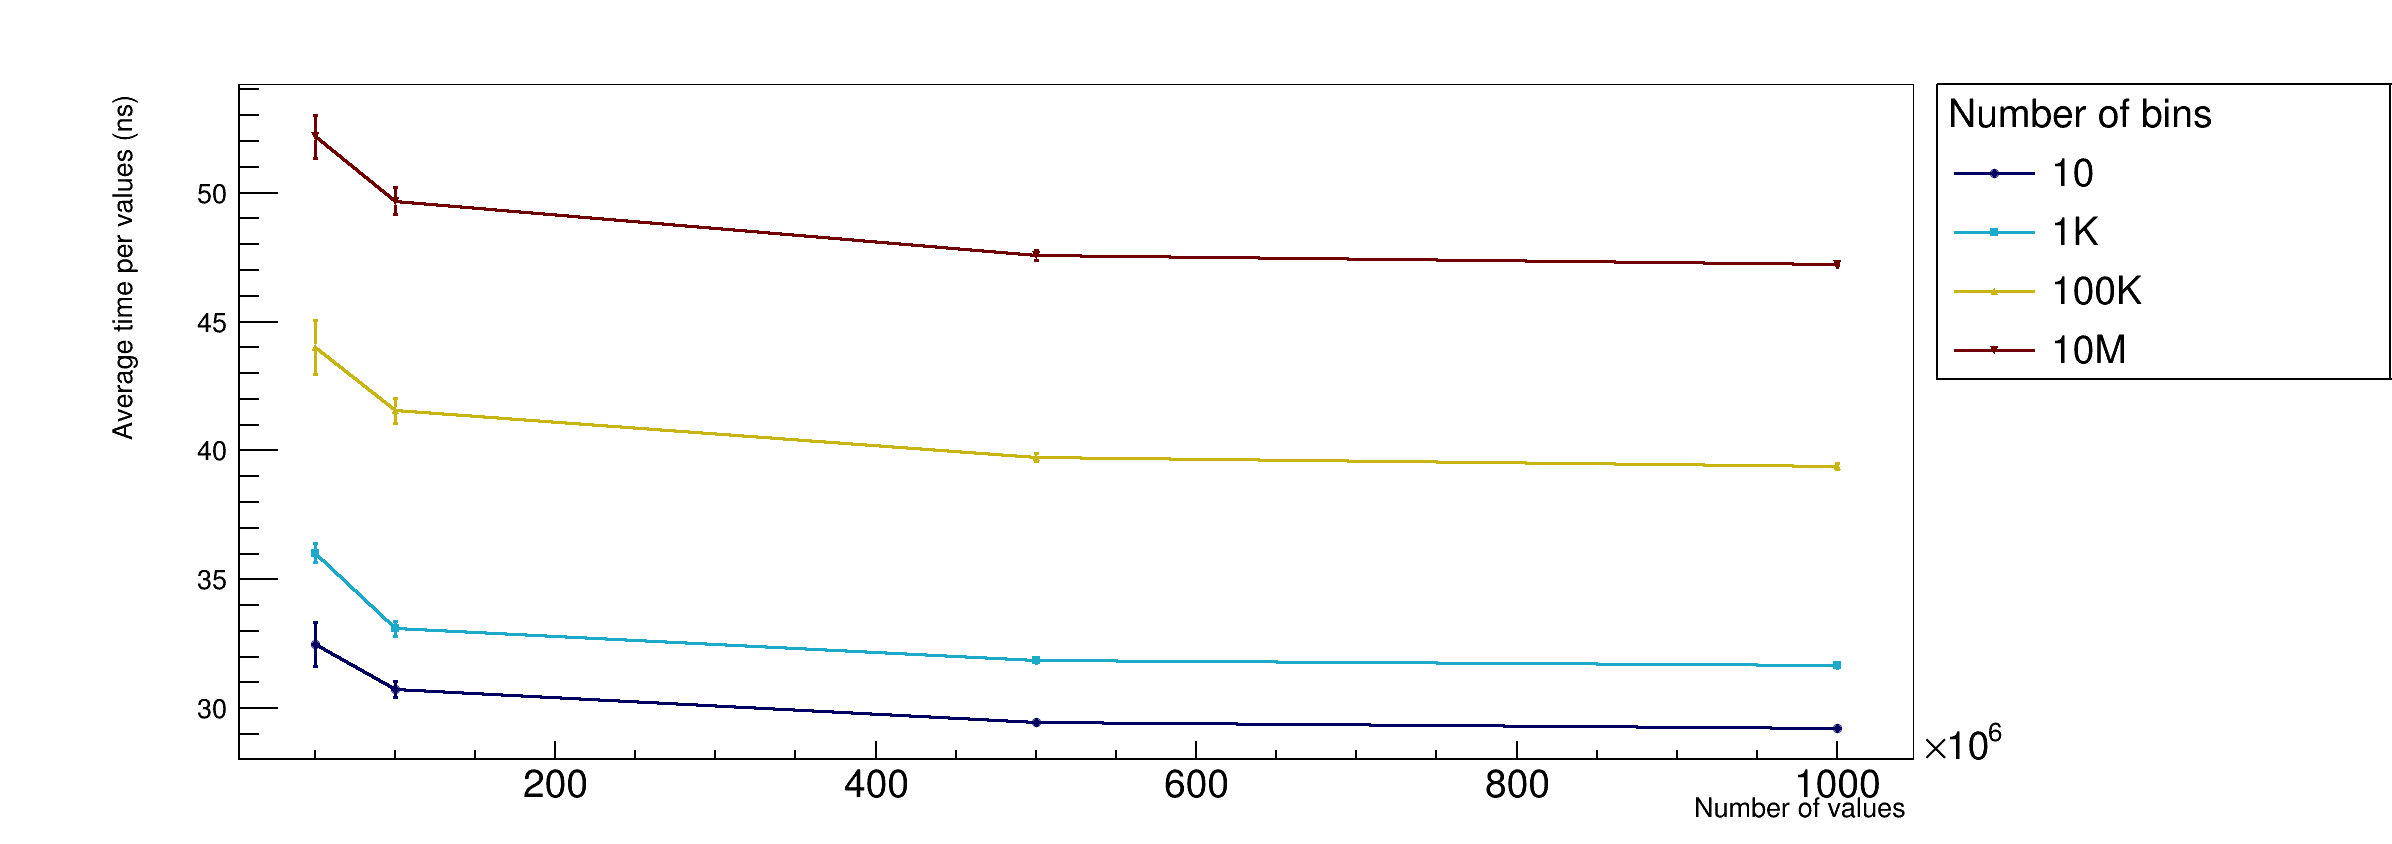

In [166]:
%jsroot off

selected_env = "CPU"
selected_bulksize = 32768
selected_bins = unique_nbins
selected_distr = "constant-0.5"
selected_edges = True
norm = unique_nvals/1e9

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.55, 1, 0.9)
l.SetHeader("Number of bins")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for nbi, nb in enumerate(selected_bins):
    g = ROOT.TGraphErrors(len(unique_nvals), unique_nvals, 
                          gp_bm.mean().loc[selected_env, selected_distr, :, nb, selected_bulksize, selected_edges]
                                          ["tfindbin"].values/norm,
                          ROOT.kNone,
                          gp_bm.std().loc[selected_env, selected_distr, :, nb, selected_bulksize, selected_edges]
                                          ["tfindbin"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, human_readable(nb))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of values")

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")

l.Draw()
c.SaveAs("../../images/findbin_nvals_vs_nbins.pdf")
c.DrawClone()

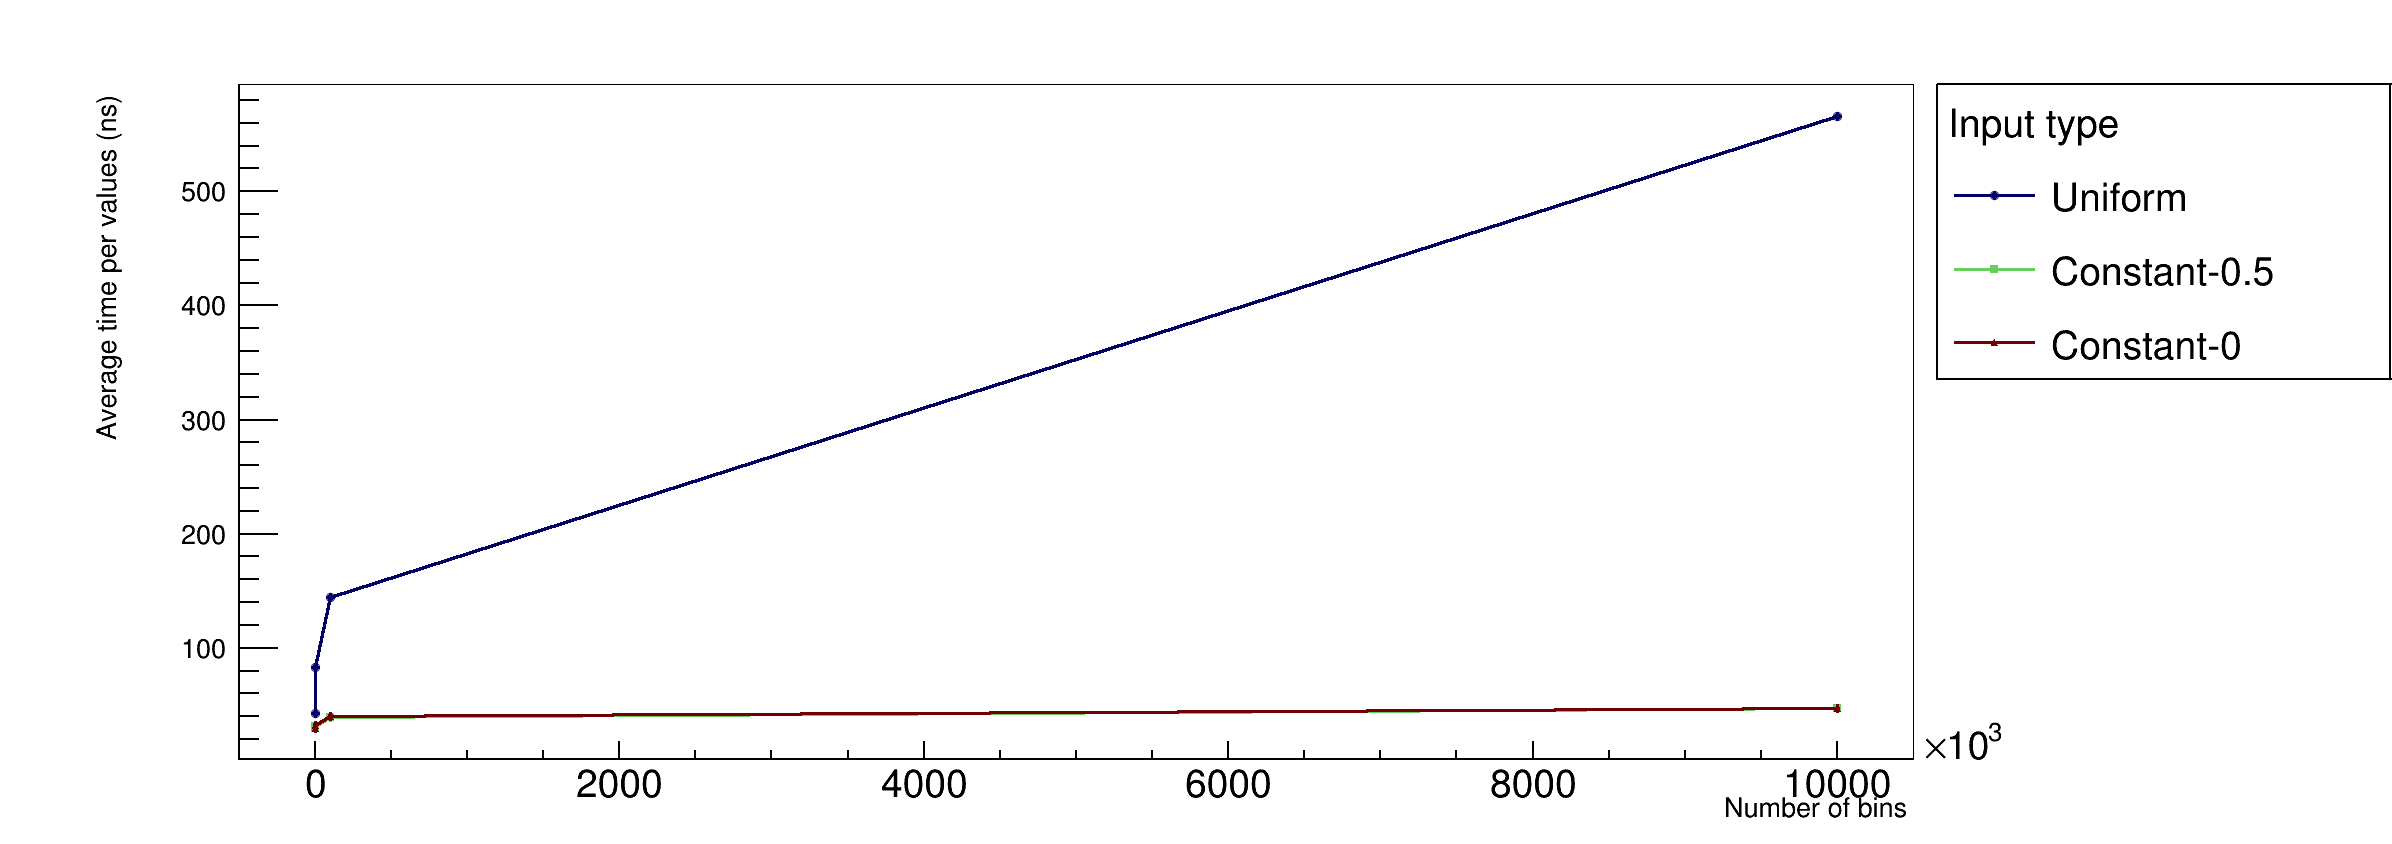

In [167]:
%jsroot off

selected_env = "CPU"
selected_bulksize = 32768
selected_bins = []
selected_distr = "constant-0.5"
selected_edges = True
selected_nvals = 500e6
norm = selected_nvals*1e-9

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.55, 1, 0.9)
l.SetHeader("Input type")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for (nbi, dis), lbl in zip(enumerate(unique_distribution), ["Uniform", "Bin 0", "Middle bin"]):
    g = ROOT.TGraphErrors(len(unique_nbins), unique_nbins, 
                          gp_bm.mean().loc[selected_env, dis, selected_nvals, :, selected_bulksize, selected_edges]
                                          ["tfindbin"].values/norm,
                          ROOT.kNone,
                          gp_bm.std().loc[selected_env, dis, selected_nvals, :, selected_bulksize, selected_edges]
                                          ["tfindbin"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(dis).title())
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of bins")
# c.SetLogx()
0000
yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")

l.Draw()
c.SaveAs("../../images/findbin_nbins_vs_distr.pdf")
c.DrawClone()

# Models

In [168]:
def f1_1(nbulks, bulksize, dim):
    T_d = 0
    T_u = 0
    T_RDF = 0 
    T_gb = 0
    T_mb = 0
    T_fb = 0
    T_usb = 0
    return T_d + T_u + T_RDF + np.sum([T_gb + T_mb + T_fb + T_usb for _ in range(nbulks)])

## Microbenchmark Data

In [169]:
filename = "../microbenchmarks/das6-cpu/investigational_benchamrks.json" 
# filename = "../das6-cpu-microbenchmark.result" 

with open(filename, "r") as f:
    jdata = json.load(f)
bm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(bm_df, "real_time", np.float64)
bm_df["func_name"] = bm_df["name"].apply(lambda s: s.split("/")[0][3:])    
bm_df["time_factor"] = bm_df["time_unit"].apply(convert_unit)
# bm_df["time (s)"] = bm_df["real_time"] * bm_df["time_unit"].apply(convert_unit)
del bm_df["family_index"], bm_df["per_family_instance_index"]
bm_df["time_factor"] = bm_df["time_unit"].apply(convert_unit)

bm_df.head(10)

,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,cpu_time,...,INSTRUCTIONS,L1-dcache-load-misses,L1-dcache-loads,cache-misses,cache-references,bin,nbins,val,func_name,time_factor
0,BM_PauseOverhead_mean,BM_PauseOverhead,aggregate,3.0,1,mean,time,3,1.000690,0.000485,...,4.020000e+02,3.726667e+01,3.185000e+02,484.333333,5.711333e+02,NaN,NaN,NaN,PauseOverhead_mean,1.0
1,BM_PauseOverhead_median,BM_PauseOverhead,aggregate,3.0,1,median,time,3,1.000696,0.000489,...,4.020000e+02,3.780000e+01,3.169000e+02,482.200000,5.714000e+02,NaN,NaN,NaN,PauseOverhead_median,1.0
2,BM_PauseOverhead_stddev,BM_PauseOverhead,aggregate,3.0,1,stddev,time,3,0.000016,0.000024,...,0.000000e+00,1.101514e+00,2.771281e+00,5.707305,7.803418e+00,NaN,NaN,NaN,PauseOverhead_stddev,1.0
3,BM_PauseOverhead_cv,BM_PauseOverhead,aggregate,3.0,1,cv,percentage,3,0.000016,0.050020,...,0.000000e+00,2.955762e-02,8.701040e-03,0.011784,1.366304e-02,NaN,NaN,NaN,PauseOverhead_cv,1.0
4,BM_ManualOverhead/manual_time_mean,BM_ManualOverhead/manual_time,aggregate,3.0,1,mean,time,3,1.000175,0.152388,...,6.437333e+08,2.492866e+06,2.837022e+08,72580.000000,4.873914e+06,NaN,NaN,NaN,ManualOverhead,1.0
5,BM_ManualOverhead/manual_time_median,BM_ManualOverhead/manual_time,aggregate,3.0,1,median,time,3,1.000174,0.152364,...,6.437321e+08,2.492850e+06,2.837116e+08,72802.000000,4.875622e+06,NaN,NaN,NaN,ManualOverhead,1.0
6,BM_ManualOverhead/manual_time_stddev,BM_ManualOverhead/manual_time,aggregate,3.0,1,stddev,time,3,0.000003,0.000079,...,2.140848e+03,2.348922e+02,4.455489e+04,543.163880,3.355285e+03,NaN,NaN,NaN,ManualOverhead,1.0
7,BM_ManualOverhead/manual_time_cv,BM_ManualOverhead/manual_time,aggregate,3.0,1,cv,percentage,3,0.000003,0.000518,...,3.325676e-06,9.422577e-05,1.570481e-04,0.007484,6.884169e-04,NaN,NaN,NaN,ManualOverhead,1.0
8,BM_LinearSearch/8/0_mean,BM_LinearSearch/8/0,aggregate,1000.0,1,mean,time,3,0.002535,0.002532,...,1.000700e+04,9.456869e-05,2.001026e+03,0.000076,7.612114e-03,-1.0,1.0,0.0,LinearSearch,1000.0
9,BM_LinearSearch/8/0_median,BM_LinearSearch/8/0,aggregate,1000.0,1,median,time,3,0.002736,0.002733,...,1.000700e+04,1.078882e-04,2.001028e+03,0.000072,8.167538e-03,-1.0,1.0,0.0,LinearSearch,1000.0


In [742]:
filename = "../microbenchmarks/das6-cpu/cpu_calibration_1.json"
# filename = "../das6-cpu-microbenchmark.result" 

with open(filename, "r") as f:
    jdata = json.load(f)
clb_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(clb_df, "real_time", np.float64)
clb_df["func_name"] = clb_df["name"].apply(lambda s: s.split("/")[0][3:].split("_")[0])    
clb_df["time_factor"] = clb_df["time_unit"].apply(convert_unit)
# bm_df["time (s)"] = bm_df["real_time"] * bm_df["time_unit"].apply(convert_unit)
del clb_df["family_index"], clb_df["per_family_instance_index"]
clb_df["time_factor"] = clb_df["time_unit"].apply(convert_unit)

# clb_df.head(10)
clb_df

,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,cpu_time,time_unit,INSTRUCTIONS,L1-dcache-load-misses,L1-dcache-loads,cache-misses,cache-references,dim,bin,func_name,time_factor
0,BM_UpdateStats/1/manual_time_mean,BM_UpdateStats/1/manual_time,aggregate,1000000.0,1,mean,time,3,34.182548,100.331291,ms,5.388817e+08,3.564286e+01,2.115852e+08,6.666667,4.189905e+03,1.0,NaN,UpdateStats,1000.0
1,BM_UpdateStats/1/manual_time_median,BM_UpdateStats/1/manual_time,aggregate,1000000.0,1,median,time,3,28.000178,82.248271,ms,5.388811e+08,2.242857e+01,2.115854e+08,5.642857,3.513500e+03,1.0,NaN,UpdateStats,1000.0
2,BM_UpdateStats/1/manual_time_stddev,BM_UpdateStats/1/manual_time,aggregate,0.0,1,stddev,time,3,11.623335,34.024176,ms,1.110762e+03,2.772229e+01,3.630281e+03,4.902276,1.572038e+03,0.0,NaN,UpdateStats,1000.0
3,BM_UpdateStats/1/manual_time_cv,BM_UpdateStats/1/manual_time,aggregate,0.0,1,cv,percentage,3,0.340037,0.339118,ms,2.061235e-06,7.777798e-01,1.715754e-05,0.735341,3.751965e-01,0.0,NaN,UpdateStats,1000.0
4,BM_UpdateStats/2/manual_time_mean,BM_UpdateStats/2/manual_time,aggregate,1000000.0,1,mean,time,3,28.159065,111.534417,ms,8.408172e+08,4.973333e+01,3.312123e+08,6.360000,5.566093e+03,2.0,NaN,UpdateStats,1000.0
5,BM_UpdateStats/2/manual_time_median,BM_UpdateStats/2/manual_time,aggregate,1000000.0,1,median,time,3,28.157272,111.503601,ms,8.408183e+08,5.916000e+01,3.312142e+08,7.280000,5.721000e+03,2.0,NaN,UpdateStats,1000.0
6,BM_UpdateStats/2/manual_time_stddev,BM_UpdateStats/2/manual_time,aggregate,0.0,1,stddev,time,3,0.004158,0.094526,ms,2.007793e+03,1.783777e+01,3.431643e+03,1.805325,2.706652e+02,0.0,NaN,UpdateStats,1000.0
7,BM_UpdateStats/2/manual_time_cv,BM_UpdateStats/2/manual_time,aggregate,0.0,1,cv,percentage,3,0.000148,0.000848,ms,2.387906e-06,3.586684e-01,1.036086e-05,0.283856,4.862750e-02,0.0,NaN,UpdateStats,1000.0
8,BM_UpdateStats/3/manual_time_mean,BM_UpdateStats/3/manual_time,aggregate,1000000.0,1,mean,time,3,29.656489,153.044687,ms,1.150753e+09,1.725694e+02,4.503788e+08,8.180556,8.239556e+03,3.0,NaN,UpdateStats,1000.0
9,BM_UpdateStats/3/manual_time_median,BM_UpdateStats/3/manual_time,aggregate,1000000.0,1,median,time,3,29.656017,152.902779,ms,1.150754e+09,1.940417e+02,4.503796e+08,8.416667,8.255167e+03,3.0,NaN,UpdateStats,1000.0


## Validation Data

In [171]:
# validation_results = "das6-cpu/20231127-223143" 
validation_results = "das6-cpu/inner_validation" 
validation_df = pd.read_csv(validation_results)
validation_df["nvals"] =  validation_df["input"].apply(lambda s: float(s.split("_")[-1].split(".")[0]))
validation_df["distribution"] =  validation_df["input"].apply(lambda s: s.split("_")[1])
convert_to_type(validation_df, "tfindbin", np.float64)
convert_to_type(validation_df, "tfill", np.float64)
convert_to_type(validation_df, "tstats", np.float64)
convert_to_type(validation_df, "edges", np.bool_)
del validation_df["input"]
validation_df

,iter,env,nbins,bulksize,edges,tfindbin,tfill,tstats,ttotal,nvals,distribution
0,0,CPU,10,1,False,1.449187,1.449085,1.401631,9.786637,5.000000e+07,constant-0.5
1,0,CPU,10,1,True,1.545473,1.449691,1.401741,9.805372,5.000000e+07,constant-0.5
2,0,CPU,10,1,False,2.865166,2.864471,2.770910,19.198013,1.000000e+08,constant-0.5
3,0,CPU,10,1,True,3.039631,2.851140,2.757595,19.295550,1.000000e+08,constant-0.5
4,0,CPU,10,1,False,13.715546,13.718097,13.263491,92.003111,5.000000e+08,constant-0.5
...,...,...,...,...,...,...,...,...,...,...,...
4475,4,CPU,10000000,262144,True,56.734950,18.278032,2.669207,81.932739,1.000000e+08,uniform
4476,4,CPU,10000000,262144,False,13.549795,82.686220,13.367405,130.060978,5.000000e+08,uniform
4477,4,CPU,10000000,262144,True,282.650025,91.342862,13.237006,407.963308,5.000000e+08,uniform
4478,4,CPU,10000000,262144,False,27.740233,163.698135,26.930798,258.924632,1.000000e+09,uniform


In [172]:
gp_vd = validation_df.groupby(["env", "distribution", "nvals", "nbins", "bulksize", "edges"])
gp_vd.mean()

iter    tfindbin  \
env distribution nvals        nbins    bulksize edges                     
CPU constant-0.5 5.000000e+07 10       1        False   2.0    1.476550   
                                                True    2.0    1.574404   
                                       8        False   2.0    1.511368   
                                                True    2.0    1.614679   
                                       64       False   2.0    1.545354   
...                                                     ...         ...   
    uniform      1.000000e+09 10000000 4096     True    2.0  576.801227   
                                       32768    False   2.0   27.536664   
                                                True    2.0  565.379023   
                                       262144   False   2.0   27.608763   
                                                True    2.0  564.246727   

                                                            tfill     tstats  \
env distribution nvals        nbins    bulksize edges                          
CPU constant-0.5 5.000000e+07 10       1        False    1.476834   1.427799   
                                                True     1.477014   1.428283   
                                       8        False    1.511463   1.461646   
                                                True     1.514859   1.464917   
                                       64       False    1.545351   1.494332   
...                                                           ...        ...   
    uniform      1.000000e+09 10000000 4096     True   182.246767  26.362560   
                                       32768    False  155.712613  26.412193   
                                                True   182.217307  26.459397   
                                       262144   False  164.322068  26.606622   
                                                True   181.868276  26.481644   

                                                           ttotal  
env distribution nvals        nbins    bulksize edges              
CPU constant-0.5 5.000000e+07 10       1        False    9.912318  
                                                True    10.011214  
                                       8        False    7.689068  
                                                True     7.838656  
                                       64       False    6.958184  
...                                                           ...  
    uniform      1.000000e+09 10000000 4096     True   826.475504  
                                       32768    False  249.413297  
                                                True   816.161273  
                                       262144   False  259.247127  
                                                True   813.958917  

[896 rows x 5 columns]

In [173]:
unique_nbins = validation_df["nbins"].unique().astype(np.float64)
unique_nvals = validation_df["nvals"].unique().astype(np.float64)
unique_bulksize = validation_df["bulksize"].unique().astype(np.float64)
unique_distribution = validation_df["distribution"].unique()
unique_edges = [True, False]
unique_nbins, unique_nvals, unique_bulksize, unique_distribution, unique_edges

(array([1.e+01, 1.e+03, 1.e+05, 1.e+07]),
 array([5.e+07, 1.e+08, 5.e+08, 1.e+09]),
 array([1.00000e+00, 8.00000e+00, 6.40000e+01, 5.12000e+02, 4.09600e+03,
        3.27680e+04, 2.62144e+05]),
 array(['constant-0.5', 'normal-0.4-0.1', 'normal-0.7-0.01', 'uniform'],
       dtype=object),
 [True, False])

## Update Stats Bulk

In [743]:
usb_df = clb_df[clb_df["func_name"] == "UpdateStats"].copy()
n_param = len(usb_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        usb_df[f"param_{i}"] = usb_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0])
    else:
        usb_df[f"param_{i}"] = usb_df["name"].apply(lambda s: s.split("/")[i+1])

usb_mean = usb_df.loc[usb_df["name"].str.contains("mean")]
usb_std = usb_df.loc[usb_df["name"].str.contains("stddev")]
# convert_to_type(
usb_mean

,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,cpu_time,...,L1-dcache-load-misses,L1-dcache-loads,cache-misses,cache-references,dim,bin,func_name,time_factor,param_0,param_1
0,BM_UpdateStats/1/manual_time_mean,BM_UpdateStats/1/manual_time,aggregate,1000000.0,1,mean,time,3,34.182548,100.331291,...,3.564286e+01,2.115852e+08,6.666667,4.189905e+03,1.0,NaN,UpdateStats,1000.0,1,manual
4,BM_UpdateStats/2/manual_time_mean,BM_UpdateStats/2/manual_time,aggregate,1000000.0,1,mean,time,3,28.159065,111.534417,...,4.973333e+01,3.312123e+08,6.360000,5.566093e+03,2.0,NaN,UpdateStats,1000.0,2,manual
8,BM_UpdateStats/3/manual_time_mean,BM_UpdateStats/3/manual_time,aggregate,1000000.0,1,mean,time,3,29.656489,153.044687,...,1.725694e+02,4.503788e+08,8.180556,8.239556e+03,3.0,NaN,UpdateStats,1000.0,3,manual
12,BM_UpdateStats/4/manual_time_mean,BM_UpdateStats/4/manual_time,aggregate,1000000.0,1,mean,time,3,32.087799,166.842928,...,5.775758e+01,4.915439e+08,11.833333,8.965939e+03,4.0,NaN,UpdateStats,1000.0,4,manual
16,BM_UpdateStats/8/manual_time_mean,BM_UpdateStats/8/manual_time,aggregate,1000000.0,1,mean,time,3,41.038668,239.636609,...,9.194118e+01,7.576391e+08,15.019608,1.374398e+04,8.0,NaN,UpdateStats,1000.0,8,manual
20,BM_UpdateStats/16/manual_time_mean,BM_UpdateStats/16/manual_time,aggregate,1000000.0,1,mean,time,3,76.569834,376.673983,...,1.218630e+03,1.280084e+09,29.481481,2.244689e+04,16.0,NaN,UpdateStats,1000.0,16,manual
24,BM_UpdateStats/32/manual_time_mean,BM_UpdateStats/32/manual_time,aggregate,1000000.0,1,mean,time,3,191.760031,659.134519,...,3.077500e+03,2.576761e+09,62.583333,4.073083e+04,32.0,NaN,UpdateStats,1000.0,32,manual
28,BM_UpdateStats/64/manual_time_mean,BM_UpdateStats/64/manual_time,aggregate,1000000.0,1,mean,time,3,605.704255,1356.609260,...,4.620082e+06,6.313488e+09,202.666667,4.699351e+06,64.0,NaN,UpdateStats,1000.0,64,manual
32,BM_UpdateStats/128/manual_time_mean,BM_UpdateStats/128/manual_time,aggregate,1000000.0,1,mean,time,3,2546.661733,3823.084542,...,1.114802e+09,1.897357e+10,523.333333,1.119040e+09,128.0,NaN,UpdateStats,1000.0,128,manual


In [744]:
T_updatestats = (
    usb_mean.loc[usb_mean["param_0"] == "1"]["real_time"] * 
    unit_to_unit_factor(usb_mean["time_unit"].values[0], "ns") / 
    usb_mean["repetitions"].values[0] 
)
T_updatestats

0    34.182548
Name: real_time, dtype: float64

uniform
MAE: 7.66381063615423
R2: -1538563.5956004346
uniform
MAE: 3.1284009180386203
R2: 81.30698856700269


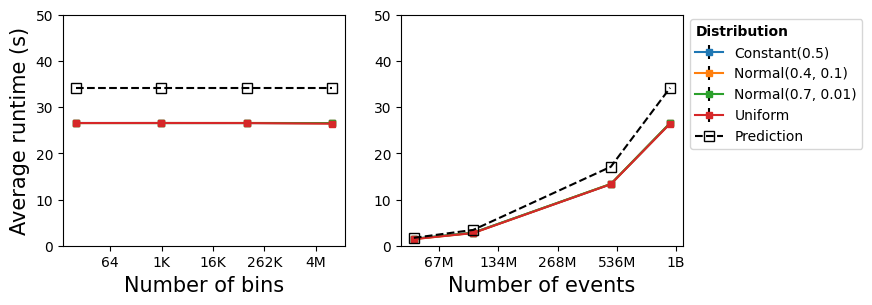

In [747]:
selected_env = "CPU" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = False
pred_color ="k"

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, selected_edges
    avg = gp_vd.mean().loc[arg]
    std = gp_vd.std().loc[arg]
    
    p = ax.errorbar(unique_nbins, avg["tstats"], 
                     yerr=std["tstats"], 
                     marker="s", ecolor="k", markersize=5,
                 # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
                 label=f"{map_distr_name(distr)}".title()
                )
    # Legend Labels
    # ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
    #                              facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
print(distr)
pred = np.repeat(T_updatestats * selected_nvals * unit_to_unit_factor("ns", "s"), len(unique_nbins))
ax.errorbar(unique_nbins, 
            pred, 
            c=pred_color,
            marker="s", markerfacecolor="none", ls="--", markersize=7,
)
observ = avg["tstats"].values
print("MAE:", mae(pred, observ))
print("R2:", r2(pred, observ) * 100)
    
plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylim([0, 50])
plt.ylabel("Average runtime (s)")

ax = plt.subplot(122)
for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, unique_nvals, selected_nbins, selected_bulksize, selected_edges
    avg = gp_vd.mean().loc[arg]
    std = gp_vd.std().loc[arg]
    
    p = ax.errorbar(unique_nvals, avg["tstats"], 
                     yerr=std["tstats"], 
                     marker="s", ecolor="k", markersize=5,
                 # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
                 label=f"{map_distr_name(distr)}".title()
                )
    # Legend Labels
    # ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
    #                              facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
print(distr)
pred = T_updatestats[0] * unique_nvals * unit_to_unit_factor("ns", "s")
ax.errorbar(unique_nvals, 
            pred, 
            c=pred_color,
            marker="s", markerfacecolor="none", ls="--", markersize=7,
            label="Prediction"
)
observ = avg["tstats"].values
print("MAE:", mae(pred, observ))
print("R2:", r2(pred, observ) * 100)
    
plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylim([0, 50])

plt.legend(title="Distribution", loc='center left', bbox_to_anchor=(1, 0.7),  alignment="left", title_fontproperties={'weight':'bold'})

plt.savefig("../../images/updatestats_validation_das6.pdf", format="pdf", bbox_inches='tight')
plt.show()

### Higher dimensions

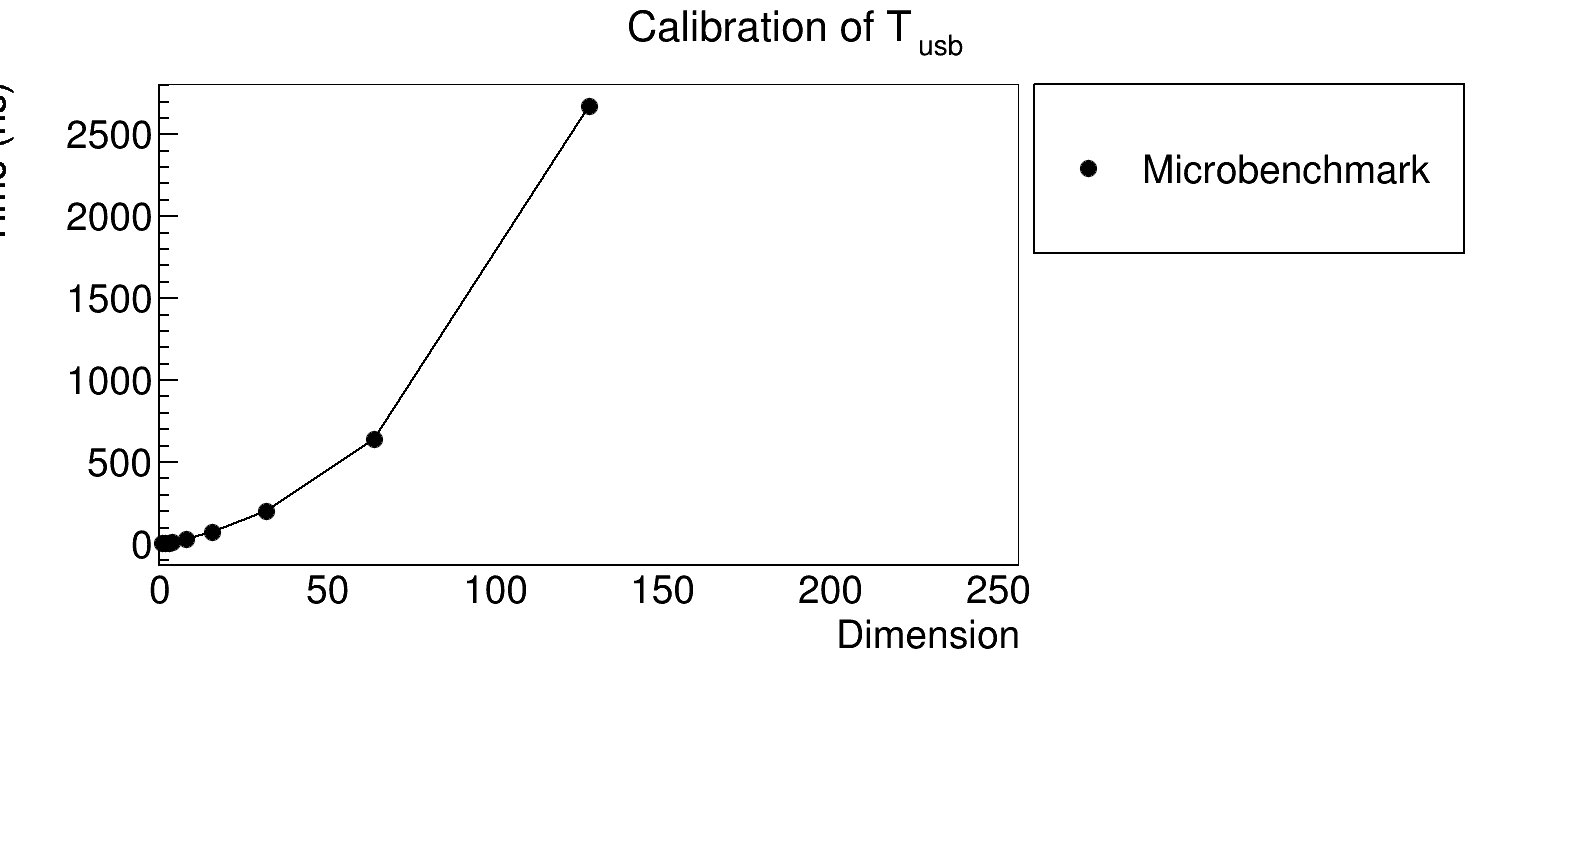

In [658]:
%jsroot off 

def f_usb(x, p):
    """
    Update Stats
    """
    return p[0] + x[0] * p[1] + x[0] * (x[0]-1) / 2 * p[2]
    # return T_alg1_3 + dim * T_alg1_5_6 + dim * (dim-1) / 2 * T_alg1_8

unit = "ns"
rep  = usb_mean["repetitions"].values[0]

w = 1600
h = 900
c = ROOT.TCanvas("c1", "", w, h)
c.SetRightMargin(0.36)
c.SetBottomMargin(0.33)
c.Divide(1, 3);

l = ROOT.TLegend(0.65, 0.7, 0.92, 0.9)
l.SetTextSize(0.05)

title="Calibration of T_{usb}"
mg = ROOT.TMultiGraph("mg", title)

avg = usb_mean["real_time"].values * unit_to_unit_factor(usb_mean["time_unit"].values[0], unit) / rep
std = usb_std["real_time"].values * unit_to_unit_factor(usb_std["time_unit"].values[0], unit) / rep
g = ROOT.TGraphErrors(len(usb_mean["param_0"]), usb_mean["param_0"].values.astype(np.float64), 
                      avg,
                      ROOT.kNone,
                      std)
g.SetMarkerSize(2)
g.SetMarkerStyle(20)
mg.Add(g, "LP")
l.AddEntry(g, "Microbenchmark", "p")

# model_usb = ROOT.TF1("f_usb", f_usb, 1, 200, 3)
# fit = g.Fit(model_usb, "S")
# l.AddEntry(model_usb, f"Fit")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Dimension")
# xaxis.SetTitleOffset(3)
xaxis.SetTitleSize(0.05)
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.05)
xaxis.LabelsOption("vM")
# xaxis.SetRangeUser(0, 10)

symlogx = get_symlog_bins(np.max(usb_mean["param_0"].values.astype(np.float64)) * 2, 2)
xaxis.Set(len(symlogx)-1, symlogx)
ROOT.gPad.Update()

yaxis = mg.GetYaxis()
yaxis.SetTitle(f"Time ({unit})")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
# yaxis.SetRangeUser(0, 40)

mg.DrawClone("A")
fit.Draw()

# c.SetLogx()

l.Draw()
c.DrawClone()

[7.         0.34549904 0.30601377]


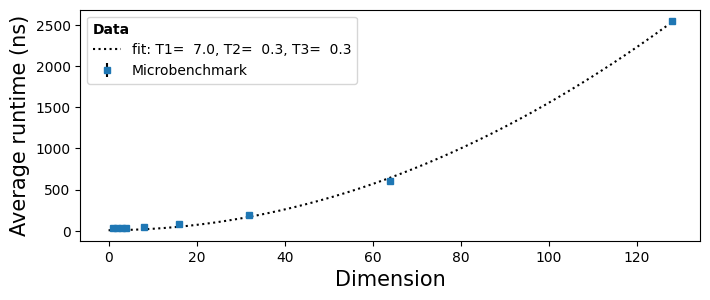

In [752]:
def f_usb(x, p1,p2,p3):
    """
    Update Stats
    """
    # return p[0] + x[0] * p[1] + x[0] * (x[0]-1) / 2 * p[2]
    return p1 + x * p2 + x * (x-1) / 2 * p3
    # return T_alg1_3 + dim * T_alg1_5_6 + dim * (dim-1) / 2 * T_alg1_8

selected_env = "CPU" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = False
pred_color ="k"
unit = "ns"
rep  = usb_mean["repetitions"].values[0]
dims = usb_mean["param_0"].values.astype(np.int64)

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(111)

avg = usb_mean["real_time"].values * unit_to_unit_factor(usb_mean["time_unit"].values[0], unit) / rep
std = usb_std["real_time"].values * unit_to_unit_factor(usb_std["time_unit"].values[0], unit) / rep
p = ax.errorbar(dims, avg, 
                 yerr=std, 
                 marker="s", ecolor="k", markersize=5, ls="none",
                 # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
                 label=f"microbenchmark".title()
            )

popt, pcov = scipy.optimize.curve_fit(f_usb, dims, avg, bounds=[0, [7,np.inf,np.inf]])
print(popt)
xdata = np.arange(128)
plt.plot(xdata, f_usb(xdata, *popt), 'k:',
         label='fit: T1=%5.1f, T2=%5.1f, T3=%5.1f' % tuple(popt))

plt.xlabel("Dimension")
# plt.xscale("log", base=2)
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylabel(f"Average runtime ({unit})")
# plt.ylim([0, 30])

plt.legend(title="Data", loc='upper left', 
           # bbox_to_anchor=(1, 0.7),  
           alignment="left", 
           title_fontproperties={'weight':'bold'})

plt.savefig("../../images/updatestats_multidim_fit.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [699]:
usb_mean["param_0"].values

array(['1', '2', '3', '4', '8', '16', '32', '64', '128'], dtype=object)

## Find Bin

### Binary Search

#### LMbench

In [177]:
lmbench_results = "das6-cpu/lmbench_das6"
with open(lmbench_results, "r") as f:
    lines = f.readlines()
    latencies = {}
    sizes = {}
    for l in lines:            
        if "stride" in l:
            stride = int(l.split("=")[1])
            latencies[stride] = []
            sizes[stride] = []
            continue

        if "." in l:
            latencies[stride].append(float(l.split()[1]))
            sizes[stride].append(float(l.split()[0]))

# latencies, sizes

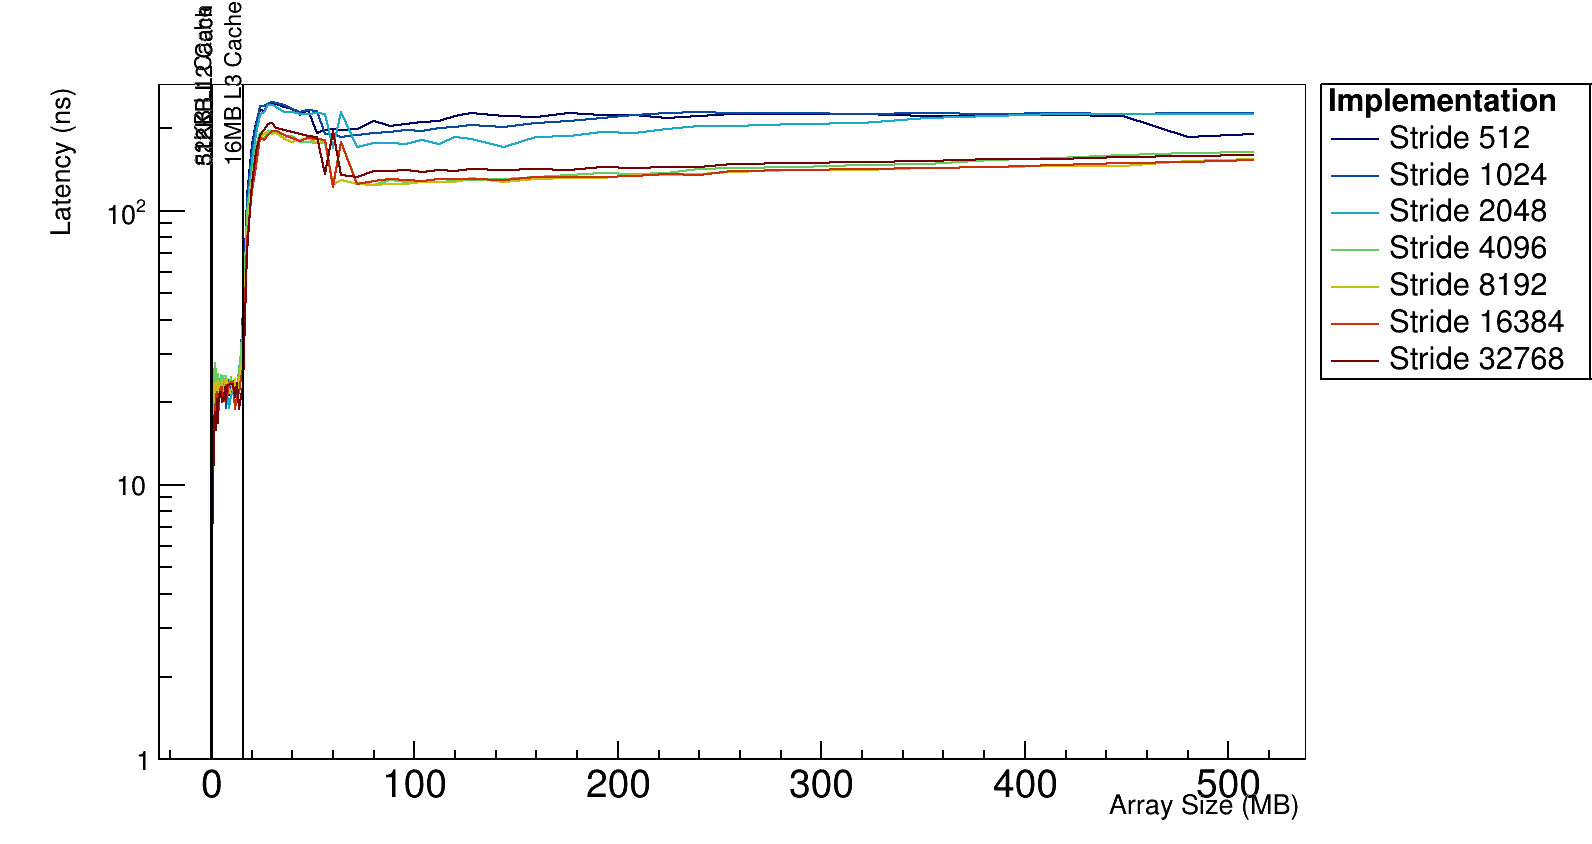

In [178]:
#### ROOT LMBench plot
%jsroot off

w = 1600
h = 900
c = ROOT.TCanvas("c1", "", w, h)

mg = ROOT.TMultiGraph()

rmargin = 0.18
bmargin = 0
c.SetRightMargin(rmargin)
# c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,0.55, 1, 0.9)
l.SetTextSize(0.04)
l.SetHeader("#bf{Implementation}")

ROOT.gStyle.SetPalette(ROOT.kRainbow);
for k,v in sizes.items():
    lmbench_graph = ROOT.TGraph(len(v), np.array(v), np.array(latencies[k]))
    lmbench_graph.SetTitle(f"Stride {k}")
    lmbench_graph.SetMarkerSize(0)
    l.AddEntry(lmbench_graph, f"Stride {k}")
    mg.Add(lmbench_graph, "")

hmax = 290
l1 =  ROOT.TGraph(2, np.array([0.032768,0.032768], dtype=np.float64), np.array([0, hmax], dtype=np.float64))
t1 = ROOT.TText(0.032768 -0.002, hmax/2, "32KB L1 Cache")
t1.SetTextAngle(90)
t1.SetTextSize(0.03)
l2 =  ROOT.TGraph(2, np.array([0.524288,0.524288], dtype=np.float64), np.array([0, hmax], dtype=np.float64))
t2 = ROOT.TText(0.524288 - 0.05, hmax/2, "512KB L2 Cache")
t2.SetTextAngle(90)
t2.SetTextSize(0.03)
l3 = ROOT.TGraph(2, np.array([16.,16.], dtype=np.float64), np.array([0, hmax], dtype=np.float64))
t3 = ROOT.TText(16-1, hmax/2, "16MB L3 Cache")
t3.SetTextAngle(90)
t3.SetTextSize(0.03)

xaxis = mg.GetXaxis()
xaxis.SetTitle("Array Size (MB)")
# xaxis.SetRangeUser(1, 1000)
# xaxis.SetLimits(1, 18)
# xaxis.SetNoExponent(ROOT.kTRUE)

yaxis = mg.GetYaxis()
yaxis.SetTitle(f"Latency (ns)")
yaxis.SetRangeUser(0.0001, hmax)
yaxis.SetLimits(0.0001, hmax)
yaxis.SetTitle("Latency (ns)")

mg.SetMinimum(1)
# mg.SetMaximum(100)
# mg.GetHistogram().SetMinimum(0.01);
# mg.GetHistogram().SetMaximum(100)

mg.Draw("A PLC L SAME")
l1.Draw("L SAME")
l2.Draw("L SAME")
l3.Draw("L SAME")
t1.Draw("")
t2.Draw("")
t3.Draw("")
l.Draw()

c.Modified();
# c.Update();
c.SetLogy()

c.SaveAs("../../images/lmbench_das6.pdf")
c.DrawClone()

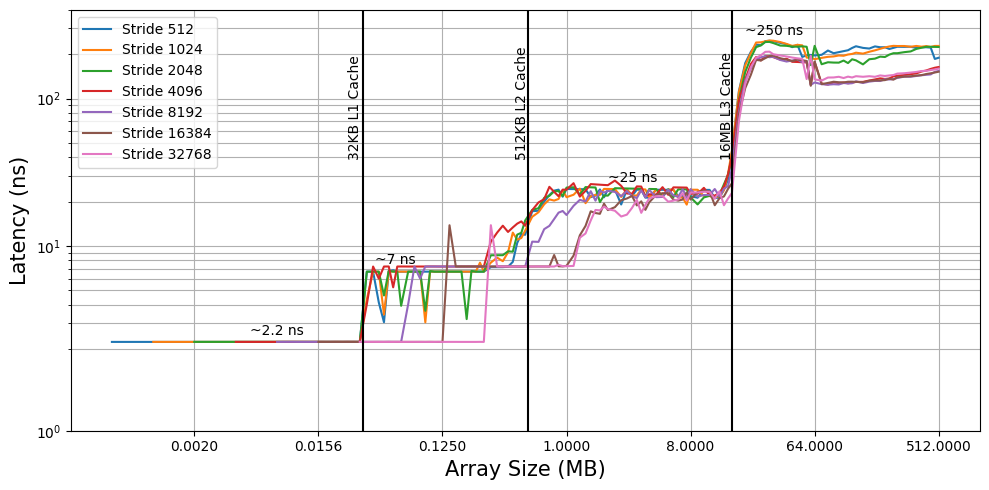

In [179]:
########### LMBench plot ###########
plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
for k,v in sizes.items():
    plt.plot(v, latencies[k], label=f"Stride {k}")

hmax = 400
div = 10
plt.vlines(0.032768, ymin=0, ymax=hmax, color="k" )
plt.text(0.032768 - 0.007, hmax/div, "32KB L1 Cache", rotation=90)
plt.vlines(0.524288, ymin=0, ymax=hmax, color="k" )
plt.text(0.524288 - 0.1, hmax/div, "512KB L2 Cache", rotation=90)
plt.vlines(16, ymin=0, ymax=hmax, color="k" )
plt.text(16 - 3, hmax/div, "16MB L3 Cache", rotation=90)

offset=0.5
hlx=0.005
# plt.hlines(2.2, xmin=0, xmax=32, color="gray")
plt.text(hlx, 2.5, "~2.2 ns")
# plt.hlines(7, xmin=0, xmax=32, color="gray")
plt.text(0.04, 7 + offset, "~7 ns")
# plt.hlines(25, xmin=0, xmax=32, color="gray")
plt.text(2, 25 + 2, "~25 ns")
# plt.hlines(250, xmin=0, xmax=32, color="gray")
plt.text(20, 250 + 20, "~250 ns")

plt.legend()

plt.xlabel("Array Size (MB)")
plt.xscale("log", base=2)
# plt.xlim([0.0005, 32])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.4f"))
# plt.ticklabel_format(axis='x', style='plain')

plt.ylabel("Latency (ns)")
plt.yscale("symlog")
plt.ylim([1, hmax])
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
plt.grid(True, which="both")

# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
plt.savefig("../../images/lmbench_das6.pdf",format="pdf")
plt.show()

In [180]:
########### LMBench values
T_l1 = 2.2
T_l2 = 7
T_l3 = 25
T_mem = 250

l1_size = 32768
l2_size = 524288
l3_size = 16777216

#### Binary Search Microbenchmark

##### Hypotheses
1. The search time for a specific bin is influenced by the total number of bins, as having more bins increases the search distance.
2. Different bins require a different search time as the search distance from the starting point changes. 
3. An identical path is traversed in the search tree if the same bin is searched multiple times, so a bin's search time does not vary significantly over multiple runs. This disregards the first search that results in compulsory cache misses to load the edges array into the cache. 

In [181]:
filename = "../microbenchmarks/das6_binsearch_moreh12.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
in_df = pd.DataFrame.from_dict(jdata["benchmarks"])
in_df

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,cpu_time,time_unit,L1-dcache-load-misses,instructions
0,BM_BinarySearchH12/8/0_mean,0,0,BM_BinarySearchH12/8/0,aggregate,3,1,mean,time,3,0.303424,0.303036,s,1.333333e+01,2.150000e+09
1,BM_BinarySearchH12/8/0_median,0,0,BM_BinarySearchH12/8/0,aggregate,3,1,median,time,3,0.318137,0.317704,s,1.550000e+01,2.150000e+09
2,BM_BinarySearchH12/8/0_stddev,0,0,BM_BinarySearchH12/8/0,aggregate,3,1,stddev,time,3,0.036497,0.036419,s,7.005950e+00,5.542563e+01
3,BM_BinarySearchH12/8/0_cv,0,0,BM_BinarySearchH12/8/0,aggregate,3,1,cv,percentage,3,0.120284,0.120179,s,5.254462e-01,2.577936e-08
4,BM_BinarySearchH12/1024/0_mean,0,1,BM_BinarySearchH12/1024/0,aggregate,3,1,mean,time,3,0.537527,0.537057,s,4.900000e+01,5.300001e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,BM_BinarySearchH4/131072/4_cv,2,14,BM_BinarySearchH4/131072/4,aggregate,3,1,cv,percentage,3,0.000460,0.000452,s,1.291976e-02,0.000000e+00
284,BM_BinarySearchH4/16777216/4_mean,2,15,BM_BinarySearchH4/16777216/4,aggregate,3,1,mean,time,3,4.635868,4.631659,s,6.854194e+08,8.019514e+09
285,BM_BinarySearchH4/16777216/4_median,2,15,BM_BinarySearchH4/16777216/4,aggregate,3,1,median,time,3,4.635550,4.631330,s,6.853088e+08,8.019514e+09
286,BM_BinarySearchH4/16777216/4_stddev,2,15,BM_BinarySearchH4/16777216/4,aggregate,3,1,stddev,time,3,0.001322,0.001396,s,5.713079e+05,1.108513e+02


In [182]:
df = in_df[in_df["name"].str.contains("mean")].copy()
df["func_name"] = df["run_name"].apply(lambda s: s.split("/")[0].split("_")[1])
df["mean_time"] = df.apply(lambda x: x["real_time"]/convert_unit(x["time_unit"]), axis=1)
df["std_time"] = in_df[in_df["name"].str.contains("stddev")]["real_time"].values
df["mean_l1"] = in_df[in_df["name"].str.contains("mean")]["L1-dcache-load-misses"].values
df["std_l1"] = in_df[in_df["name"].str.contains("stddev")]["L1-dcache-load-misses"].values
df["mean_instr"] = in_df[in_df["name"].str.contains("mean")]["instructions"].values
df["std_instr"] = in_df[in_df["name"].str.contains("stddev")]["instructions"].values
df

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,...,time_unit,L1-dcache-load-misses,instructions,func_name,mean_time,std_time,mean_l1,std_l1,mean_instr,std_instr
0,BM_BinarySearchH12/8/0_mean,0,0,BM_BinarySearchH12/8/0,aggregate,3,1,mean,time,3,...,s,1.333333e+01,2.150000e+09,BinarySearchH12,0.303424,0.036497,1.333333e+01,7.005950e+00,2.150000e+09,55.425626
4,BM_BinarySearchH12/1024/0_mean,0,1,BM_BinarySearchH12/1024/0,aggregate,3,1,mean,time,3,...,s,4.900000e+01,5.300001e+09,BinarySearchH12,0.537527,0.005616,4.900000e+01,3.559494e+01,5.300001e+09,0.000000
8,BM_BinarySearchH12/4096/0_mean,0,2,BM_BinarySearchH12/4096/0,aggregate,3,1,mean,time,3,...,s,1.346667e+02,6.200001e+09,BinarySearchH12,0.492701,0.001592,1.346667e+02,3.939014e+01,6.200001e+09,0.000000
12,BM_BinarySearchH12/131072/0_mean,0,3,BM_BinarySearchH12/131072/0,aggregate,3,1,mean,time,3,...,s,7.278161e+07,8.450001e+09,BinarySearchH12,0.663204,0.019957,7.278161e+07,7.550223e+06,8.450001e+09,0.000000
16,BM_BinarySearchH12/65536/0_mean,0,4,BM_BinarySearchH12/65536/0,aggregate,3,1,mean,time,3,...,s,2.947333e+03,8.000001e+09,BinarySearchH12,0.608100,0.000639,2.947333e+03,6.093951e+02,8.000001e+09,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,BM_BinarySearchH4/16777216/3_mean,2,11,BM_BinarySearchH4/16777216/3,aggregate,3,1,mean,time,3,...,s,7.736040e+08,9.009371e+09,BinarySearchH4,5.238038,0.001441,7.736040e+08,1.337576e+05,9.009371e+09,156.767344
272,BM_BinarySearchH4/8/4_mean,2,12,BM_BinarySearchH4/8/4,aggregate,3,1,mean,time,3,...,s,5.222222e+00,2.106250e+09,BinarySearchH4,0.206178,0.001038,5.222222e+00,2.694301e+00,2.106250e+09,27.712813
276,BM_BinarySearchH4/1024/4_mean,2,13,BM_BinarySearchH4/1024/4,aggregate,3,1,mean,time,3,...,s,6.190333e+03,5.300672e+09,BinarySearchH4,1.969890,0.008770,6.190333e+03,1.108355e+03,5.300672e+09,0.000000
280,BM_BinarySearchH4/131072/4_mean,2,14,BM_BinarySearchH4/131072/4,aggregate,3,1,mean,time,3,...,s,4.155890e+07,8.614385e+09,BinarySearchH4,2.498581,0.001150,4.155890e+07,5.369309e+05,8.614385e+09,0.000000


In [183]:
h12_df = df[df["func_name"] == "BinarySearchH12"].copy()
h12_df["nbins"] = h12_df["run_name"].apply(lambda s: float(s.split("/")[1]))
h12_df["bin"] = h12_df["run_name"].apply(lambda s: float(s.split("/")[2])/2)
h12_df

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,...,instructions,func_name,mean_time,std_time,mean_l1,std_l1,mean_instr,std_instr,nbins,bin
0,BM_BinarySearchH12/8/0_mean,0,0,BM_BinarySearchH12/8/0,aggregate,3,1,mean,time,3,...,2.150000e+09,BinarySearchH12,0.303424,0.036497,1.333333e+01,7.005950e+00,2.150000e+09,55.425626,8.0,0.0
4,BM_BinarySearchH12/1024/0_mean,0,1,BM_BinarySearchH12/1024/0,aggregate,3,1,mean,time,3,...,5.300001e+09,BinarySearchH12,0.537527,0.005616,4.900000e+01,3.559494e+01,5.300001e+09,0.000000,1024.0,0.0
8,BM_BinarySearchH12/4096/0_mean,0,2,BM_BinarySearchH12/4096/0,aggregate,3,1,mean,time,3,...,6.200001e+09,BinarySearchH12,0.492701,0.001592,1.346667e+02,3.939014e+01,6.200001e+09,0.000000,4096.0,0.0
12,BM_BinarySearchH12/131072/0_mean,0,3,BM_BinarySearchH12/131072/0,aggregate,3,1,mean,time,3,...,8.450001e+09,BinarySearchH12,0.663204,0.019957,7.278161e+07,7.550223e+06,8.450001e+09,0.000000,131072.0,0.0
16,BM_BinarySearchH12/65536/0_mean,0,4,BM_BinarySearchH12/65536/0,aggregate,3,1,mean,time,3,...,8.000001e+09,BinarySearchH12,0.608100,0.000639,2.947333e+03,6.093951e+02,8.000001e+09,0.000000,65536.0,0.0
20,BM_BinarySearchH12/3670016/0_mean,0,5,BM_BinarySearchH12/3670016/0,aggregate,3,1,mean,time,3,...,1.025000e+10,BinarySearchH12,1.133068,0.024580,2.208881e+08,8.688529e+06,1.025000e+10,0.000000,3670016.0,0.0
24,BM_BinarySearchH12/8388608/0_mean,0,6,BM_BinarySearchH12/8388608/0,aggregate,3,1,mean,time,3,...,1.115000e+10,BinarySearchH12,1.858260,0.006722,5.688802e+08,1.874850e+06,1.115000e+10,156.767344,8388608.0,0.0
28,BM_BinarySearchH12/16777216/0_mean,0,7,BM_BinarySearchH12/16777216/0,aggregate,3,1,mean,time,3,...,1.160000e+10,BinarySearchH12,1.974601,0.000451,6.459000e+08,4.195229e+05,1.160000e+10,156.767344,16777216.0,0.0
32,BM_BinarySearchH12/8/1_mean,0,8,BM_BinarySearchH12/8/1,aggregate,3,1,mean,time,3,...,1.750000e+09,BinarySearchH12,0.104926,0.000064,5.761905e+00,3.511885e+00,1.750000e+09,0.000000,8.0,0.5
36,BM_BinarySearchH12/1024/1_mean,0,9,BM_BinarySearchH12/1024/1,aggregate,3,1,mean,time,3,...,5.250001e+09,BinarySearchH12,0.380359,0.000397,1.550000e+01,8.660254e-01,5.250001e+09,0.000000,1024.0,0.5


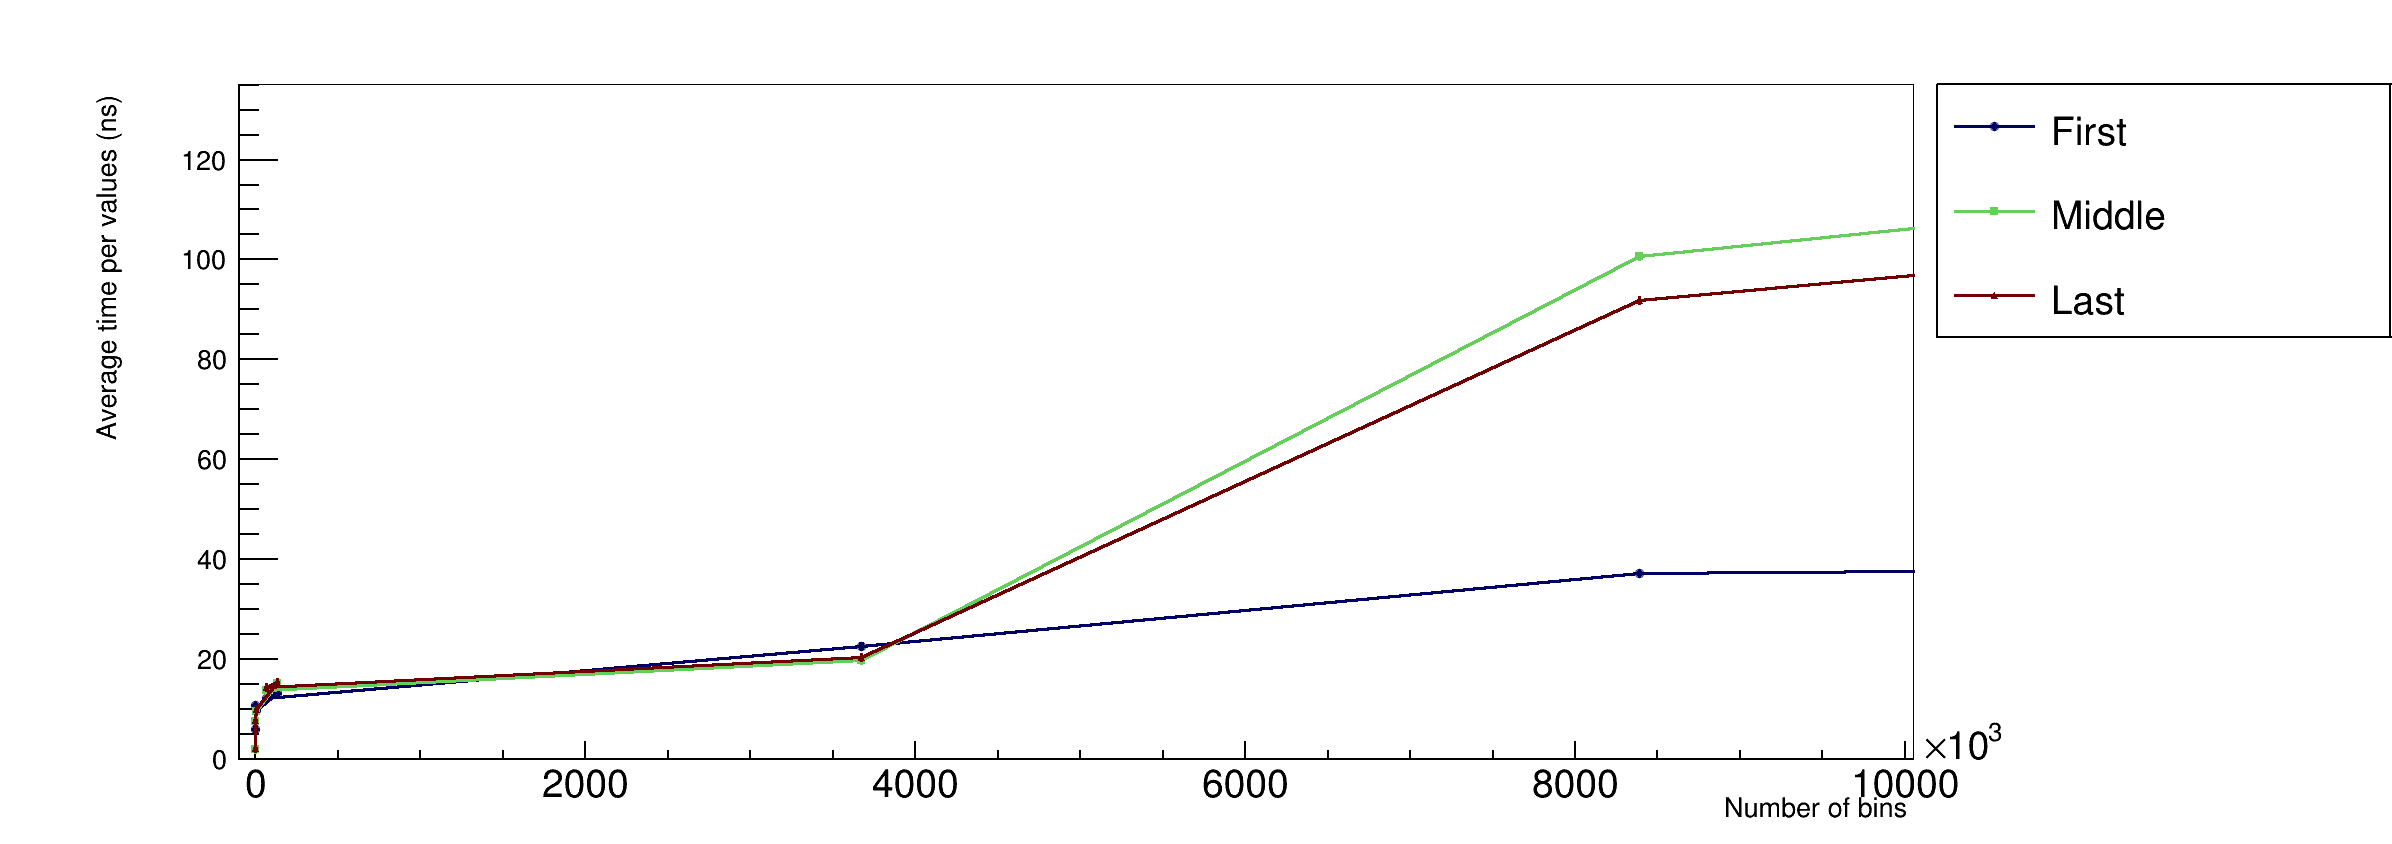

In [184]:
%jsroot off

selected_nbins = h12_df["nbins"].unique()
selected_bin = h12_df["bin"].unique()
norm = 50e6/1e9

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
# l.SetHeader("Input type")
# header = l.GetListOfPrimitives().First();
# header.SetTextSize(0.05)bin: 16777215bin: 16777215bin: 16777215bin: 16777215bin: 16777215bin: 16777215bin: 16777215bin: 16777215

title=""
mg = ROOT.TMultiGraph("mg", title)
for (nbi, dis), lbl in zip(enumerate(selected_bin), ["First", "Middle", "Last"]):
    g = ROOT.TGraphErrors(len(selected_nbins), selected_nbins, 
                          h12_df[h12_df["bin"] == dis]["mean_time"].values/norm,
                          ROOT.kNone,
                          h12_df[h12_df["bin"] == dis]["std_time"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(lbl).title())      

mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of bins")
xaxis.SetRangeUser(0.01, 10000000);
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")
# yaxis.SetTitle("Total time (s)")columnscolumnscolumnscolumns

l.Draw()      
# c.SaveAs("../../images/mb_findbin_nbins_vs_bin.pdf")
c.DrawClone()

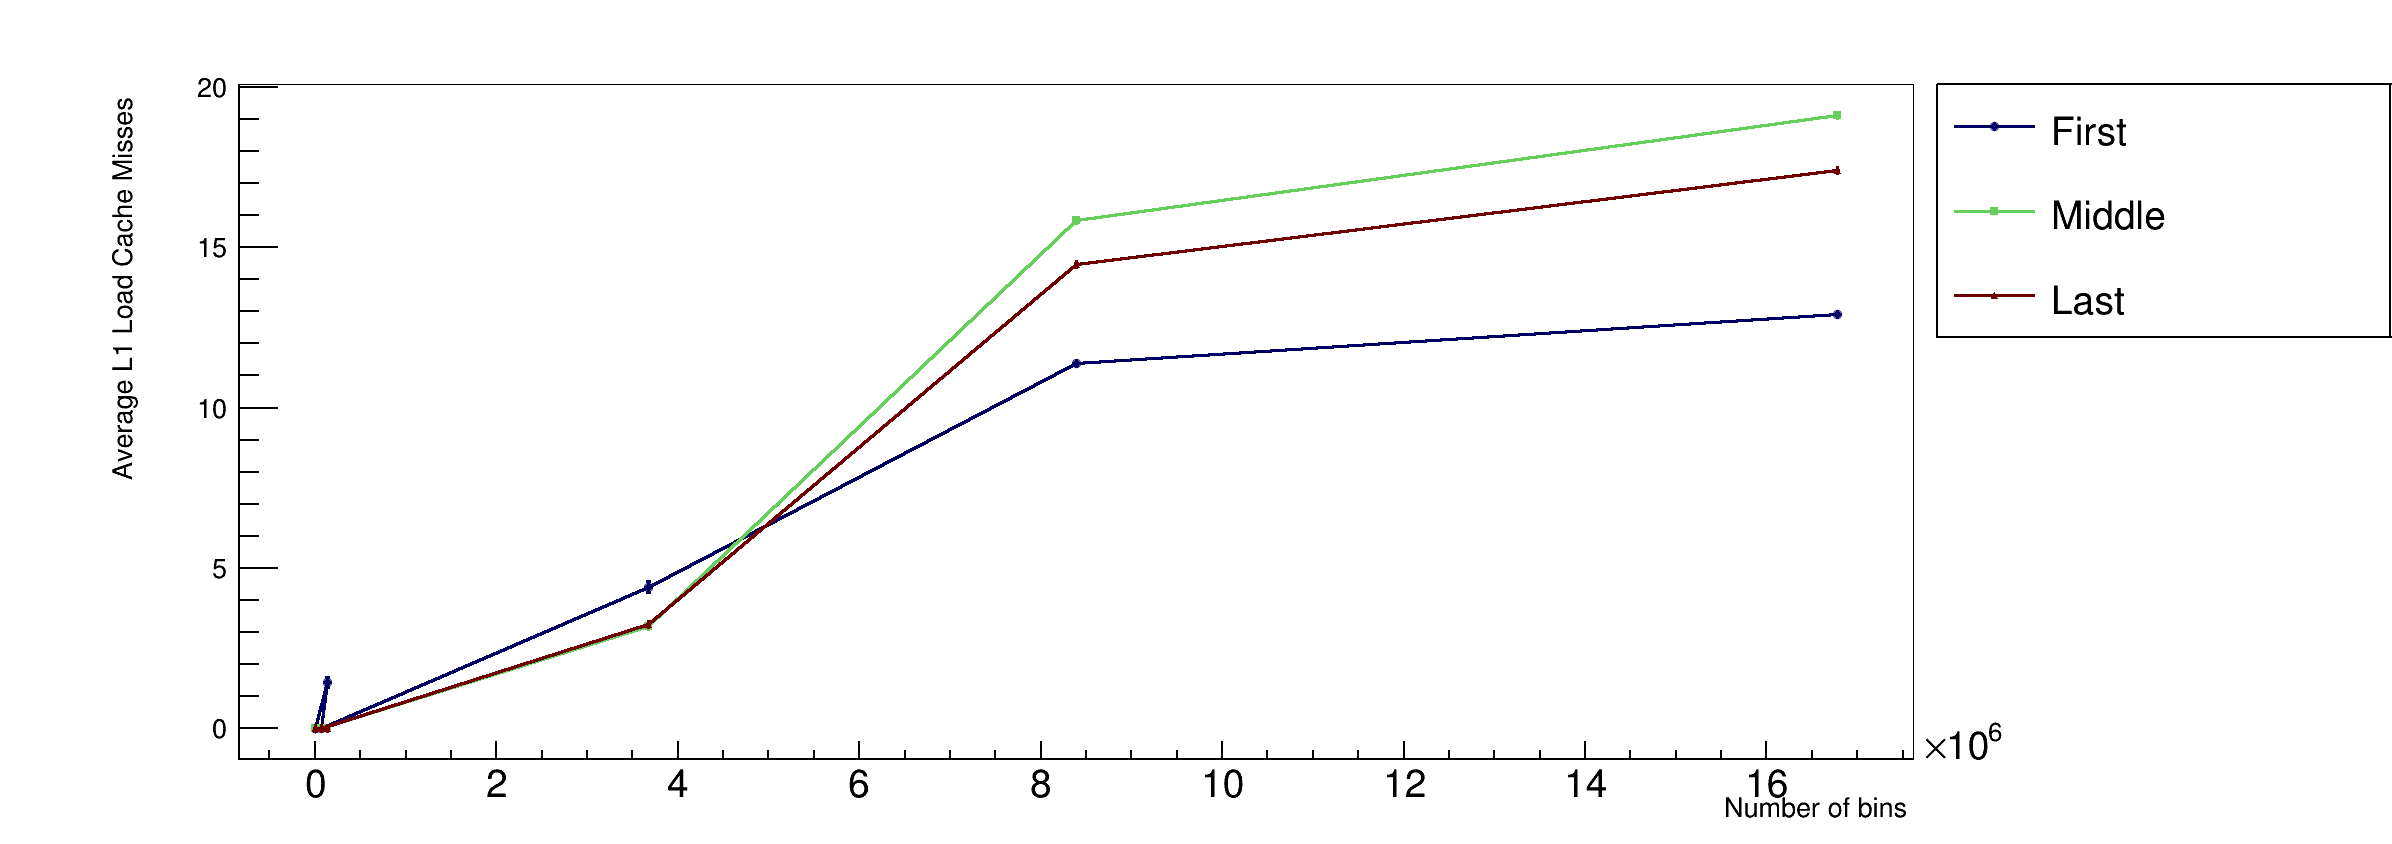

In [185]:
%jsroot off

selected_nbins = h12_df["nbins"].unique()
selected_bin = h12_df["bin"].unique()
norm = 50e6

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
# l.SetHeader("Input type")
# header = l.GetListOfPrimitives().First();
# header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for (nbi, dis), lbl in zip(enumerate(selected_bin), ["First", "Middle", "Last"]):
    g = ROOT.TGraphErrors(len(selected_nbins), selected_nbins, 
                          h12_df[h12_df["bin"] == dis]["mean_l1"].values/norm,
                          ROOT.kNone,
                          h12_df[h12_df["bin"] == dis]["std_l1"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(lbl).title())      

mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of bins")
# xaxis.SetRangeUser(1, 10000000);
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average L1 Load Cache Misses")
# yaxis.SetTitle("Total time (s)")columnscolumnscolumnscolumns

l.Draw()      
# c.SaveAs("../../images/mb_findbin_nbins_vs_bin.pdf")
c.DrawClone()

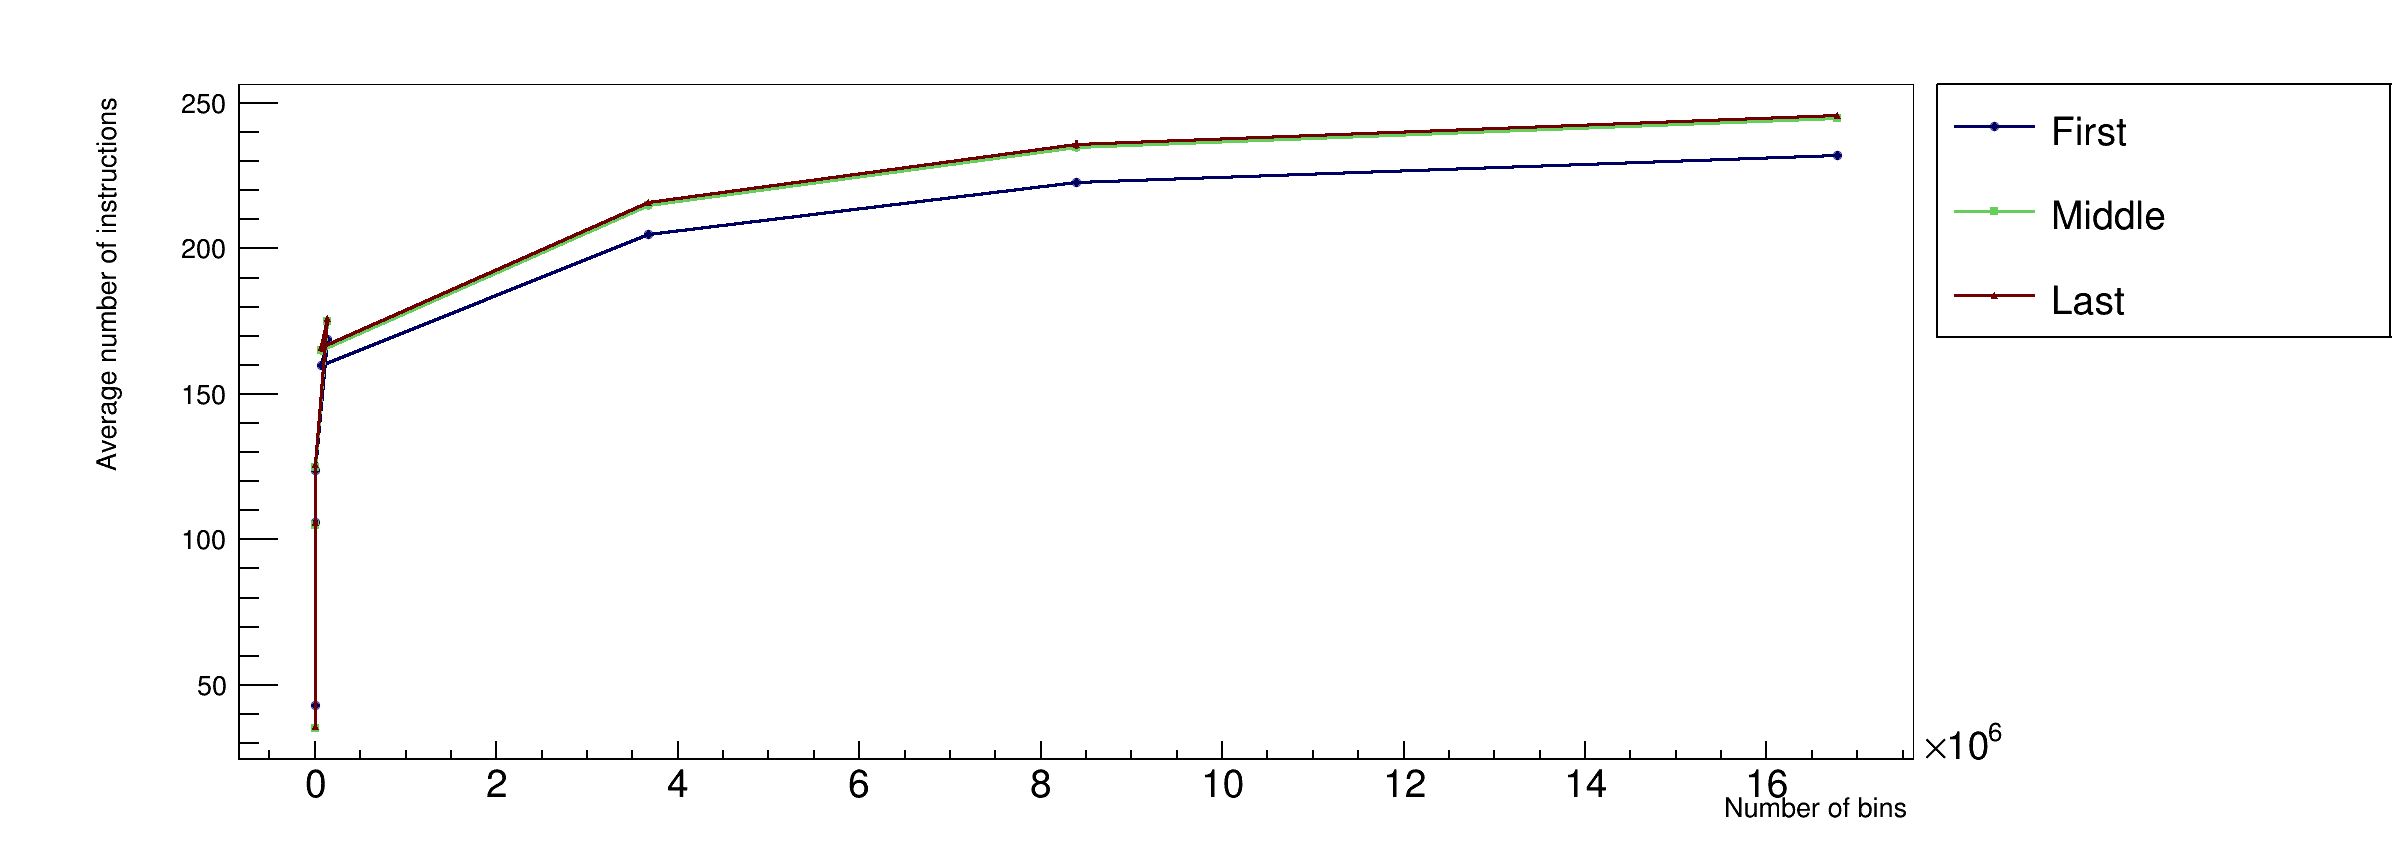

In [186]:
%jsroot off

selected_nbins = h12_df["nbins"].unique()
selected_bin = h12_df["bin"].unique()
norm = 50e6

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
# l.SetHeader("Input type")
# header = l.GetListOfPrimitives().First();
# header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for (nbi, dis), lbl in zip(enumerate(selected_bin), ["First", "Middle", "Last"]):
    g = ROOT.TGraphErrors(len(selected_nbins), selected_nbins, 
                          h12_df[h12_df["bin"] == dis]["mean_instr"].values/norm,
                          ROOT.kNone,
                          h12_df[h12_df["bin"] == dis]["std_instr"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(lbl).title())      

mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of bins")
# xaxis.SetRangeUser(1, 10000000);
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average number of instructions")
# yaxis.SetTitle("Total time (s)")columnscolumnscolumnscolumns

l.Draw()      
# c.SaveAs("../../images/mb_findbin_nbins_vs_bin.pdf")
c.DrawClone()

In [187]:
h3_df = df[df["func_name"] == "BinarySearchH3"].copy()
h3_df["nbins"] = h3_df["run_name"].apply(lambda s: float(s.split("/")[1]))
h3_df["nvals"] = h3_df["run_name"].apply(lambda s: float(s.split("/")[2])*1e6)
h3_df

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,...,instructions,func_name,mean_time,std_time,mean_l1,std_l1,mean_instr,std_instr,nbins,nvals
160,BM_BinarySearchH3/10/50_mean,1,0,BM_BinarySearchH3/10/50,aggregate,3,1,mean,time,3,...,2.200000e+09,BinarySearchH3,0.185747,0.002917,5.583333,1.154701,2.200000e+09,0.000000,10.0,5.000000e+07
164,BM_BinarySearchH3/1000/50_mean,1,1,BM_BinarySearchH3/1000/50,aggregate,3,1,mean,time,3,...,4.900001e+09,BinarySearchH3,0.442735,0.002206,9.000000,2.783882,4.900001e+09,110.851252,1000.0,5.000000e+07
168,BM_BinarySearchH3/100000/50_mean,1,2,BM_BinarySearchH3/100000/50,aggregate,3,1,mean,time,3,...,8.050001e+09,BinarySearchH3,0.628119,0.001884,46.333333,19.857828,8.050001e+09,110.851252,100000.0,5.000000e+07
172,BM_BinarySearchH3/10000000/50_mean,1,3,BM_BinarySearchH3/10000000/50,aggregate,3,1,mean,time,3,...,1.120000e+10,BinarySearchH3,0.875923,0.008149,266.333333,16.772994,1.120000e+10,221.702503,10000000.0,5.000000e+07
176,BM_BinarySearchH3/10/100_mean,1,4,BM_BinarySearchH3/10/100,aggregate,3,1,mean,time,3,...,4.400001e+09,BinarySearchH3,0.365720,0.004479,7.500000,3.968627,4.400001e+09,0.000000,10.0,1.000000e+08
180,BM_BinarySearchH3/1000/100_mean,1,5,BM_BinarySearchH3/1000/100,aggregate,3,1,mean,time,3,...,9.800001e+09,BinarySearchH3,0.891640,0.002471,22.000000,12.529964,9.800001e+09,0.000000,1000.0,1.000000e+08
184,BM_BinarySearchH3/100000/100_mean,1,6,BM_BinarySearchH3/100000/100,aggregate,3,1,mean,time,3,...,1.610000e+10,BinarySearchH3,1.250345,0.009174,44.000000,7.549834,1.610000e+10,221.702503,100000.0,1.000000e+08
188,BM_BinarySearchH3/10000000/100_mean,1,7,BM_BinarySearchH3/10000000/100,aggregate,3,1,mean,time,3,...,2.240000e+10,BinarySearchH3,1.738369,0.003065,323.666667,115.517675,2.240000e+10,443.405007,10000000.0,1.000000e+08
192,BM_BinarySearchH3/10/500_mean,1,8,BM_BinarySearchH3/10/500,aggregate,3,1,mean,time,3,...,2.200000e+10,BinarySearchH3,1.825356,0.020136,32.000000,4.000000,2.200000e+10,0.000000,10.0,5.000000e+08
196,BM_BinarySearchH3/1000/500_mean,1,9,BM_BinarySearchH3/1000/500,aggregate,3,1,mean,time,3,...,4.900000e+10,BinarySearchH3,4.444036,0.011216,37.666667,21.548395,4.900000e+10,0.000000,1000.0,5.000000e+08


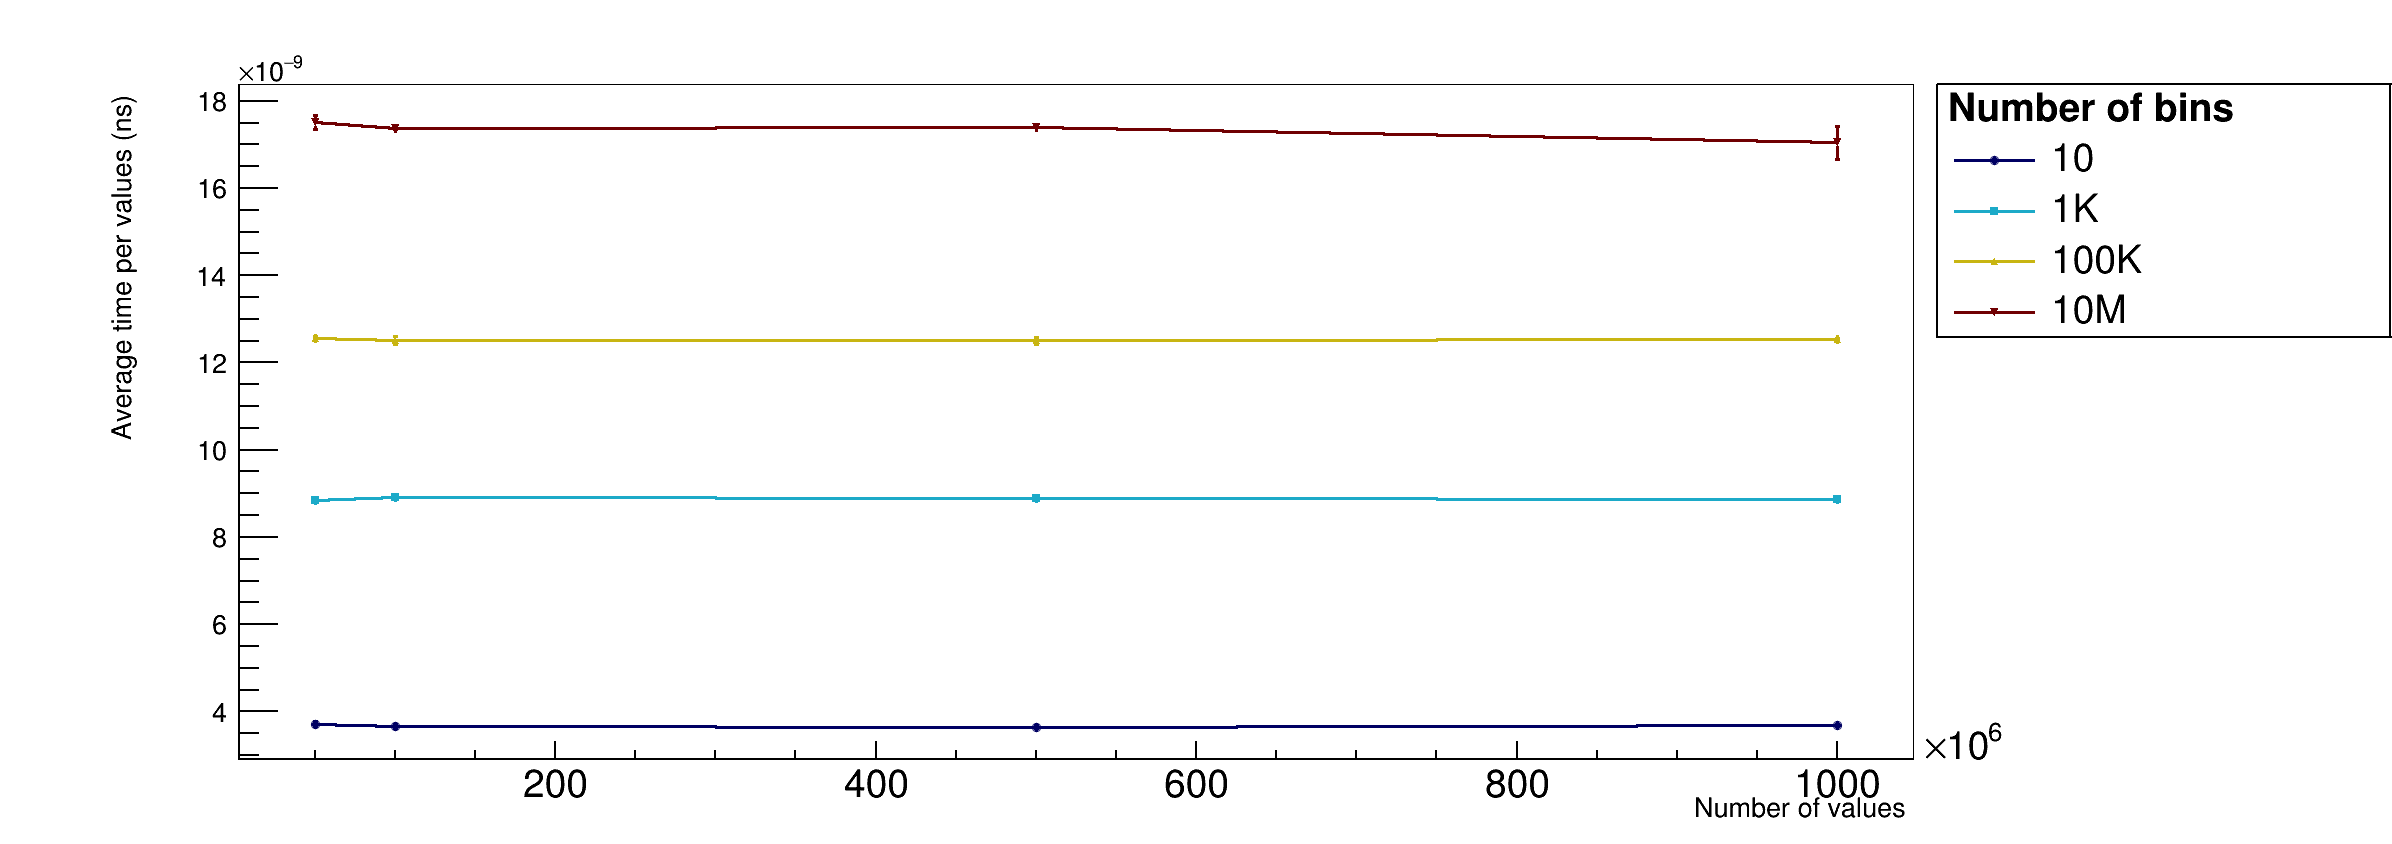

In [188]:
%jsroot off

selected_nbins = h3_df["nbins"].unique()
selected_nvals = h3_df["nvals"].unique()
norm = selected_nvals

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
l.SetHeader("#bf{Number of bins}")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for nbi, nb in enumerate(selected_nbins):
    g = ROOT.TGraphErrors(len(selected_nvals), selected_nvals, 
                          h3_df[h3_df["nbins"] == nb]["mean_time"].values/norm,
                          ROOT.kNone,
                          h3_df[h3_df["nbins"] == nb]["std_time"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, human_readable(nb))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of values")
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")

l.Draw()
# c.SaveAs("../../images/mb_findbin_nvals_vs_nbins.pdf")
c.DrawClone()

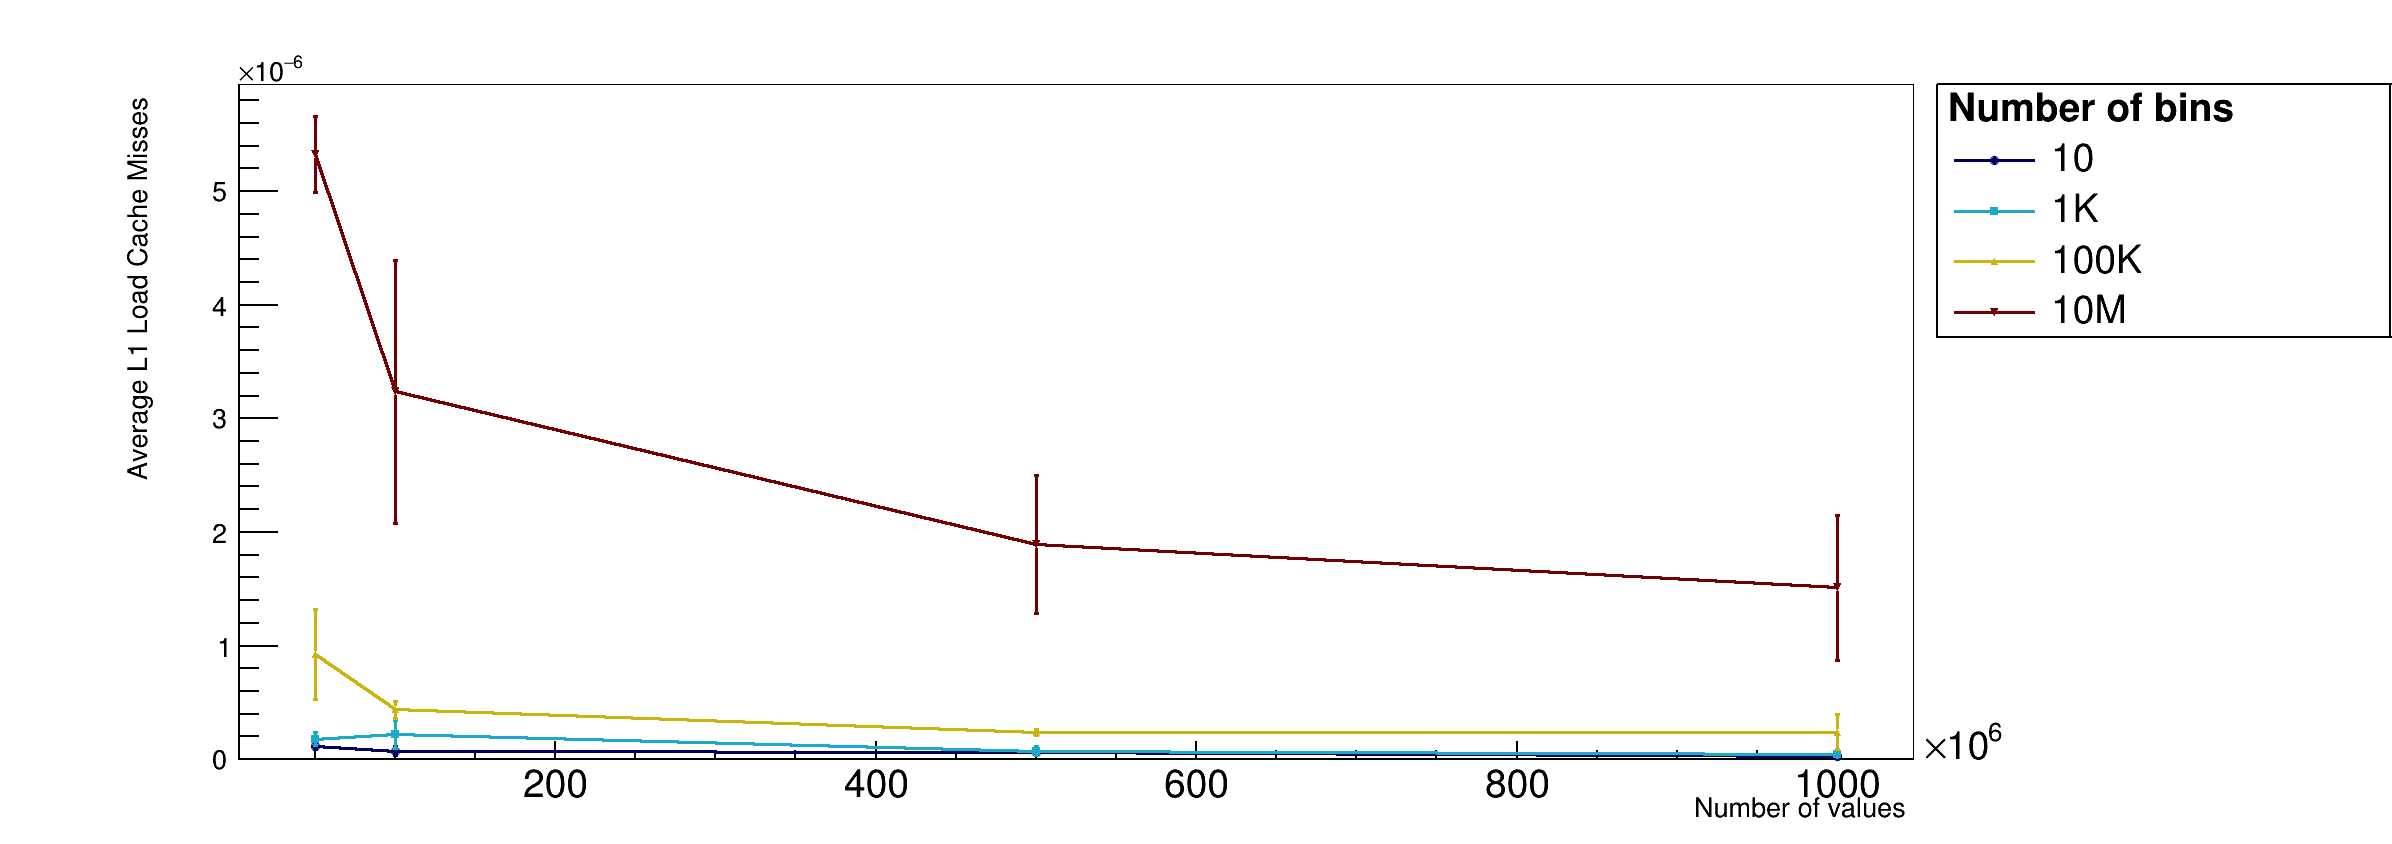

In [189]:
%jsroot off

selected_nbins = h3_df["nbins"].unique()
selected_nvals = h3_df["nvals"].unique()
norm = selected_nvals

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
l.SetHeader("#bf{Number of bins}")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for nbi, nb in enumerate(selected_nbins):
    g = ROOT.TGraphErrors(len(selected_nvals), selected_nvals, 
                          h3_df[h3_df["nbins"] == nb]["mean_l1"].values/norm,
                          ROOT.kNone,
                          h3_df[h3_df["nbins"] == nb]["std_l1"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, human_readable(nb))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of values")
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average L1 Load Cache Misses")

l.Draw()
# c.SaveAs("../../images/mb_findbin_nvals_vs_nbins.pdf")
c.DrawClone()

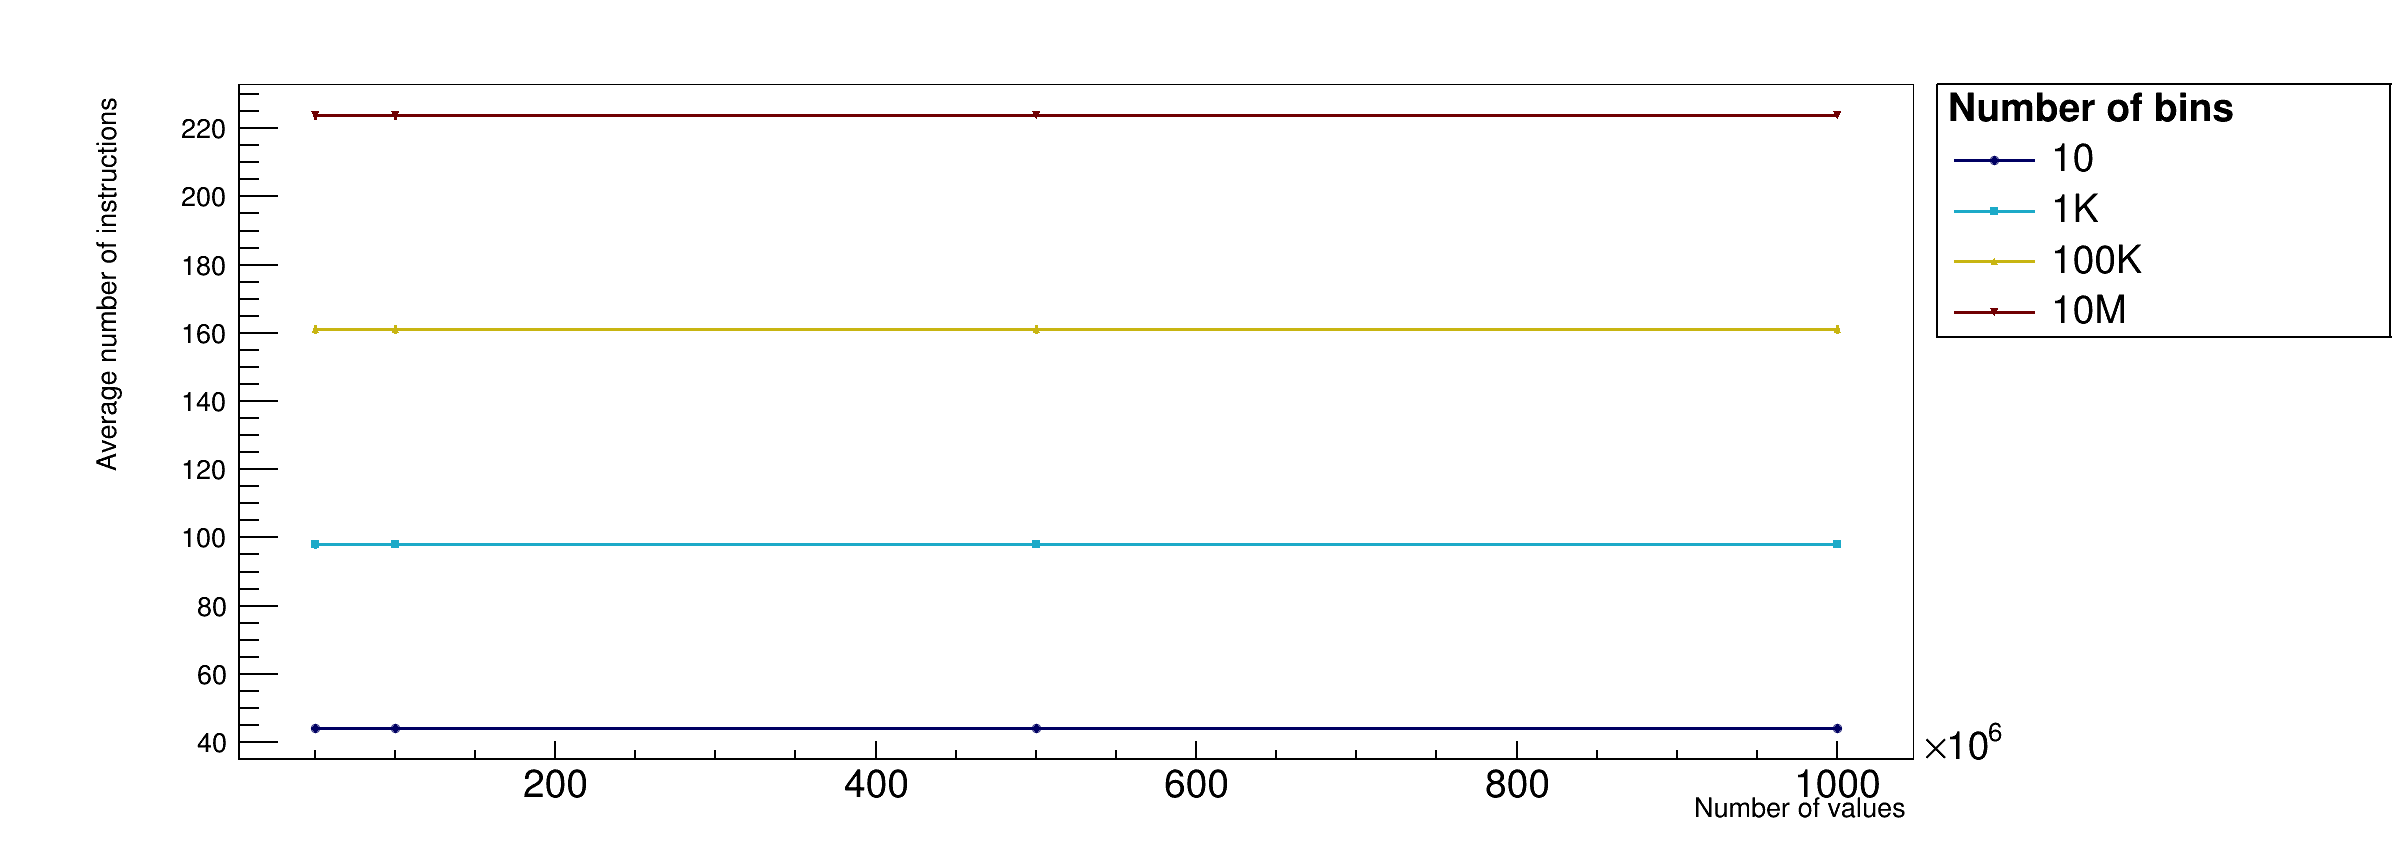

In [190]:
%jsroot off

selected_nbins = h3_df["nbins"].unique()
selected_nvals = h3_df["nvals"].unique()
norm = selected_nvals

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
l.SetHeader("#bf{Number of bins}")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for nbi, nb in enumerate(selected_nbins):
    g = ROOT.TGraphErrors(len(selected_nvals), selected_nvals, 
                          h3_df[h3_df["nbins"] == nb]["mean_instr"].values/norm,
                          ROOT.kNone,
                          h3_df[h3_df["nbins"] == nb]["std_instr"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, human_readable(nb))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of values")
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average number of instructions")

l.Draw()
# c.SaveAs("../../images/mb_findbin_nvals_vs_nbins.pdf")
c.DrawClone()

In [191]:
h4_df = df[df["func_name"] == "BinarySearchH4"].copy()
h4_df["nbins"] = h4_df["run_name"].apply(lambda s: float(s.split("/")[1]))
h4_df["range"] = h4_df["run_name"].apply(lambda s: float(s.split("/")[2])/4)
h4_df

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,...,instructions,func_name,mean_time,std_time,mean_l1,std_l1,mean_instr,std_instr,nbins,range
224,BM_BinarySearchH4/8/1_mean,2,0,BM_BinarySearchH4/8/1,aggregate,3,1,mean,time,3,...,2.500000e+09,BinarySearchH4,0.200502,0.002349,7.177778e+01,1.159609e+02,2.500000e+09,0.000000,8.0,0.25
228,BM_BinarySearchH4/1024/1_mean,2,1,BM_BinarySearchH4/1024/1,aggregate,3,1,mean,time,3,...,5.253113e+09,BinarySearchH4,0.640905,0.003388,5.500000e+01,2.364318e+01,5.253113e+09,0.000000,1024.0,0.25
232,BM_BinarySearchH4/131072/1_mean,2,2,BM_BinarySearchH4/131072/1,aggregate,3,1,mean,time,3,...,8.570077e+09,BinarySearchH4,2.515335,0.003013,3.369487e+07,1.417311e+06,8.570077e+09,0.000000,131072.0,0.25
236,BM_BinarySearchH4/16777216/1_mean,2,3,BM_BinarySearchH4/16777216/1,aggregate,3,1,mean,time,3,...,1.098069e+10,BinarySearchH4,6.342401,0.002877,9.477260e+08,2.899663e+05,1.098069e+10,0.000000,16777216.0,0.25
240,BM_BinarySearchH4/8/2_mean,2,4,BM_BinarySearchH4/8/2,aggregate,3,1,mean,time,3,...,2.225000e+09,BinarySearchH4,0.185915,0.000568,3.750000e+00,1.145644e+00,2.225000e+09,0.000000,8.0,0.50
244,BM_BinarySearchH4/1024/2_mean,2,5,BM_BinarySearchH4/1024/2,aggregate,3,1,mean,time,3,...,5.276452e+09,BinarySearchH4,0.692614,0.026143,9.300000e+01,5.501818e+01,5.276452e+09,78.383672,1024.0,0.50
248,BM_BinarySearchH4/131072/2_mean,2,6,BM_BinarySearchH4/131072/2,aggregate,3,1,mean,time,3,...,8.589419e+09,BinarySearchH4,2.507912,0.003362,3.542709e+07,9.203331e+05,8.589419e+09,0.000000,131072.0,0.50
252,BM_BinarySearchH4/16777216/2_mean,2,7,BM_BinarySearchH4/16777216/2,aggregate,3,1,mean,time,3,...,1.000342e+10,BinarySearchH4,5.779869,0.002454,8.557905e+08,2.047016e+05,1.000342e+10,0.000000,16777216.0,0.50
256,BM_BinarySearchH4/8/3_mean,2,8,BM_BinarySearchH4/8/3,aggregate,3,1,mean,time,3,...,2.141667e+09,BinarySearchH4,0.206190,0.001725,3.555556e+00,1.924501e-01,2.141667e+09,27.712813,8.0,0.75
260,BM_BinarySearchH4/1024/3_mean,2,9,BM_BinarySearchH4/1024/3,aggregate,3,1,mean,time,3,...,5.284298e+09,BinarySearchH4,1.262329,0.042886,6.976667e+02,2.715167e+02,5.284298e+09,78.383672,1024.0,0.75


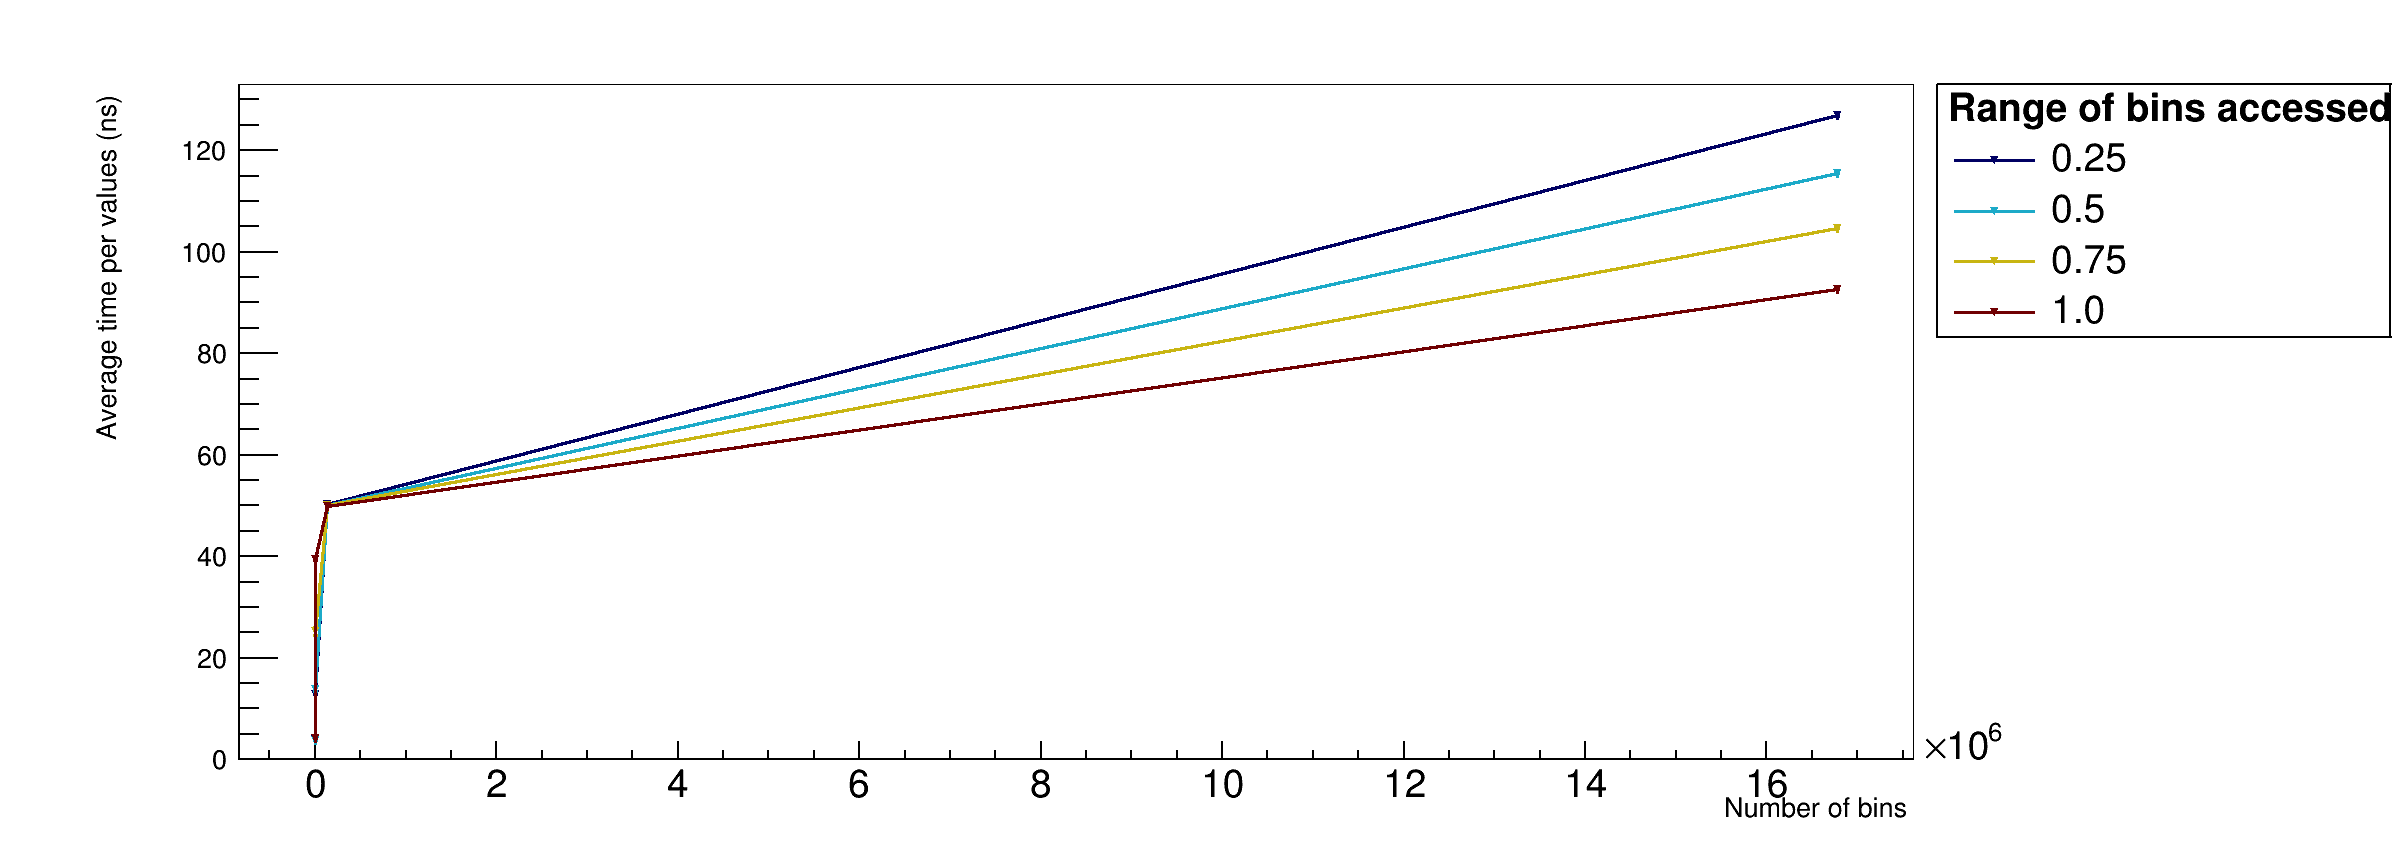

In [192]:
%jsroot off

selected_nbins = h4_df["nbins"].unique()
selected_range = h4_df["range"].unique()
norm = 50e6/1e9

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
l.SetHeader("#bf{Range of bins accessed}")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for ri, r in enumerate(selected_range):
    g = ROOT.TGraphErrors(len(selected_nbins), selected_nbins, 
                          h4_df[h4_df["range"] == r]["mean_time"].values/norm,
                          ROOT.kNone,
                          h4_df[h4_df["range"] == r]["std_time"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(r))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of bins")
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")

l.Draw()
# c.SaveAs("../../images/mb_findbin_nvals_vs_nbins.pdf")
c.DrawClone()

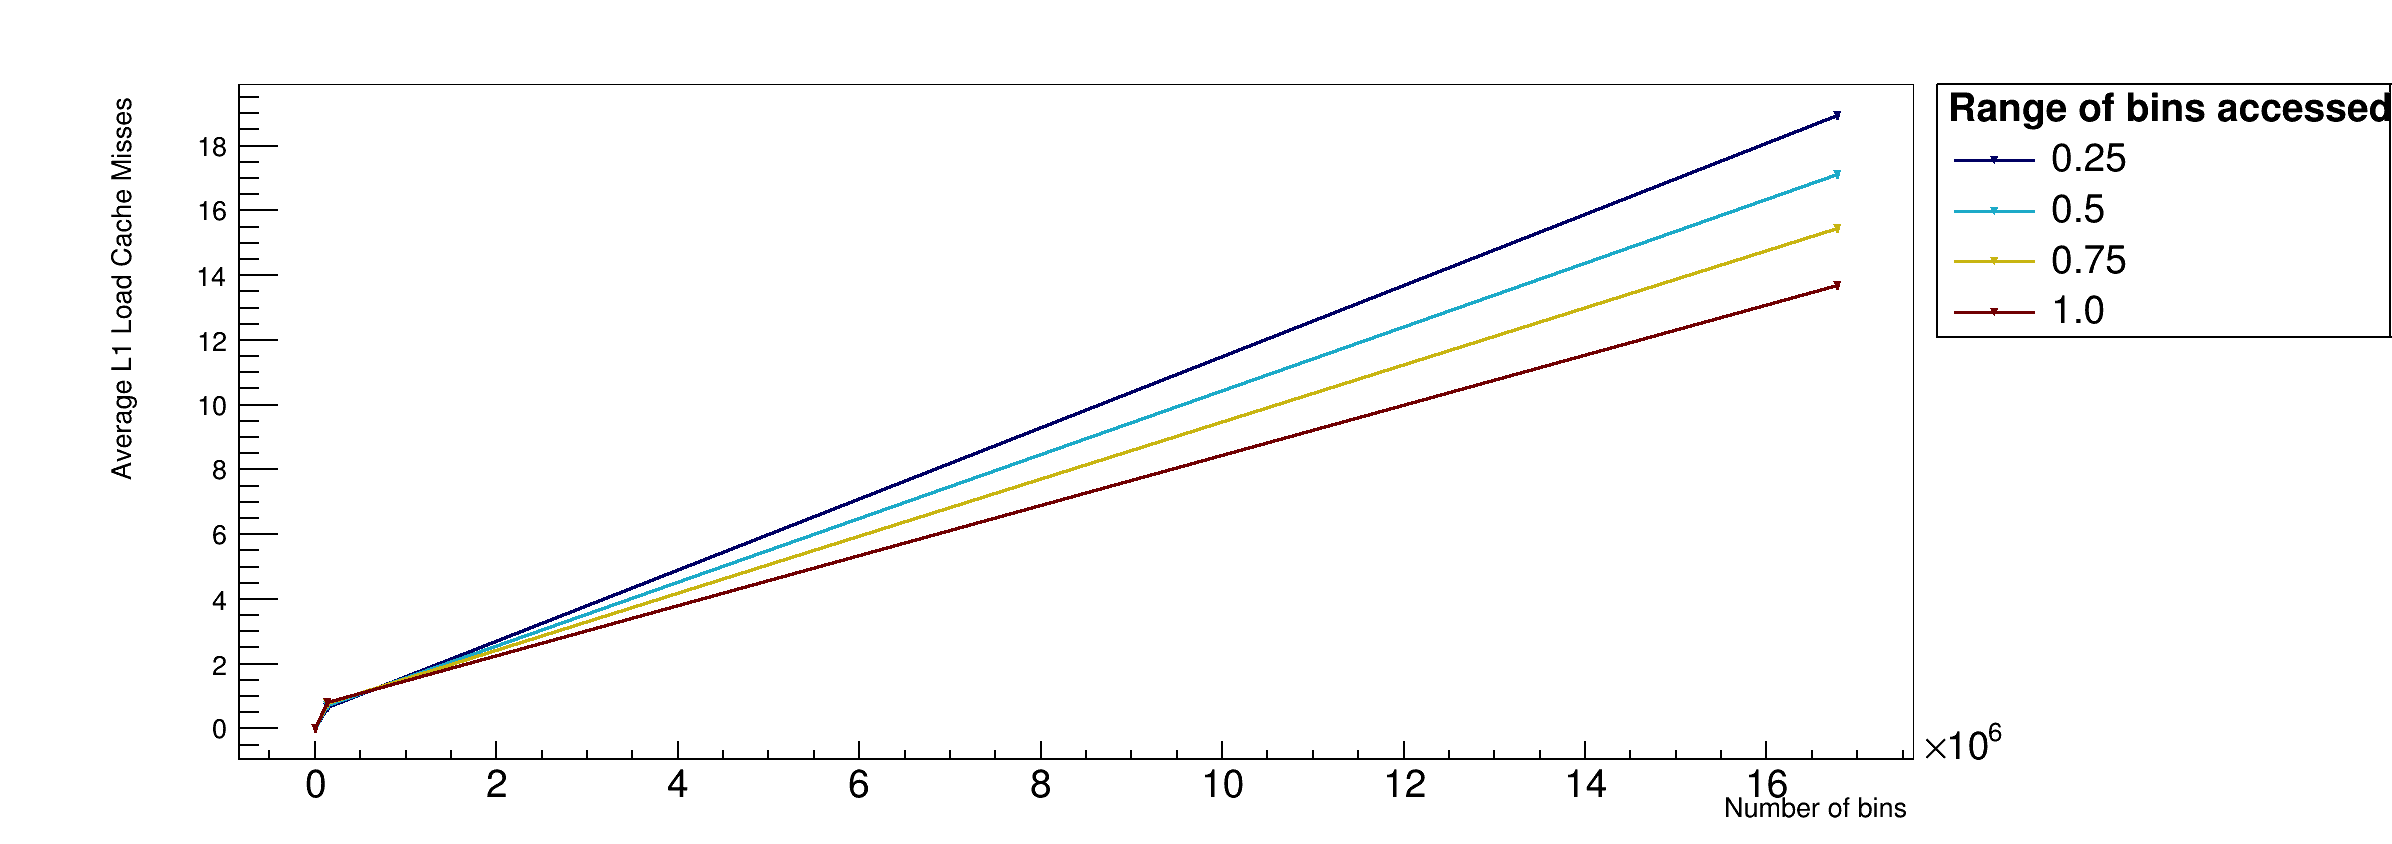

In [193]:
%jsroot off

selected_nbins = h4_df["nbins"].unique()
selected_range = h4_df["range"].unique()
norm = 50e6

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
l.SetHeader("#bf{Range of bins accessed}")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for ri, r in enumerate(selected_range):
    g = ROOT.TGraphErrors(len(selected_nbins), selected_nbins, 
                          h4_df[h4_df["range"] == r]["mean_l1"].values/norm,
                          ROOT.kNone,
                          h4_df[h4_df["range"] == r]["std_l1"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(r))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of bins")
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average L1 Load Cache Misses")

l.Draw()
# c.SaveAs("../../images/mb_findbin_nvals_vs_nbins.pdf")
c.DrawClone()

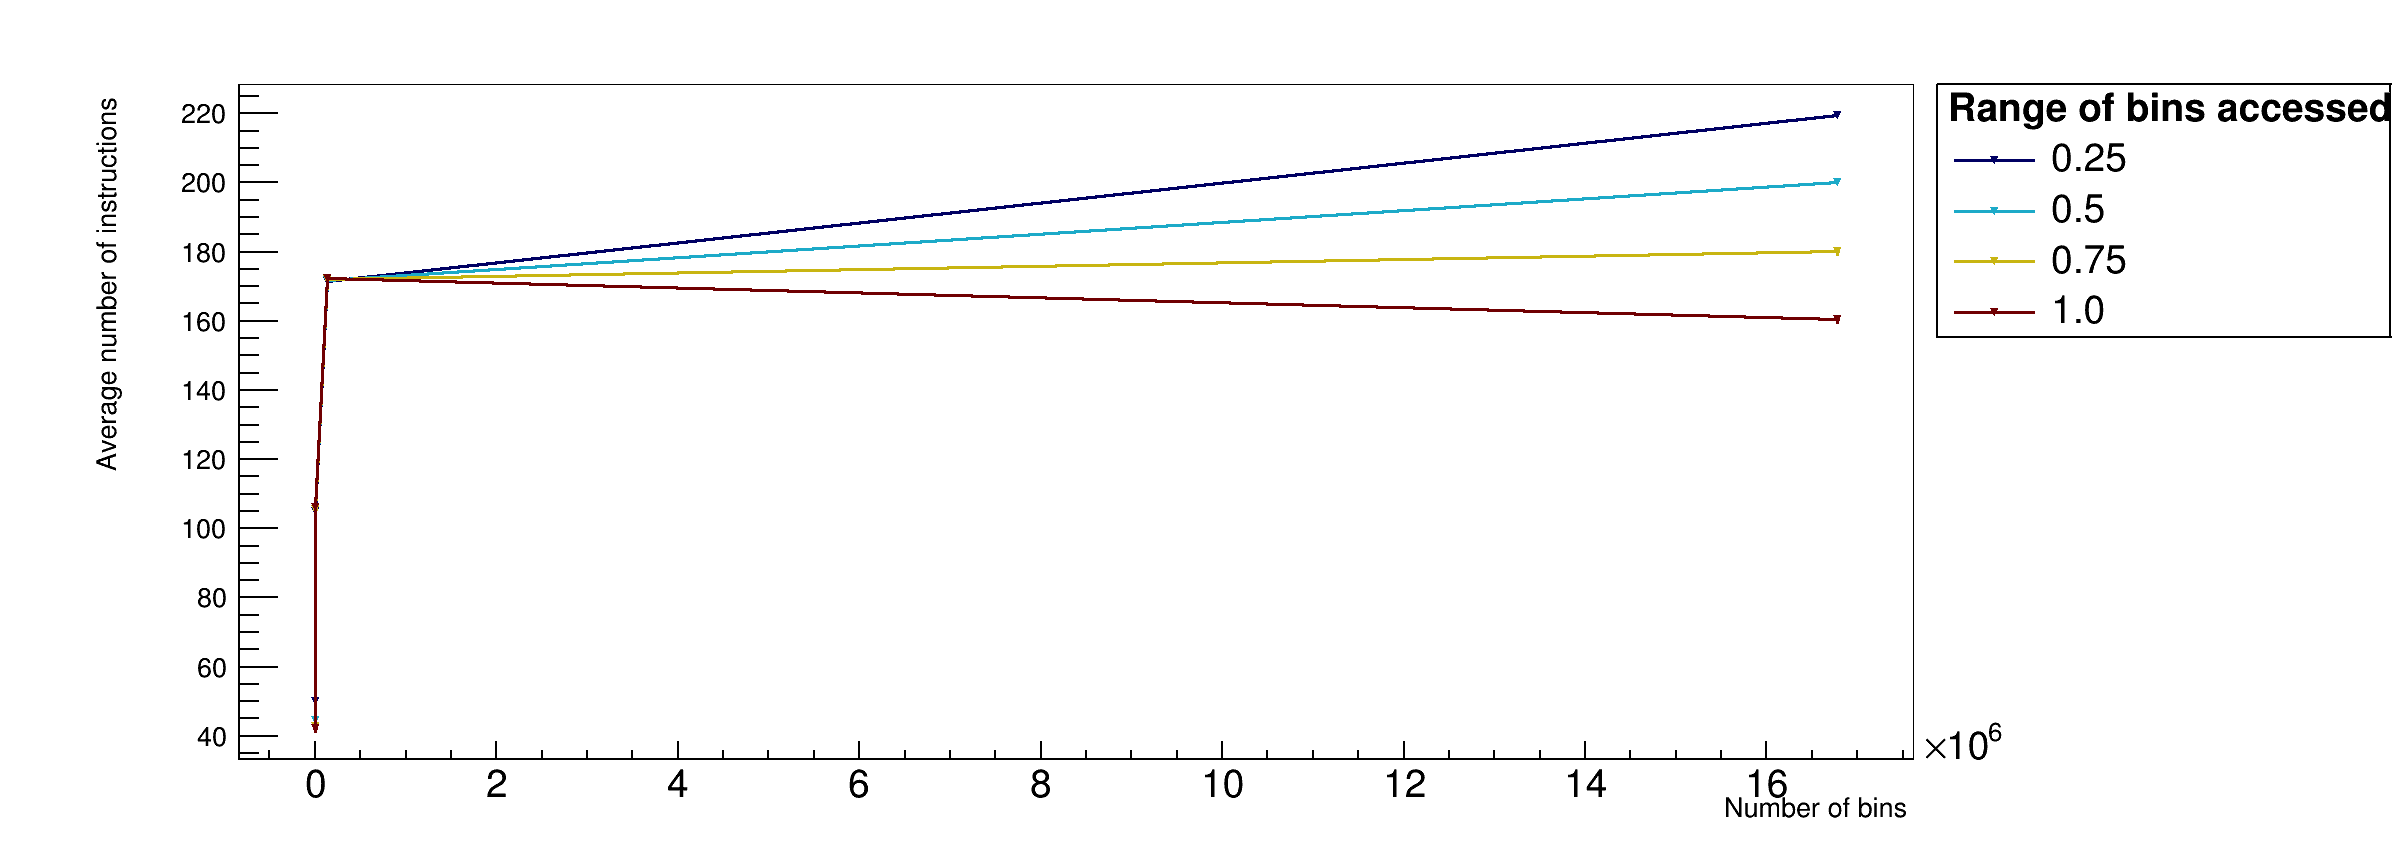

In [194]:
%jsroot off

selected_nbins = h4_df["nbins"].unique()
selected_range = h4_df["range"].unique()
norm = 50e6

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
l.SetHeader("#bf{Range of bins accessed}")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for ri, r in enumerate(selected_range):
    g = ROOT.TGraphErrors(len(selected_nbins), selected_nbins, 
                          h4_df[h4_df["range"] == r]["mean_instr"].values/norm,
                          ROOT.kNone,
                          h4_df[h4_df["range"] == r]["std_instr"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(r))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of bins")
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average number of instructions")

l.Draw()
# c.SaveAs("../../images/mb_findbin_nvals_vs_nbins.pdf")
c.DrawClone()

##### sequential 

In [195]:
filename = "binsearch.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})
df["param"] = df["name"].apply(lambda s: float(s.split("/")[1]))
# df["distance"] = df["param"].apply(lambda s: search_distance(np.linspace(0,1,1000), s))
df["func_name"] = df["name"].apply(lambda s: s.split("/")[0][3:])
bs_df = df[df["func_name"] == "BinarySearch"]
bs_df

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,cpu_time,time_unit,param,func_name
0,BM_BinarySearch/1/manual_time,0,0,BM_BinarySearch/1/manual_time,iteration,1,0,1,156,4.551525,4.546999,ms,1.0,BinarySearch
1,BM_BinarySearch/2/manual_time,0,1,BM_BinarySearch/2/manual_time,iteration,1,0,1,139,5.054828,5.054439,ms,2.0,BinarySearch
2,BM_BinarySearch/3/manual_time,0,2,BM_BinarySearch/3/manual_time,iteration,1,0,1,162,4.251436,4.246140,ms,3.0,BinarySearch
3,BM_BinarySearch/4/manual_time,0,3,BM_BinarySearch/4/manual_time,iteration,1,0,1,133,5.065160,5.059299,ms,4.0,BinarySearch
4,BM_BinarySearch/5/manual_time,0,4,BM_BinarySearch/5/manual_time,iteration,1,0,1,157,4.432735,4.422897,ms,5.0,BinarySearch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BM_BinarySearch/96/manual_time,0,95,BM_BinarySearch/96/manual_time,iteration,1,0,1,149,4.628474,4.628069,ms,96.0,BinarySearch
96,BM_BinarySearch/97/manual_time,0,96,BM_BinarySearch/97/manual_time,iteration,1,0,1,171,4.062870,4.062653,ms,97.0,BinarySearch
97,BM_BinarySearch/98/manual_time,0,97,BM_BinarySearch/98/manual_time,iteration,1,0,1,146,4.853625,4.853160,ms,98.0,BinarySearch
98,BM_BinarySearch/99/manual_time,0,98,BM_BinarySearch/99/manual_time,iteration,1,0,1,147,4.781845,4.781564,ms,99.0,BinarySearch


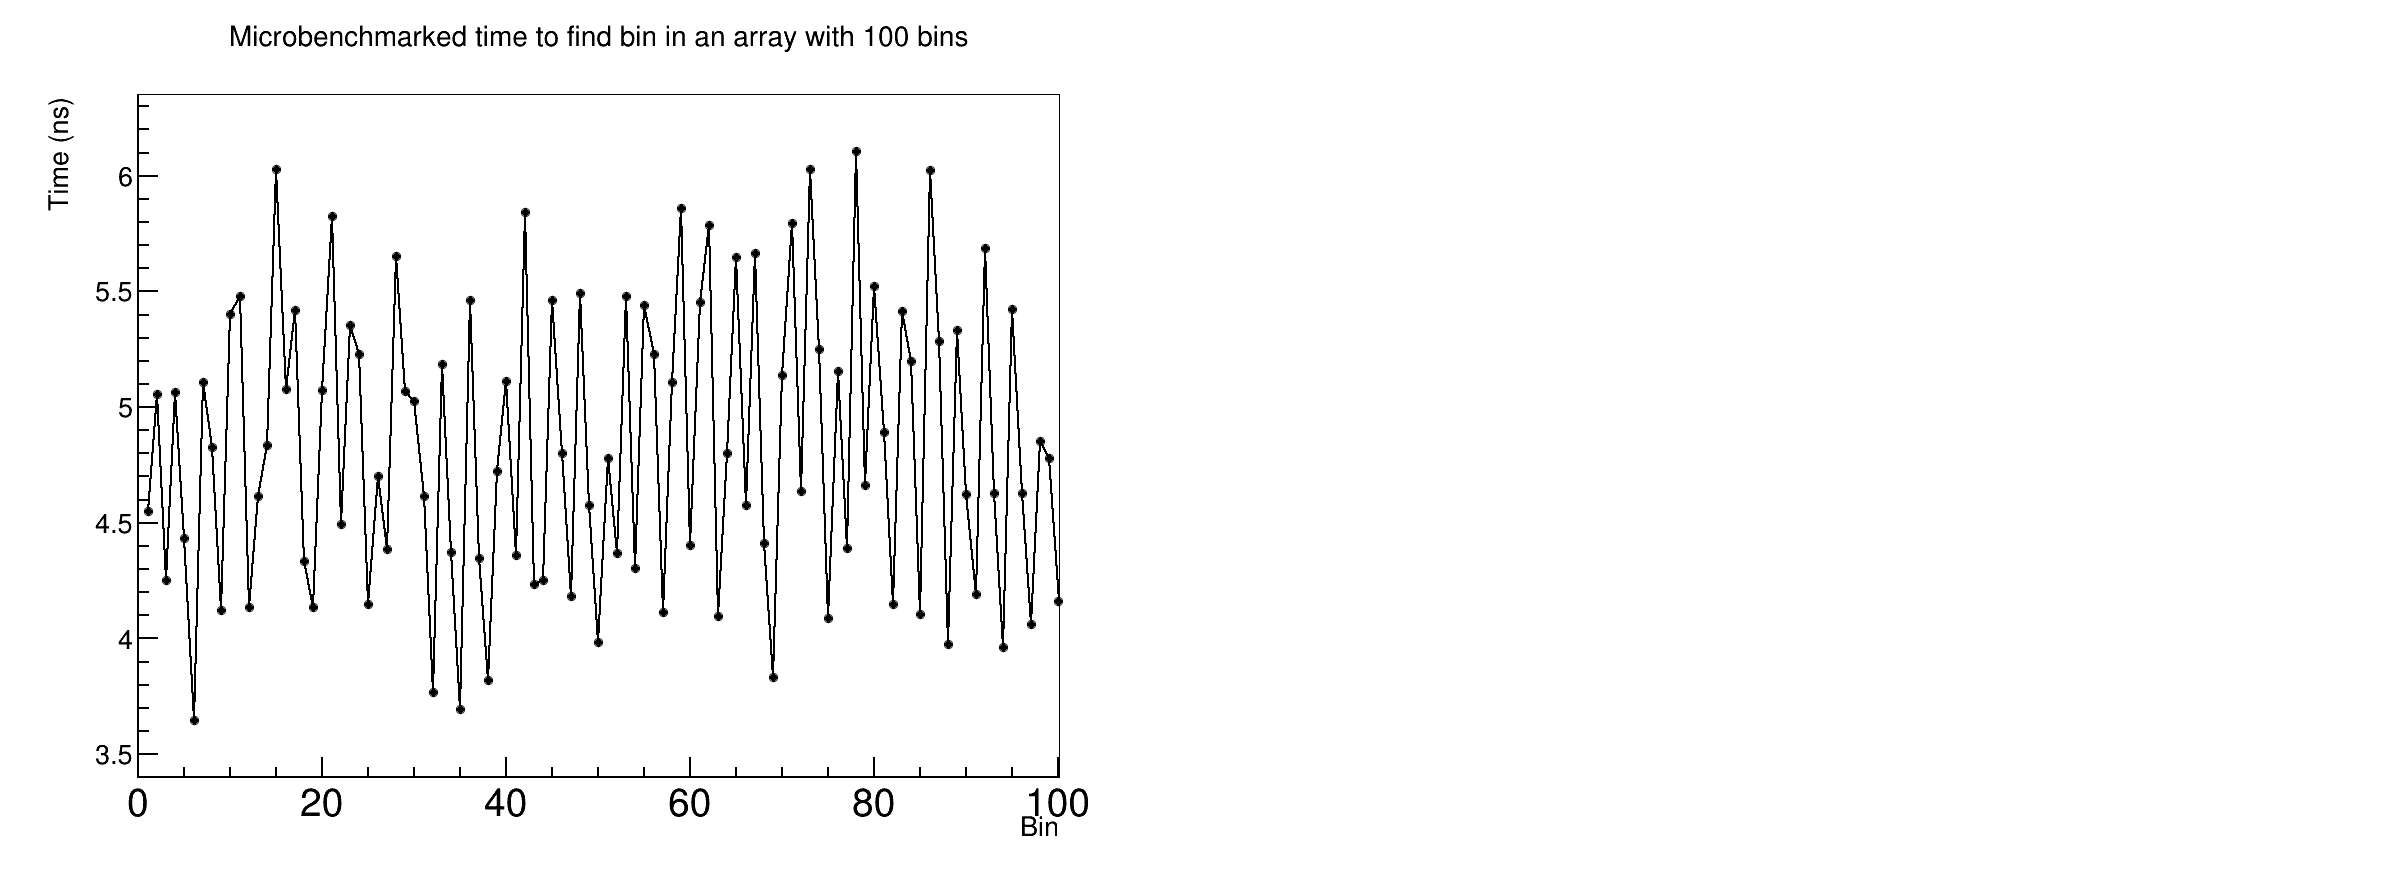

In [196]:
c = ROOT.TCanvas("c1", title)
c.SetRightMargin(0.32)
c.SetBottomMargin(0.33)
c.Divide(2,1)

l = ROOT.TLegend(0.7, 0.7, 0.96, 0.9)
l.SetTextSize(0.05)

g = ROOT.TGraph(len(bs_df["param"]), bs_df["param"].values, bs_df["real_time"].values)
g.SetMarkerSize(1)
g.SetMarkerStyle(8)
l.AddEntry(g, "Microbenchmark", "p")
xaxis = g.GetXaxis()
xaxis.SetTitle("Bin")
yaxis = g.GetYaxis()
yaxis.SetTitle(f"Time (ns)")
xaxis.SetRangeUser(0, 100)

c.cd(1)
g.Draw("ALP")

title="Microbenchmarked time to find bin in an array with 100 bins"
g.SetTitle(title)

# l.Draw()
c.Draw()
# ROOT.gPad.Modified(); ROOT.gPad.Update()

##### Uniform random

In [197]:
bs_df = df[df["func_name"] == "BinarySearch"]
bs_df

,name,family_index,per_family_instance_index,run_name,run_type,repetitions,repetition_index,threads,iterations,real_time,cpu_time,time_unit,param,func_name
0,BM_BinarySearch/1/manual_time,0,0,BM_BinarySearch/1/manual_time,iteration,1,0,1,156,4.551525,4.546999,ms,1.0,BinarySearch
1,BM_BinarySearch/2/manual_time,0,1,BM_BinarySearch/2/manual_time,iteration,1,0,1,139,5.054828,5.054439,ms,2.0,BinarySearch
2,BM_BinarySearch/3/manual_time,0,2,BM_BinarySearch/3/manual_time,iteration,1,0,1,162,4.251436,4.246140,ms,3.0,BinarySearch
3,BM_BinarySearch/4/manual_time,0,3,BM_BinarySearch/4/manual_time,iteration,1,0,1,133,5.065160,5.059299,ms,4.0,BinarySearch
4,BM_BinarySearch/5/manual_time,0,4,BM_BinarySearch/5/manual_time,iteration,1,0,1,157,4.432735,4.422897,ms,5.0,BinarySearch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BM_BinarySearch/96/manual_time,0,95,BM_BinarySearch/96/manual_time,iteration,1,0,1,149,4.628474,4.628069,ms,96.0,BinarySearch
96,BM_BinarySearch/97/manual_time,0,96,BM_BinarySearch/97/manual_time,iteration,1,0,1,171,4.062870,4.062653,ms,97.0,BinarySearch
97,BM_BinarySearch/98/manual_time,0,97,BM_BinarySearch/98/manual_time,iteration,1,0,1,146,4.853625,4.853160,ms,98.0,BinarySearch
98,BM_BinarySearch/99/manual_time,0,98,BM_BinarySearch/99/manual_time,iteration,1,0,1,147,4.781845,4.781564,ms,99.0,BinarySearch


****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =       38.745
NDf                       =           98
Edm                       =  1.82934e-21
NCalls                    =           33
p0                        =    0.0356546   +/-   0.0471987   
p1                        =      4.64629   +/-   0.255539    
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      38.7469
NDf                       =           97
Edm                       =  2.72258e-07
NCalls                    =           78
p0                        =      2.32579   +/-   0.796017    
p1                        =    0.0206362   +/-   0.0268882   
p2                        =      2.32583   +/-   0.799898    


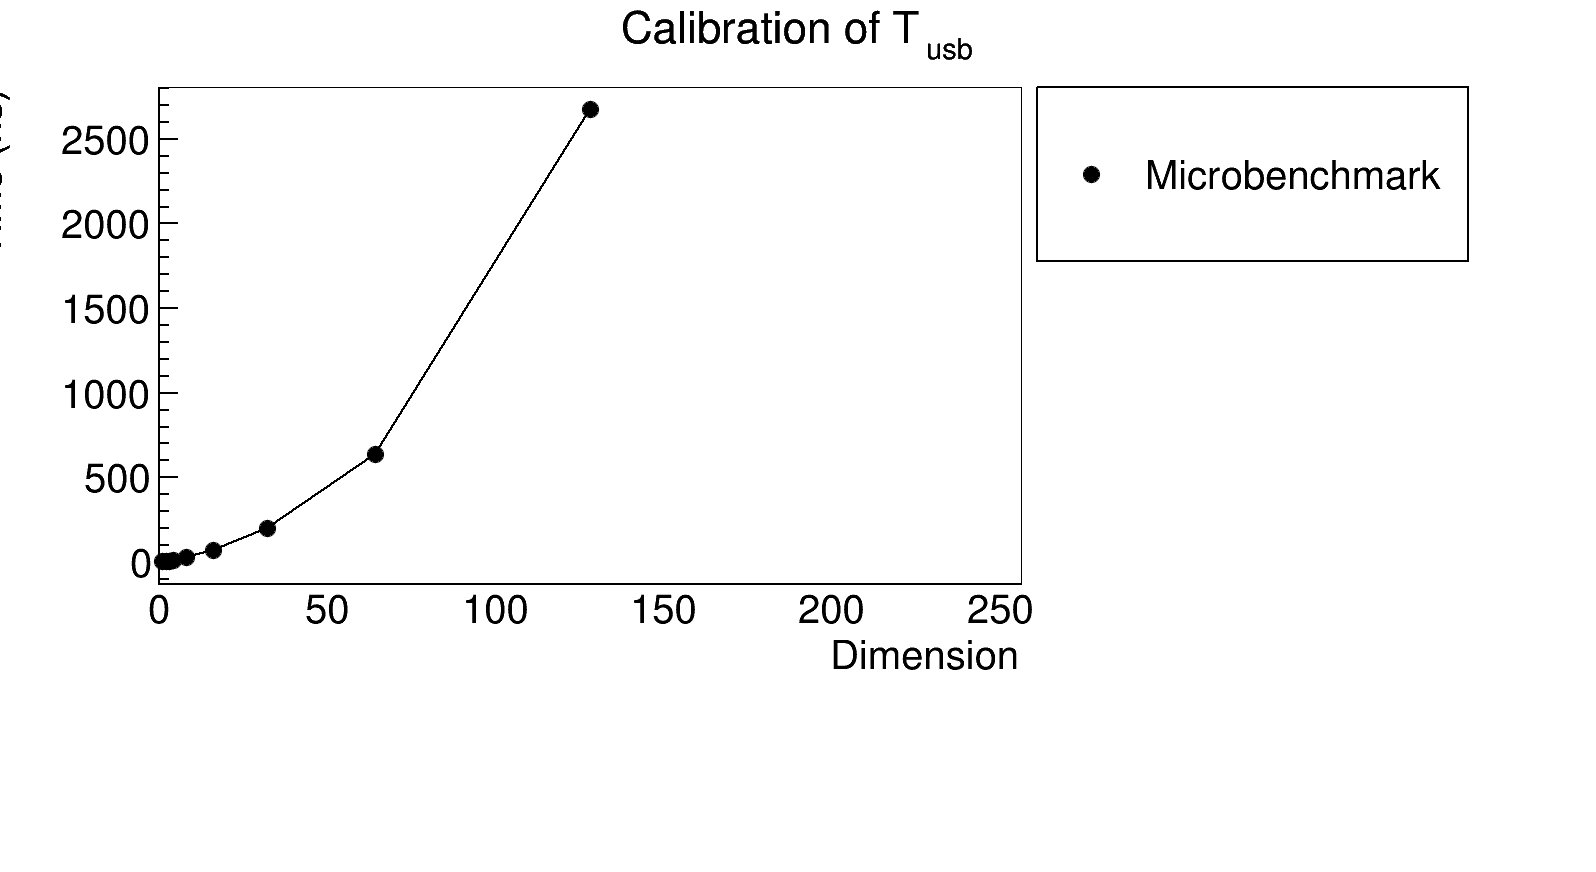

In [198]:
%jsroot off
def f_bs_log(x, p):
    """
    Binary Search
    """
    return p[0] * np.log2(x[0]) +  p[1]

def f_bs_polynomial(x, p):
    """
    Binary Search
    """
    return p[0] * x[0]**(p[1]) + p[2]

title="Model Update Stats Bulk"
w = 1600
h = 900
c = ROOT.TCanvas("c1", title, w, h)
c.SetRightMargin(0.32)
c.SetBottomMargin(0.33)

l = ROOT.TLegend(0.7, 0.7, 0.96, 0.9)
l.SetTextSize(0.05)

model_bs_log = ROOT.TF1("f_bs_log", f_bs_log, bs_df["param"].min(), bs_df["param"].max(), 2)
fit_log = g.Fit(model_bs_log, "", "", 10e-3, 40e4)
l.AddEntry(model_bs_log, "Logarithmic Fit")

model_bs_poly = ROOT.TF1("f_bs_polynomial", f_bs_polynomial, bs_df["param"].min(), bs_df["param"].max(), 3)
fit_poly = g.Fit(model_bs_poly, "", "", 10e-3, 40e4)
l.AddEntry(model_bs_poly, "Polynomial Fit")
model_bs_poly.SetLineColor(ROOT.kBlue)

g = ROOT.TGraph(len(bs_df["param"]), bs_df["param"].values, bs_df["real_time"].values)
g.SetMarkerSize(1)
g.SetMarkerStyle(8)
l.AddEntry(g, "Microbenchmark", "p")

xaxis = model_bs_log.GetXaxis()
xaxis.SetTitle("Number of bins")
# xaxis.SetTitleOffset(3)
xaxis.SetTitleSize(0.05)
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.05)
xaxis.LabelsOption("vM")
xaxis.SetRangeUser(0, 5*10e3)

yaxis = model_bs_log.GetYaxis()
yaxis.SetTitle(f"Time ({list(bs_df['time_unit'])[0]}")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
# yaxis.SetRangeUser(0, 0.4)


model_bs_log.Draw("C")
model_bs_poly.Draw("CSAME")
g.Draw("PSAME")

title="Calibration of T_{bs}"
model_bs_log.SetTitle(title)

l.Draw()
c.Draw()
# ROOT.gPad.Modified(); ROOT.gPad.Update()

##### Search Single Bin

In [199]:
cbm_df = bm_df.loc[bm_df["name"].str.contains("BinarySearch")].copy()
cbm_df["nbytes"] = bm_df["nbins"] * 8
n_param = len(cbm_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        cbm_df[f"param_{i}"] = cbm_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0])
    else:
        cbm_df[f"param_{i}"] = cbm_df["name"].apply(lambda s: s.split("/")[i+1])
        
cbm_mean = cbm_df.loc[cbm_df["name"].str.contains("mean")]
cbm_std = cbm_df.loc[cbm_df["name"].str.contains("stddev")]
cbm_mean

,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,cpu_time,...,cache-misses,cache-references,bin,nbins,val,func_name,time_factor,nbytes,param_0,param_1
192,BM_BinarySearch/8/0_mean,BM_BinarySearch/8/0,aggregate,1000000.0,1,mean,time,3,1.797291,1.795732,...,0.063248,4.224786e+00,0.0,1.0,0.0,BinarySearch,1000.0,8.0,8,0
196,BM_BinarySearch/16/0_mean,BM_BinarySearch/16/0,aggregate,1000000.0,1,mean,time,3,2.918470,2.916118,...,0.039548,6.918079e+00,0.0,2.0,0.0,BinarySearch,1000.0,16.0,16,0
200,BM_BinarySearch/32/0_mean,BM_BinarySearch/32/0,aggregate,1000000.0,1,mean,time,3,3.888519,3.885132,...,0.178637,9.327808e+00,0.0,4.0,0.0,BinarySearch,1000.0,32.0,32,0
204,BM_BinarySearch/64/0_mean,BM_BinarySearch/64/0,aggregate,1000000.0,1,mean,time,3,4.996738,4.992413,...,0.135714,1.168095e+01,0.0,8.0,0.0,BinarySearch,1000.0,64.0,64,0
208,BM_BinarySearch/128/0_mean,BM_BinarySearch/128/0,aggregate,1000000.0,1,mean,time,3,6.460564,6.455274,...,0.058104,1.735168e+01,0.0,16.0,0.0,BinarySearch,1000.0,128.0,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,BM_BinarySearch/16777216/4_mean,BM_BinarySearch/16777216/4,aggregate,1000000.0,1,mean,time,3,24.861609,24.840195,...,125.702381,6.255425e+06,2097151.0,2097152.0,2097152.0,BinarySearch,1000.0,16777216.0,16777216,4
696,BM_BinarySearch/33554432/4_mean,BM_BinarySearch/33554432/4,aggregate,1000000.0,1,mean,time,3,30.015691,29.989179,...,2.898551,8.812560e+06,4194303.0,4194304.0,4194304.0,BinarySearch,1000.0,33554432.0,33554432,4
700,BM_BinarySearch/67108864/4_mean,BM_BinarySearch/67108864/4,aggregate,1000000.0,1,mean,time,3,32.638812,32.609587,...,7.857143,1.097411e+07,8388607.0,8388608.0,8388608.0,BinarySearch,1000.0,67108864.0,67108864,4
704,BM_BinarySearch/134217728/4_mean,BM_BinarySearch/134217728/4,aggregate,1000000.0,1,mean,time,3,37.470503,37.440286,...,5.216667,1.242973e+07,16777215.0,16777216.0,16777216.0,BinarySearch,1000.0,134217728.0,134217728,4


/home/jollychen/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


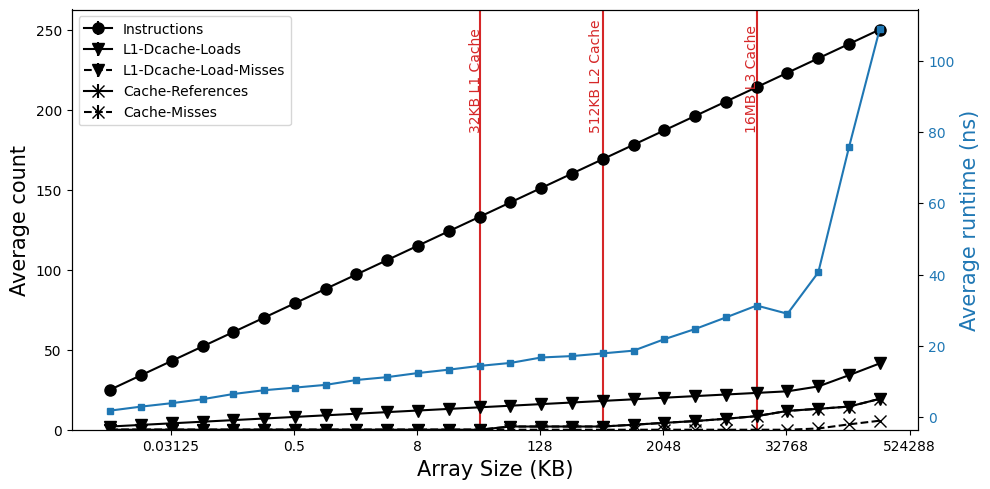

In [200]:
### ROOT Plot
selected_val = "0"

avg_cdf = cbm_mean.loc[cbm_mean["param_1"] == selected_val]
std_cdf = cbm_std.loc[cbm_std["param_1"] == selected_val]

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
norm = 1e3

for ev, clr, mrkr in [
           ["INSTRUCTIONS", "k", "o"],
           ["L1-dcache-loads", "k", "v"],
           ["L1-dcache-load-misses", "k", "v"],
           ["cache-references", "k", "x"],
           ["cache-misses", "k", "x"],
]:
    avg = np.array(avg_cdf[ev] / avg_cdf["repetitions"])
    std = np.array(std_cdf[ev] / std_cdf["repetitions"])
    ax.errorbar((avg_cdf["nbins"]*8)/norm, avg, label=ev.title(), ls=("-" if not "miss" in ev else "--"), 
                 c=clr, marker=mrkr, yerr=std, markersize=8)

hmin, hmax = ax.get_ylim()
# hmin, hmax = 1e-8, 1e8
div = 1.4
l1_size
vclr="tab:red"
ax.vlines(l1_size/norm, ymin=hmin, ymax=hmax, color=vclr)
ax.text(l1_size/norm - 7, hmax/div, "32KB L1 Cache", rotation=90, color=vclr)
ax.vlines(l2_size/norm, ymin=hmin, ymax=hmax, color=vclr)
ax.text(l2_size/norm - 140, hmax/div, "512KB L2 Cache", rotation=90, color=vclr)
ax.vlines(l3_size/norm, ymin=hmin, ymax=hmax, color=vclr)
ax.text(l3_size/norm - 3900, hmax/div, "16MB L3 Cache", rotation=90, color=vclr)

ax.set_xlabel("Array Size (KB)")
# plt.ylabel(f"Benchmarked time ({bm_mean['time_unit'][0]})")
ax.set_ylabel(f"Average count")
ax.set_xscale("log", base=2)
# ax.set_yscale("log")
ax.set_ylim([0, hmax])
# ax.set_ylim([0, 10])
# plt.xlim([0.0005, 32])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
# plt.ticklabel_format(axis='x', style='plain')

ax.legend(loc="upper left")

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
unit = "ns"
# ax2.set_ylim(
#     bottom=0,
#     top=10,
# )
ax2.set_ylabel(f"Average runtime ({unit})", color=color)
# ax2.set_yscale("log")
avg = np.array(avg_cdf["real_time"] / avg_cdf["repetitions"]) * unit_to_unit_factor(avg_cdf['time_unit'].values[0], unit)
std = np.array(std_cdf["real_time"] / std_cdf["repetitions"])
ax2.errorbar((avg_cdf["nbins"]*8)/norm, avg, label=ev.title(),
              c=color, marker="s", yerr=std, markersize=5)
ax2.tick_params(axis='y', labelcolor=color)


# plt.grid()
# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
# plt.savefig("../../images/binsearch_last_perfcnt_vs_size.pdf",format="pdf", bbox_inches='tight')
plt.show()

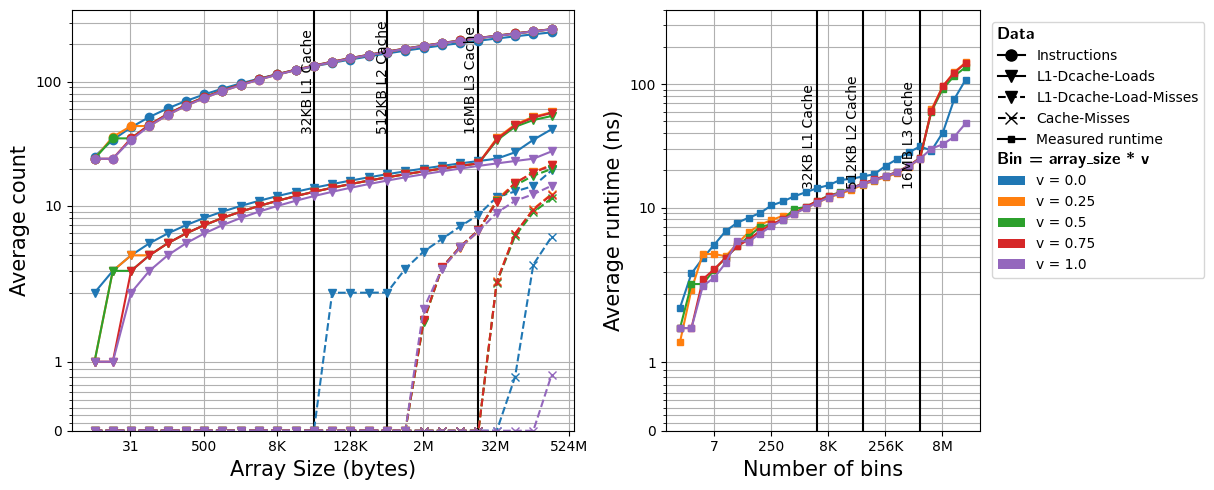

In [201]:
selected_val = cbm_mean["param_1"].unique()
# selected_val = [
#                 "0", 
#                 # "2", 
#                 # "4"
# ]

fig = plt.figure(figsize=(10, 5))
gs =  gridspec.GridSpec(1, 2, width_ratios=[1.6, 1]) 
ax = plt.subplot(gs[0])
norm = 1e3

colors = cm.tab10(np.arange(len(selected_val)))
for vi, val in enumerate(selected_val):
    for ev, clr, mrkr in [
               ["INSTRUCTIONS", "k", "o"],
               ["L1-dcache-loads", "k", "v"],
               ["L1-dcache-load-misses", "k", "v"],
               # ["cache-references", "k", "x"],
               ["cache-misses", "k", "x"],
    ]:
        # Legend Labels
        if vi == 0:
            ax.errorbar(0,0, label=ev.title(), ls=("-" if not "miss" in ev else "--"), 
                    c=clr, marker=mrkr, markersize=8)
        
        avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
        std_df = cbm_std.loc[cbm_std["param_1"] == val]
        avg = np.array(avg_df[ev] / avg_df["repetitions"])
        std = np.array(std_df[ev] / std_df["repetitions"])
        p = ax.errorbar((avg_df["nbins"]*8)/norm, avg, c=colors[vi],
                        ls=("-" if not "miss" in ev else "--"), 
                        # alpha=1, lw=vi+1,
                        marker=mrkr, yerr=std, markersize=6)

# Legend Labels
ax.errorbar(0,0, label="Measured runtime", c="k", marker="s", markersize=5)
# ax.errorbar(0,0, label="Predicted runtime", c="k", marker="s", markersize=7, markerfacecolor='none')

hmin, hmax = ax.get_ylim()
# hmin, hmax = 1e-8, 1e8
hmax+=100
div = 40
vclr="k"
plt.vlines(l1_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l1_size/norm - 13, div, "32KB L1 Cache", rotation=90, color=vclr)
plt.vlines(l2_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l2_size/norm - 180, div, "512KB L2 Cache", rotation=90, color=vclr)
plt.vlines(l3_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l3_size/norm - 7000, div, "16MB L3 Cache", rotation=90, color=vclr)

plt.xlabel("Array Size (bytes)")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x*norm))}"))
# plt.xlim([0.0005, 32])

# plt.ylabel(f"Benchmarked time ({bm_mean['ime_unit'][0]})")
plt.ylabel(f"Average count")
plt.yscale("symlog")
plt.ylim([0, hmax])
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))

ax.grid(True, which="both")
################################################

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = plt.subplot(gs[1])
acolor = 'k'
unit = "ns"
norm = 1e3

for vi, val in enumerate(selected_val):
    avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
    std_df = cbm_std.loc[cbm_std["param_1"] == val]
    avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(avg_df['time_unit'].values[0], unit)
    std = np.array(std_df["real_time"] / std_df["repetitions"])
    ax2.errorbar((avg_df["nbins"])/norm, avg, 
                  c=colors[vi], marker="s", yerr=std, markersize=5)

    ax2.add_patch(ptchs.Rectangle((0, 0), 0, 0,
        facecolor=colors[vi], label=f"v = {int(val)/4.}"))

hmin, hmax = ax2.get_ylim()
hmax = 400
div = 15
vclr="k"
ax2.vlines(l1_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l1_size/8/norm - 2.5, div, "32KB L1 Cache", rotation=90, color=vclr)
ax2.vlines(l2_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l2_size/8/norm - 42.5, div, "512KB L2 Cache", rotation=90, color=vclr)
ax2.vlines(l3_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l3_size/8/norm - 1400, div, "16MB L3 Cache", rotation=90, color=vclr)

ax2.set_xscale("log", base=2)
ax2.set_xlabel(f"Number of bins")
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x*norm))}"))

ax2.set_ylabel(f"Average runtime ({unit})", color=acolor)
ax2.tick_params(axis='y', labelcolor=acolor)
ax2.set_ylim([0, hmax])
ax2.set_yscale("symlog")
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax2.grid(True, which="both")
###################################################3

# plt.legend(loc="upper left")
# handles, labels = plt.gca().get_legend_handles_labels()
hndls = ["Data"]
hndls.extend(ax.get_legend_handles_labels()[0])
hndls.append("Bin = array_size * v")
hndls.extend(ax2.get_legend_handles_labels()[0])

lbls = [""]
lbls.extend(ax.get_legend_handles_labels()[1])
lbls.append("")
lbls.extend(ax2.get_legend_handles_labels()[1])

legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.99, 0.69),
                    handler_map={str: LegendTitle({'fontsize':12})})

# plt.grid()
# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
plt.savefig("../../images/binsearch_perfcnt_vs_size.pdf",format="pdf", bbox_inches='tight')
plt.show()

/home/jollychen/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


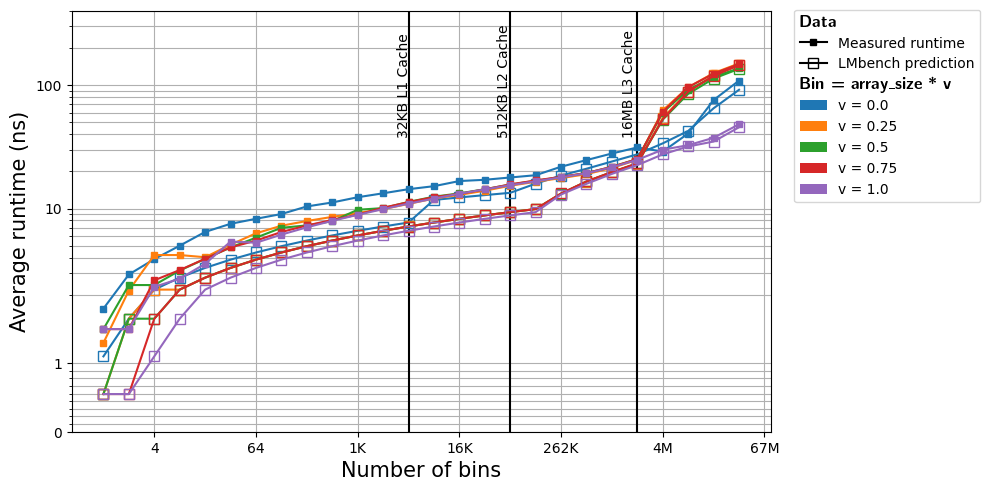

In [202]:
######### Predict binary search microbenchmark runtime via lmbench cache latencies ######
selected_val = cbm_mean["param_1"].unique()
# selected_val = ["3"]
unit = "ns"
norm = 1

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

ax.plot(0,0, label="Measured runtime", c="k", marker="s", markersize=5)
ax.plot(0,0, label="LMbench prediction", c="k", marker="s", markersize=7, markerfacecolor='none')

for vi, val in enumerate(selected_val):
    avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
    std_df = cbm_std.loc[cbm_std["param_1"] == val]
    avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(avg_df['time_unit'].values[0], unit)
    std = np.array(std_df["real_time"] / std_df["repetitions"])
    ax.errorbar((avg_df["nbins"])/norm, avg, 
                  c=colors[vi], marker="s", yerr=std, markersize=5)
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0,
        facecolor=colors[vi], label=f"v = {int(val)/4.}"))

    avg_l1 = np.array(avg_df["L1-dcache-loads"] / avg_df["repetitions"]) * T_l1
    # avg_l1 = np.array(np.log2(avg_df["nbins"])) * T_l1
    avg_l2 = np.array(avg_df["L1-dcache-load-misses"] / avg_df["repetitions"]) * T_l2
    avg_l3 = np.array(avg_df["cache-misses"] / avg_df["repetitions"]) * T_l3
    ax.errorbar((avg_df["nbins"])/norm, (avg_l1 + avg_l2 + avg_l3)/4, 
              c=colors[vi], marker="s", markersize=7, markerfacecolor='none')

ax.set_xlabel(f"Number of bins")
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
# ax.set_xlabel("Array Size (KB)")

ax.set_ylabel(f"Average runtime ({unit})", color=acolor)
ax.set_yscale("symlog")
ax.tick_params(axis='y', labelcolor=acolor)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="both")

hmin, hmax = ax.get_ylim()
hmax = 400
div = 40
vclr="k"
ax.vlines(l1_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax.text(l1_size/8/norm - 1100, div, "32KB L1 Cache", rotation=90, color=vclr)
ax.vlines(l2_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax.text(l2_size/8/norm - 20000, div, "512KB L2 Cache", rotation=90, color=vclr)
ax.vlines(l3_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax.text(l3_size/8/norm - 700000, div, "16MB L3 Cache", rotation=90, color=vclr)
ax.set_ylim([0, hmax])
             
hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Bin = array_size * v")
lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

# hndls = ["Data"]
# hndls.extend(ax1.get_legend_handles_labels()[0])
# hndls.append("Bin = array_size * v")
# hndls.extend(ax.get_legend_handles_labels()[0])
# lbls = [""]
# lbls.extend(ax1.get_legend_handles_labels()[1])
# lbls.append("")
# lbls.extend(ax.get_legend_handles_labels()[1])

legend = fig.legend(hndls, lbls,  loc='center left', bbox_to_anchor=(0.99, 0.78),
                    handler_map={str: LegendTitle({'fontsize':12})})
# fig.legend(loc='upper left', 
#            # bbox_to_anchor=(1, 0.81), 
#            title="Bin = array_size * v", alignment="left", 
#            title_fontproperties={'weight':'bold'})

fig.tight_layout()
plt.savefig("../../images/binsearch_mb_prediction.pdf", format="pdf", bbox_inches='tight')
plt.show()

/home/jollychen/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


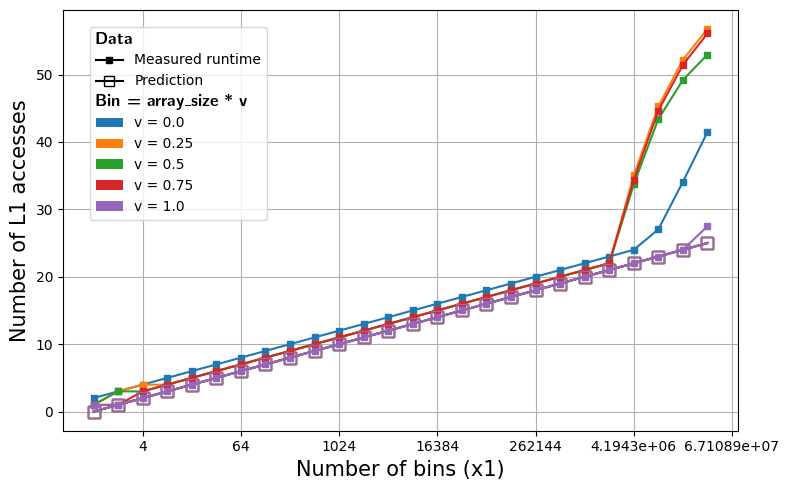

In [203]:
# Predict number of accesses based on nbins
selected_val = cbm_mean["param_1"].unique()
unit = "ns"

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

ax.plot(0,0, label="Measured runtime", c="k", marker="s", markersize=5)
ax.plot(0,0, label="Prediction", c="k", marker="s", markersize=7, markerfacecolor='none')

for vi, val in enumerate(selected_val):
    avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
    std_df = cbm_std.loc[cbm_std["param_1"] == val]
    avg = np.array(avg_df["L1-dcache-loads"] / avg_df["repetitions"]) 
    std = np.array(std_df["L1-dcache-loads"] / std_df["repetitions"])
    ax.errorbar((avg_df["nbins"])/norm, avg, 
                  c=colors[vi], marker="s", yerr=std, markersize=5)
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0,
        facecolor=colors[vi], label=f"v = {int(val)/4.}"))

    ax.errorbar((avg_df["nbins"])/norm, np.log2(avg_df["nbins"]), 
              c=colors[vi], marker="s", markersize=8, markerfacecolor='none')

# ax.set_xlabel(f"Number of bins (x{int(norm)})")
ax.set_ylabel(f"Number of L1 accesses", color=acolor)
ax.set_xlabel(f"Number of bins (x{int(norm)})")
# ax.set_xlabel("Array Size (KB)")

ax.set_xscale("log", base=2)
ax.tick_params(axis='y', labelcolor=acolor)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
ax.grid(True, which="both")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Bin = array_size * v")
lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

legend = fig.legend(hndls, lbls, loc='upper left',
                    bbox_to_anchor=(0.11, 0.95),
                    handler_map={str: LegendTitle({'fontsize':12})})
# fig.legend(loc='upper left', 
#            # bbox_to_anchor=(1, 0.81), 
#            title="Bin = array_size * v", alignment="left", 
#            title_fontproperties={'weight':'bold'})

fig.tight_layout()
# plt.savefig("../../images/binsearch_mb_prediction.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [204]:
def lower_bound(a, v):
    first = 0
    count = len(a)
    last = count - 1
    acc = np.zeros(len(a))
    indices = []
        
    while count > 0:
        it = first
        step = int(count / 2)
        it += step

        acc[it] += 1
        indices.append(it)
            
        if a[it] < v:
            it += 1
            first = it
            count -= step + 1
        else:
            count = step
    return first, acc, indices
    
a = [0,1,2,3,4,5]
v = 3.5
lower_bound(a,v)

(4, array([0., 0., 0., 1., 1., 1.]), [3, 5, 4])

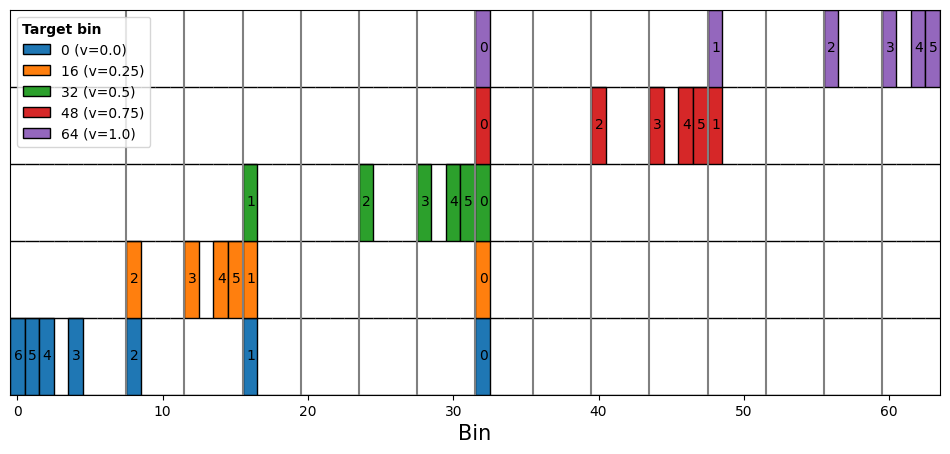

In [205]:
################## Access Pattern Illustration ##########################

selected_val = cbm_mean["param_1"].unique().astype(np.int64)/4.
# selected_val = np.linspace(0.,1.,4)
# selected_val = np.linspace(0.,1.,6)
# selected_nbins = cbm_mean["nbins"].unique()
selected_nbins = 64

fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(111)

tot_acc = 0
for vi, val in enumerate(selected_val):
    a = np.arange(selected_nbins)
    v = selected_nbins * val
    r, acc, indices = lower_bound(a,v)
    # print(a, acc)
    # plt.bar(a, acc, label=f"v = {val} ({int(sum(acc))})", width=1, alpha=0.4, edgecolor="k")
    # plt.bar(a, acc, label=f"destination = {r} ({int(sum(acc))})", width=1, alpha=1, edgecolor="k", 
    # p = plt.bar(0, 0, label=f"{r} (v={val})", width=1, alpha=1, edgecolor="k", 
    #         bottom=vi,
    #         # bottom=tot_acc,
    #        )
    # for ii, idx in enumerate(indices):
    #     plt.bar(a[idx], acc[idx], width=1, alpha=1, edgecolor="k", 
    #             color = p[0].get_facecolor(),
    #             bottom=vi)

    p = plt.bar(a, acc, label=f"{r} (v={val})", width=1, alpha=1, edgecolor="k", 
            bottom=vi,
            # bottom=tot_acc,
           )
    for ii, idx in enumerate(indices):
        plt.text(idx-0.25, vi+0.45, ii)
    tot_acc += acc 

hmin, hmax = ax.get_ylim()
for i in range(8, selected_nbins, 4):
    plt.vlines(i-0.5, ymin=hmin, ymax=hmax, color="gray")

plt.ylim([0, len(selected_val)])
plt.xlim([-0.5, selected_nbins-0.5])
plt.xlabel("Bin")
# plt.ylabel("Number of accesses")
plt.yticks([])
plt.legend(loc="upper left", title="Target bin", alignment="left", 
           title_fontproperties={'weight':'bold'})
plt.savefig("../../images/binsearch_access_pattern.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [206]:
np.nonzero(acc)

(array([32, 48, 56, 60, 62, 63]),)

/home/jollychen/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


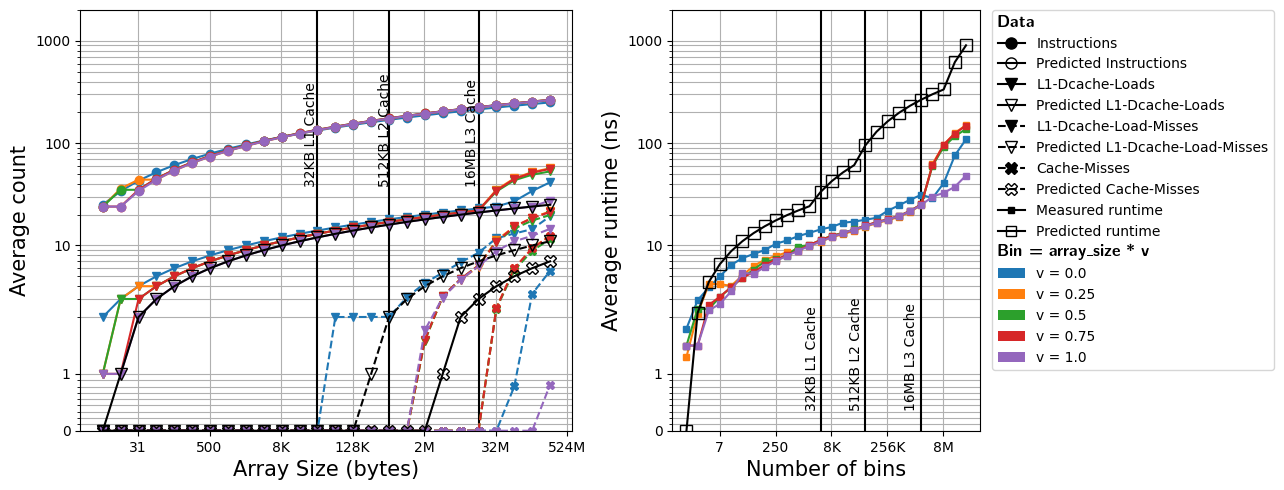

In [207]:
######## T_bscm ####################
def T_bscm(cache_size, line_size, nbins):
    return (np.log2(nbins) - np.log2(cache_size) + 1).clip(0)
    # return np.log2(nbins) - np.log2(cache_size/line_size) - np.log2(cache_size) + 1
def T_binsearch(nbins):
    return (np.log2(nbins) * T_l1 
        + T_bscm(l1_size/8, 8, nbins) * T_l2 + T_bscm(l2_size/8, 8, nbins) * T_l3
        +  T_bscm(l3_size, 64, nbins) * T_mem)
    
selected_val = cbm_mean["param_1"].unique()
# selected_val = ["3"]
unit = "ns"
norm = 1e3

fig = plt.figure(figsize=(10, 5))
gs =  gridspec.GridSpec(1, 2, width_ratios=[1.6, 1]) 
ax = plt.subplot(gs[0])
# ax.plot(0,0, label="Measured runtime", c="k", marker="s", markersize=5)
# ax.plot(0,0, label="Prediction", c="k", marker="s", markersize=7, markerfacecolor='none')
colors = cm.tab10(np.arange(len(selected_val)))

for vi, val in enumerate(selected_val):
    for ev, clr, mrkr in [
               ["INSTRUCTIONS", "k", "o"],
               ["L1-dcache-loads", "k", "v"],
               ["L1-dcache-load-misses", "k", "v"],
               # ["cache-references", "k", "x"],
               ["cache-misses", "k", "X"],
    ]:
        # Legend Labels
        if vi == 0:
            ax.errorbar(0,0, label=ev.title(), ls=("-" if not "miss" in ev else "--"), 
                    c=clr, marker=mrkr, markersize=8)
            ax.errorbar(0,0, label=f"Predicted {ev.title()}", ls=("-" if not "miss" in ev else "--"), 
                    c=clr, marker=mrkr, markersize=8, markerfacecolor='none')

        avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
        std_df = cbm_std.loc[cbm_std["param_1"] == val]
        avg = np.array(avg_df[ev] / avg_df["repetitions"])
        std = np.array(std_df[ev] / std_df["repetitions"])
        p = ax.errorbar((avg_df["nbytes"])/norm, avg, c=colors[vi],
                        ls=("-" if not "miss" in ev else "--"), 
                        # alpha=1, lw=vi+1,
                        marker=mrkr, yerr=std, markersize=6)

# Legend Labels
ax.errorbar(0,0, label="Measured runtime", c="k", marker="s", markersize=5)
ax.errorbar(0,0, label="Predicted runtime", c="k", marker="s", markersize=7, markerfacecolor='none')

#### prediction ####
pred_color = "k"
l1_loads = np.log2(avg_df["nbins"])
ax.errorbar((avg_df["nbytes"])/norm, l1_loads, 
          c=pred_color, marker="v", markersize=8, markerfacecolor='none')
l2_loads = T_bscm(l1_size, 64, avg_df["nbins"])
ax.errorbar((avg_df["nbytes"])/norm, l2_loads, 
          c=pred_color, ls="--", marker="v", markersize=8, markerfacecolor='none')
l3_loads = T_bscm(l2_size, 64, avg_df["nbins"])
ax.errorbar((avg_df["nbytes"])/norm, l3_loads, 
          c=pred_color, marker="X", markersize=8, markerfacecolor='none')

hmin, hmax = ax.get_ylim()
# hmin, hmax = 1e-8, 1e8
hmax= 2000
div = 40
vclr="k"
plt.vlines(l1_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l1_size/norm - 13, div, "32KB L1 Cache", rotation=90, color=vclr)
plt.vlines(l2_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l2_size/norm - 180, div, "512KB L2 Cache", rotation=90, color=vclr)
plt.vlines(l3_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l3_size/norm - 7000, div, "16MB L3 Cache", rotation=90, color=vclr)

plt.xlabel("Array Size (bytes)")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x*norm))}"))
# plt.xlim([0.0005, 32])

# plt.ylabel(f"Benchmarked time ({bm_mean['ime_unit'][0]})")
plt.ylabel(f"Average count")
plt.yscale("symlog")
plt.ylim([0, hmax])
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))

ax.grid(True, which="both")
################################################

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = plt.subplot(gs[1])
acolor = 'k'
unit = "ns"
norm = 1e3

for vi, val in enumerate(selected_val):
    avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
    std_df = cbm_std.loc[cbm_std["param_1"] == val]
    avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(avg_df['time_unit'].values[0], unit)
    std = np.array(std_df["real_time"] / std_df["repetitions"])
    ax2.errorbar((avg_df["nbins"])/norm, avg, 
                  c=colors[vi], marker="s", yerr=std, markersize=5)

    # legend labels
    ax2.add_patch(ptchs.Rectangle((0, 0), 0, 0,
        facecolor=colors[vi], label=f"v = {int(val)/4.}"))

ax2.errorbar((avg_df["nbins"])/norm, T_binsearch(avg_df["nbins"]),
          c=pred_color, marker="s", markersize=8, markerfacecolor='none')

hmin, hmax = ax2.get_ylim()
hmax= 2000
div = 0.4
vclr="k"
ax2.vlines(l1_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l1_size/8/norm - 2.5, div, "32KB L1 Cache", rotation=90, color=vclr)
ax2.vlines(l2_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l2_size/8/norm - 42.5, div, "512KB L2 Cache", rotation=90, color=vclr)
ax2.vlines(l3_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l3_size/8/norm - 1400, div, "16MB L3 Cache", rotation=90, color=vclr)

ax2.set_xscale("log", base=2)
ax2.set_xlabel(f"Number of bins")
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x*norm))}"))

ax2.set_ylabel(f"Average runtime ({unit})", color=acolor)
ax2.tick_params(axis='y', labelcolor=acolor)
ax2.set_ylim([0, hmax])
ax2.set_yscale("symlog")
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax2.grid(True, which="both")
###################################################3

# plt.legend(loc="upper left")
# handles, labels = plt.gca().get_legend_handles_labels()
hndls = ["Data"]
hndls.extend(ax.get_legend_handles_labels()[0])
hndls.append("Bin = array_size * v")
hndls.extend(ax2.get_legend_handles_labels()[0])

lbls = [""]
lbls.extend(ax.get_legend_handles_labels()[1])
lbls.append("")
lbls.extend(ax2.get_legend_handles_labels()[1])

legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.99, 0.61),
                    handler_map={str: LegendTitle({'fontsize':12})})

# plt.grid()
# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
plt.savefig("../../images/binsearch_mb_Tbscm.pdf",format="pdf", bbox_inches='tight')
plt.show()

#### Validation

constant-0.5 116.87922788991217 -66701.22556480131
normal-0.4-0.1 24.513986227042675 95.61437088413952
normal-0.7-0.01 78.11755023991218 -433.12255407102134
uniform 70.06730509258342 82.46981553982125


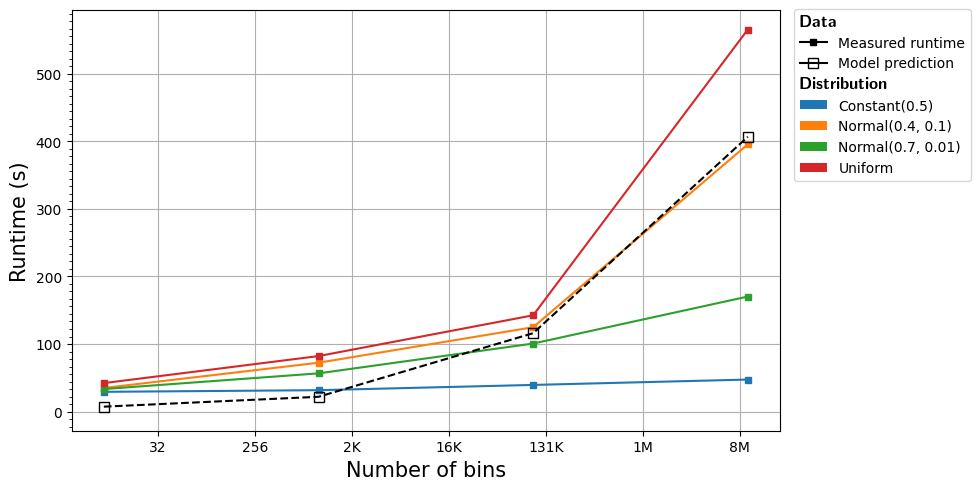

In [208]:
####### nbins vs nvals, distr subplots ###########
def T_bscm(cache_size, sub_size, nbins):
    return (np.log2(nbins) - np.log2(cache_size) + 1).clip(0)
    # return (np.log2(sub_size) - np.log2(cache_size-(np.log2(nbins)/(np.log2(sub_size) + 1))) + 1).clip(0)
    # return np.log2(nbins) - np.log2(cache_size/line_size) - np.log2(cache_size) + 1
def T_binsearch(nbins, subsize=None):
    return (np.log2(nbins) * T_l1 
        + T_bscm(l1_size/8, subsize, nbins) * T_l2 + T_bscm(l2_size/8, subsize, nbins) * T_l3
        +  T_bscm(l3_size, subsize, nbins) * T_mem)
    
selected_env = "CPU" 
selected_bulksize = 32768
selected_nbins = unique_nbins
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = True

# gs =  gridspec.GridSpec(1, len(selected_distr), 
#                         # width_ratios=[1.6, 1],
#                        ) 

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# Legend Labels
plt.plot(0,0, label="Measured runtime", c="k", marker="s", markersize=5)
plt.plot(0,0, label="Model prediction", c="k", marker="s", markersize=7, markerfacecolor='none')

for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, selected_nvals, selected_nbins, selected_bulksize, selected_edges
    avg = gp_vd.mean().loc[arg]
    std = gp_vd.std().loc[arg]
    
    p = ax.errorbar(selected_nbins, avg["tfindbin"], 
                     yerr=std["tfindbin"], 
                     marker="s", markersize=5,
                 # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
                 # label=f"{distr}"
                )
    

    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))

    pred = T_binsearch(selected_nbins)/1e9*selected_nvals
    observ = avg["tfindbin"].values
    print(distr, mae(pred, observ), r2(pred, observ) * 100)
    
pred_color="k"
subsize = selected_nbins
ax.errorbar(selected_nbins, 
             T_binsearch(selected_nbins, subsize)/1e9*selected_nvals, 
             c=pred_color,
             marker="s", markerfacecolor="none", ls="--", markersize=7,
             # label=f"Prediction {int(nb)} bin{'s' if int(nb) > 1 else ''}"
            )

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.99, 0.8),
                    handler_map={str: LegendTitle({'fontsize':12})})

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylabel("Runtime (s)")
# plt.yscale("symlog")
# plt.ylim([0,1000])
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

plt.tight_layout()
plt.savefig("../../images/binsearch_validation.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [209]:
selected_nbins

array([1.e+01, 1.e+03, 1.e+05, 1.e+07])

constant-0.5 [ 7.30824181 21.92472543 36.54120904 51.15769266] 9.592689845623898 -195.51055069356428
normal-0.4-0.1 [  7.30824181  21.92472543  73.75223514 300.97095696] 55.91462156616481 81.43347501123596
normal-0.7-0.01 [  7.30824181  21.92472543  43.30485798 194.66976457] 35.63433863886955 46.948301630846125
uniform [  7.30824181  21.92472543 116.05254912 406.6466644 ] 70.0658657608191 82.47042865657443


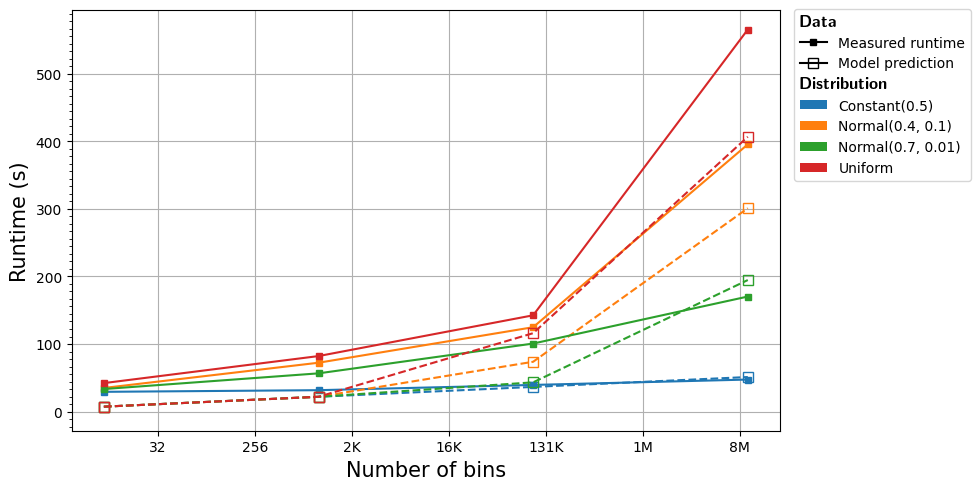

In [210]:
####### nbins vs nvals, distr subplots ###########
def T_bscm(cache_size, sub_size, nbins):
    # return (np.log2(nbins) - np.log2(cache_size) + 1).clip(0)
    return (np.log2(sub_size) - np.log2(cache_size-(np.log2(nbins)/(np.log2(sub_size) + 1))) + 1).clip(0)
    # return np.log2(nbins) - np.log2(cache_size/line_size) - np.log2(cache_size) + 1
def T_binsearch(nbins, subsize):
    return (np.log2(nbins) * T_l1 
        + T_bscm(l1_size/8, subsize, nbins) * T_l2 + T_bscm(l2_size/8, subsize, nbins) * T_l3
        +  T_bscm(l3_size, subsize, nbins) * T_mem)
    
selected_env = "CPU" 
selected_bulksize = 32768
selected_nbins = unique_nbins
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = True

# gs =  gridspec.GridSpec(1, len(selected_distr), 
#                         # width_ratios=[1.6, 1],
#                        ) 

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# Legend Labels
plt.plot(0,0, label="Measured runtime", c="k", marker="s", markersize=5)
plt.plot(0,0, label="Model prediction", c="k", marker="s", markersize=7, markerfacecolor='none')

for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, selected_nvals, selected_nbins, selected_bulksize, selected_edges
    avg = gp_vd.mean().loc[arg]
    std = gp_vd.std().loc[arg]
    
    p = ax.errorbar(selected_nbins, avg["tfindbin"], 
                     yerr=std["tfindbin"], 
                     marker="s", ecolor="k", markersize=5,
                 # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
                 # label=f"{distr}"
                )
    

    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))

    pred_color=p[0].get_color()
    if "constant" in distr:
        subsize = 1
    elif "uniform" in distr:
        subsize = selected_nbins
    elif "normal" in distr:
        mu = np.float64(distr.split("-")[1])
        sigma = np.float64(distr.split("-")[2])
        xmin = mu - 2*sigma
        xmax = mu + 2*sigma
        subsize = []
        for nb in selected_nbins:
            a = np.arange(nb)/nb
            subsize.append(lower_bound(a, xmax)[0] - lower_bound(a, xmin)[0])
        
    ax.errorbar(selected_nbins, 
                 T_binsearch(selected_nbins, subsize)/1e9*selected_nvals, 
                 c=pred_color,
                 marker="s", markerfacecolor="none", ls="--", markersize=7,
                 # label=f"Prediction {int(nb)} bin{'s' if int(nb) > 1 else ''}"
                )

    pred = T_binsearch(selected_nbins, subsize)/1e9*selected_nvals
    observ = avg["tfindbin"].values
    print(distr, pred, mae(pred, observ), r2(pred, observ) * 100)

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.99, 0.8),
                    handler_map={str: LegendTitle({'fontsize':12})})

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylabel("Runtime (s)")
# plt.yscale("symlog")
# plt.ylim([0,1000])
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

plt.tight_layout()
plt.savefig("../../images/binsearch_validation_modified.pdf", format="pdf", bbox_inches='tight')
plt.show()

### Fixed bins search

In [753]:
fxs_df = clb_df[clb_df["func_name"] == "FixedSearch"].copy()
n_param = len(fxs_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        fxs_df[f"param_{i}"] = fxs_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0])
    else:
        fxs_df[f"param_{i}"] = fxs_df["name"].apply(lambda s: s.split("/")[i+1])

fxs_mean = fxs_df.loc[fxs_df["name"].str.contains("mean")]
fxs_std = fxs_df.loc[fxs_df["name"].str.contains("stddev")]
# convert_to_type(
fxs_mean

,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,cpu_time,...,INSTRUCTIONS,L1-dcache-load-misses,L1-dcache-loads,cache-misses,cache-references,dim,bin,func_name,time_factor,param_0
36,BM_FixedSearch/manual_time_mean,BM_FixedSearch/manual_time,aggregate,1000000.0,1,mean,time,3,25.765783,64.358444,...,3.048817e+08,5.962963,1.293907e+08,6.234568,1403.580247,NaN,-2.147484e+09,FixedSearch,1000.0,manual


constant-0.5 [25.76578348] 6.804617073136409 -11168780.706396306
normal-0.4-0.1 [25.76578348] 6.686920873136415 -58749.552994224636
normal-0.7-0.01 [25.76578348] 6.76588207313641 -8610453.99470323
uniform [25.76578348] 6.863492273136412 -289704.1515274263


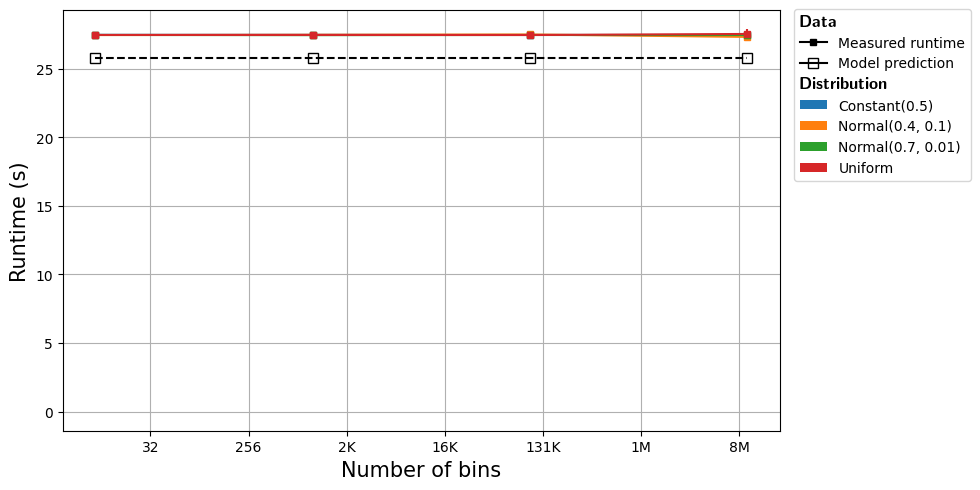

In [754]:
####### nbins vs nvals, distr subplots ###########
def T_fixedsearch(nbins, subsize):
    return (np.log2(nbins) * T_l1 
        + T_bscm(l1_size/8, subsize, nbins) * T_l2 + T_bscm(l2_size/8, subsize, nbins) * T_l3
        +  T_bscm(l3_size, subsize, nbins) * T_mem)
    
selected_env = "CPU" 
selected_bulksize = 32768
selected_nbins = unique_nbins
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = False
unit = "s"

# gs =  gridspec.GridSpec(1, len(selected_distr), 
#                         # width_ratios=[1.6, 1],
#                        ) 

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# Legend Labels
plt.plot(0,0, label="Measured runtime", c="k", marker="s", markersize=5)
plt.plot(0,0, label="Model prediction", c="k", marker="s", markersize=7, markerfacecolor='none')

for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, selected_nvals, selected_nbins, selected_bulksize, selected_edges
    avg = gp_vd.mean().loc[arg]
    std = gp_vd.std().loc[arg]
    
    p = ax.errorbar(selected_nbins, avg["tfindbin"], 
                     yerr=std["tfindbin"], 
                     marker="s", markersize=5,
                 # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
                 # label=f"{distr}"
                )
    

    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))

    # pred = fxs_mean["real_time"]/fxs_mean["repetitions"]*unit_to_unit_factor(fxs_mean['time_unit'].values[0], unit) * selected_nvals, 
    pred = fxs_mean["real_time"].values * unit_to_unit_factor(fxs_mean['time_unit'].values[0], unit) / fxs_mean["repetitions"].values * selected_nvals 
    observ = avg["tfindbin"].values
    print(distr, pred, mae(pred, observ), r2(pred, observ) * 100)
    
pred_color="k"
subsize = selected_nbins
ax.errorbar(selected_nbins, 
             np.repeat(pred, len(selected_nbins)), 
             c=pred_color,
             marker="s", markerfacecolor="none", ls="--", markersize=7,
             # label=f"Prediction {int(nb)} bin{'s' if int(nb) > 1 else ''}"
            )

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.99, 0.8),
                    handler_map={str: LegendTitle({'fontsize':12})})

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylabel("Runtime (s)")
# plt.yscale("symlog")
# plt.ylim([0,1000])
yaxis = plt.gca().yaxis
# yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

plt.tight_layout()
plt.savefig("../../images/fixedbin_validation.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [213]:
fxs_mean["real_time"].values * unit_to_unit_factor(fxs_mean['time_unit'].values[0], "ns") / fxs_mean["repetitions"].values

array([26.07877015])

### T_FindBin

## Histogram Fill

In [216]:
# fb_df = gbm_eval_df[gbm_eval_df["func_name"] == "Histogram"]
# fb_df.head(5)

In [217]:
# ROOT Plot
# def f_fb(fixed, bulksize):
#     if fixed:
#         return bulksize * (T_alg1_16 + T_alg1_23)
#     return bulksize * (T_alg1_18 + T_alg1_23)

# w = 1600
# h = 900
# c = ROOT.TCanvas("c1", title, w, h)
# c.SetRightMargin(0.32)
# c.SetBottomMargin(0.33)

# l = ROOT.TLegend(0.7, 0.7, 0.96, 0.9)
# l.SetTextSize(0.05)

# # model_fb = ROOT.TF1("f_bs", f_bs, fb_df["param"].min(), fb_df["param"].max(), 3)
# # fit = g.Fit(model_fb, "", "", 10e-3, 40e4)
# # l.AddEntry(model_fb, "Fit")

# g = ROOT.TGraph(len(fb_df["param"]), fb_df["param"].values, fb_df["real_time"].values)
# g.SetMarkerSize(1)
# g.SetMarkerStyle(8)
# l.AddEntry(g, "Microbenchmark", "p")

# xaxis = g.GetXaxis()
# xaxis.SetTitle("Number of bins")
# # xaxis.SetTitleOffset(3)
# xaxis.SetTitleSize(0.05)
# xaxis.SetTickSize(0)
# xaxis.SetLabelSize(0.05)
# xaxis.LabelsOption("vM")
# xaxis.SetRangeUser(0, 5*10e3)

# yaxis = g.GetYaxis()
# yaxis.SetTitle(f"Time ({list(bs_df['time_unit'])[0]}")
# yaxis.SetTitleSize(0.05)
# yaxis.SetLabelSize(0.05)
# # yaxis.SetRangeUser(0, 0.4)


# # model_bs.Draw("C")
# g.Draw("APSAME")

# # title="Calibration of T_{bs}"
# # model_bs.SetTitle(title)

# l.Draw()
# c.Draw()
# ROOT.gPad.Modified(); ROOT.gPad.Update()

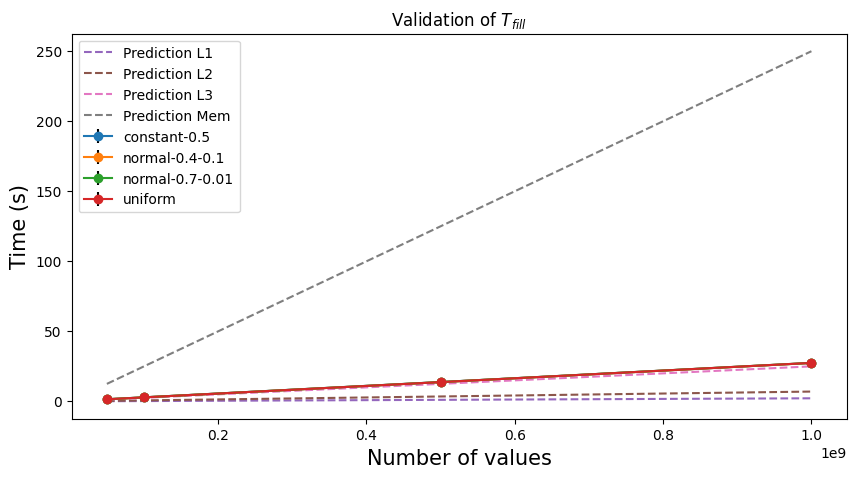

In [218]:
plt.figure(figsize=(10,5))
plt.title("Validation of $T_{fill}$")
plt.subplot(111)

selected_env = "CPU" 
selected_bulksize = 32768
selected_bins = 1000
selected_nvals = unique_nvals
selected_distr = "uniform"
selected_edges = True

nb = 1000
# for nb in unique_nbins:
lines = []
for distr in unique_distribution:
    p = plt.errorbar(unique_nvals, gp_vd.mean().loc[selected_env, distr,:, nb, selected_bulksize, selected_edges]["tfill"], 
                 yerr=gp_vd.std().loc[selected_env, distr, :, nb, selected_bulksize, selected_edges]["tfill"], 
                 marker="o", ecolor="k", 
                 # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                 label=f"{distr}"
                )
    lines.append(p)

plt.plot(unique_nvals, np.repeat(T_l1/1e9, len(unique_nvals)) * unique_nvals, ls="--", label="Prediction L1")
plt.plot(unique_nvals, np.repeat(T_l2/1e9, len(unique_nvals)) * unique_nvals, ls="--",label="Prediction L2")
plt.plot(unique_nvals, np.repeat(T_l3/1e9, len(unique_nvals)) * unique_nvals, ls="--",label="Prediction L3")
plt.plot(unique_nvals, np.repeat(T_mem/1e9, len(unique_nvals)) * unique_nvals, ls="--",label="Prediction Mem")

plt.xlabel("Number of values")
plt.ylabel("Time (s)")
plt.legend()

constant-0.5
nbins: [1.e+01 1.e+03 1.e+05 1.e+07]
subsize: [1 1 1 1]
T1: 1
T2: [0 0 0 0]
T3: [0 0 0 0]
Tmem: [0 0 0 0]
pred: [2.2 2.2 2.2 2.2]
MAE: 25.26693775
R2: -2463902886.3267617
normal-0.4-0.1
nbins: [1.e+01 1.e+03 1.e+05 1.e+07]
subsize: [      5     401   40001 4000001]
T1: 1
T2: [0 0 1 1]
T3: [0 0 0 1]
Tmem: [0 0 0 1]
pred: [  2.2   2.2   9.2 284.2]
MAE: 81.42709750000002
R2: -355261926.145019
normal-0.7-0.01
nbins: [1.e+01 1.e+03 1.e+05 1.e+07]
subsize: [     1     40   4000 400000]
T1: 1
T2: [0 0 0 1]
T3: [0 0 0 1]
Tmem: [0 0 0 0]
pred: [ 2.2  2.2  2.2 34.2]
MAE: 20.6292581
R2: -1474162078.6569066
uniform
nbins: [1.e+01 1.e+03 1.e+05 1.e+07]
subsize: [1.e+01 1.e+03 1.e+05 1.e+07]
T1: 1
T2: [0 0 1 1]
T3: [0 0 1 1]
Tmem: [0 0 0 1]
pred: [  2.2   2.2  34.2 284.2]
MAE: 78.48390945000001
R2: -1653035134.0228167


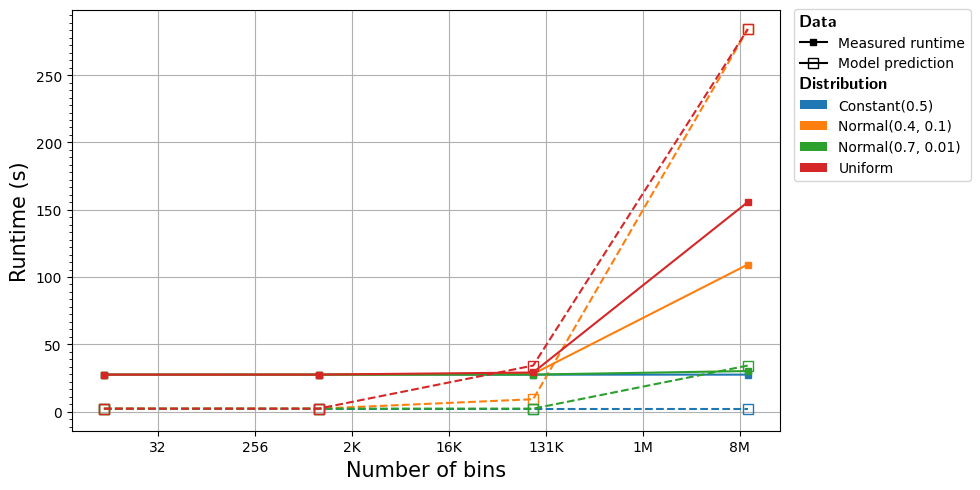

In [391]:
####### nbins vs nvals, distr subplots ###########
def T_fill(nbins, subsize):
    print("nbins:", nbins)
    print("subsize:", np.array(subsize))
    
    l1_miss = (np.array(subsize) > l1_size/8).astype(np.int64)
    l2_miss = (np.array(subsize) > l2_size/8).astype(np.int64)
    l3_miss = (np.array(subsize) > l3_size/8).astype(np.int64)
    print("T1:", 1)
    print("T2:", l1_miss)
    print("T3:", l2_miss)
    print("Tmem:", l3_miss)

    # return np.repeat(T_l1, len(nbins))
    # return np.repeat(
    return  (
         T_l1 
        + l1_miss * T_l2 
        + l1_miss * l2_miss * T_l3
        + l1_miss * l2_miss * l3_miss * T_mem
   # , len(nbins)
    )

# generate Gaussian function
def gauss(x):
    return scipy.stats.norm.pdf(x, mu, sigma)
    
# # integrate between bounds
# integral = scipy.integrate.quad(gauss, lowerbound, upperbound)

# def T_fill(nbins, subsize):
#     print("nbins:", nbins)
#     print("subsize:", np.array(subsize))
    
#     l1_doubles = np.array(l1_size/8)
#     l2_doubles = np.array(l2_size/8)
#     l3_doubles = np.array(l3_size/8)
    
#     l1_miss = (np.array(subsize) > l1_doubles).astype(np.int64)
#     l2_miss = (np.array(subsize) > l2_doubles).astype(np.int64)
#     l3_miss = (np.array(subsize) > l3_doubles).astype(np.int64)
#     print("T1:", 1)
#     print("T2:", l1_miss)
#     print("T3:", l2_miss)
#     print("Tmem:", l3_miss)

#     # return np.repeat(T_l1, len(nbins))
#     # return np.repeat(
#     return  (
#          T_l1 
#         + (l1_doubles/subsize) * l1_miss * T_l2 
#         + (l2_doubles/subsize) * l2_miss * T_l3
#         + (l3_doubles/subsize) * l2_miss * l3_miss * T_mem
#    # , len(nbins)
#     )
    
selected_env = "CPU" 
selected_bulksize = 32768
selected_nbins = unique_nbins
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = False

# gs =  gridspec.GridSpec(1, len(selected_distr), 
#                         # width_ratios=[1.6, 1],
#                        ) 

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# Legend Labels
plt.plot(0,0, label="Measured runtime", c="k", marker="s", markersize=5)
plt.plot(0,0, label="Model prediction", c="k", marker="s", markersize=7, markerfacecolor='none')

for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, selected_nvals, selected_nbins, selected_bulksize, selected_edges
    avg = gp_vd.mean().loc[arg]
    std = gp_vd.std().loc[arg]
    
    p = ax.errorbar(selected_nbins, avg["tfill"], 
                     yerr=std["tfill"], 
                     marker="s", markersize=5,
                 # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
                 # label=f"{distr}"
                )
    

    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))

    
    pred_color=p[0].get_color()
    if "constant" in distr:
        subsize = np.repeat(1, len(selected_nbins))
    elif "uniform" in distr:
        subsize = selected_nbins
    elif "normal" in distr:
        mu = np.float64(distr.split("-")[1])
        sigma = np.float64(distr.split("-")[2])
        xmin = mu - 2*sigma
        xmax = mu + 2*sigma
        subsize = []
        for nb in selected_nbins:
            a = np.arange(nb)/nb
            subsize.append(lower_bound(a, xmax)[0] - lower_bound(a, xmin)[0])
        
    print(distr)
    # pred =  T_fill(selected_nbins, subsize)
    pred =  T_fill(selected_nbins, subsize) * selected_nvals * unit_to_unit_factor("ns", "s") 
    ax.errorbar(selected_nbins, 
                 # T_fill(selected_nbins, subsize)/1e14*selected_nvals*4, 
                pred, 
                c=pred_color,
                marker="s", markerfacecolor="none", ls="--", markersize=7,
                 # label=f"Prediction {int(nb)} bin{'s' if int(nb) > 1 else ''}"
                )
    print("pred:", pred)

    observ = avg["tfindbin"].values
    print("MAE:", mae(pred, observ))
    print("R2:", r2(pred, observ) * 100)

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.99, 0.8),
                    handler_map={str: LegendTitle({'fontsize':12})})

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylabel("Runtime (s)")
# plt.yscale("symlog")
# plt.ylim([0,1000])
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

plt.tight_layout()
# plt.savefig("../../images/fillbin_validation.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
l1_size/8

# Other Overhead

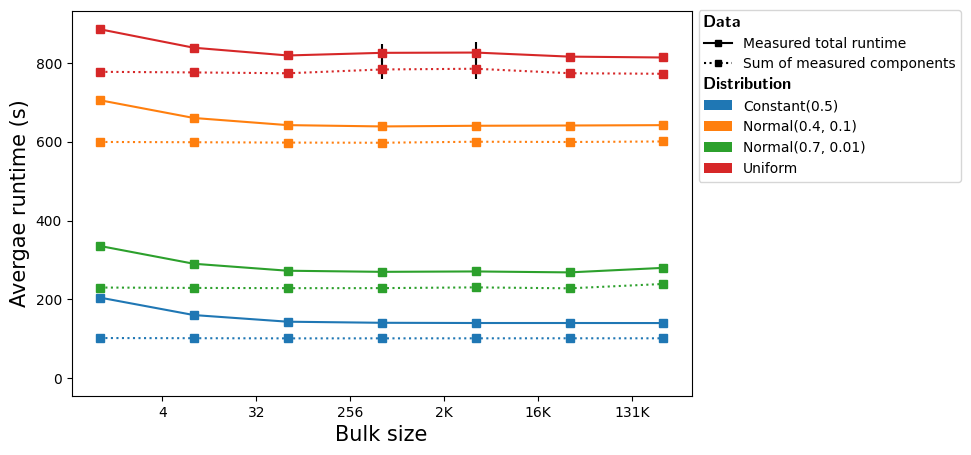

In [532]:
selected_env = "CPU" 
selected_bulksize = unique_bulksize
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distribution
selected_edges = True

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# Legend Labels
ax.plot(0,0, label="Measured total runtime", c="k", marker="s", markersize=5)
ax.plot(0,0, label="Sum of measured components", c="k", marker="s", ls=":",  markersize=5)

for distr in unique_distribution:
    arg = selected_env, distr, selected_nvals, selected_nbins, selected_bulksize, selected_edges
    ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
    ttotal_std = gp_vd.std().loc[arg]["ttotal"]
    p = plt.errorbar(selected_bulksize, ttotal_avg, yerr=ttotal_std, 
                 marker="s", ecolor="k", 
                 # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                 # label=f"{distr} total"
                )
    
    tfill_avg = gp_vd.mean().loc[arg]["tfill"]
    tfill_std = gp_vd.std().loc[arg]["tfill"]
    tusb_avg = gp_vd.mean().loc[arg]["tstats"]
    tusb_std = gp_vd.std().loc[arg]["tstats"]
    tfindbin_avg = gp_vd.mean().loc[arg]["tfindbin"]
    tfindbin_std = gp_vd.std().loc[arg]["tfindbin"]
    
    p = plt.errorbar(selected_bulksize, 
                     tfill_avg + tusb_avg + tfindbin_avg, 
                     yerr=tfill_std + tusb_std + tfindbin_std, 
                     marker="s", ecolor="k", color=p[0].get_color(), ls=":",
                    )
    
    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    
hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.9, 0.71),
                    handler_map={str: LegendTitle({'fontsize':12})})
# plt.legend()

# plt.tight_layout()
plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylabel("Avergae runtime (s)")

# plt.savefig("../../images/cpu_bulksize_comparison.pdf", format="pdf", bbox_inches='tight')
plt.show()

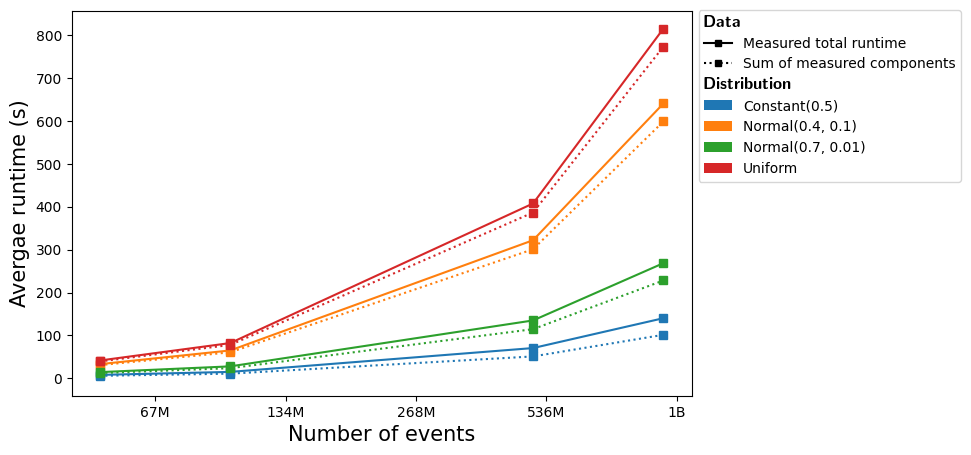

In [486]:
selected_env = "CPU" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = unique_nvals
selected_distr = unique_distribution
selected_edges = True

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# Legend Labels
ax.plot(0,0, label="Measured total runtime", c="k", marker="s", markersize=5)
ax.plot(0,0, label="Sum of measured components", c="k", marker="s", ls=":",  markersize=5)

for distr in unique_distribution:
    arg = selected_env, distr, selected_nvals, selected_nbins, selected_bulksize, selected_edges
    ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
    ttotal_std = gp_vd.std().loc[arg]["ttotal"]
    p = plt.errorbar(unique_nvals, ttotal_avg, yerr=ttotal_std, 
                 marker="s", ecolor="k", 
                 # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                 # label=f"{distr} total"
                )
    
    tfill_avg = gp_vd.mean().loc[arg]["tfill"]
    tfill_std = gp_vd.std().loc[arg]["tfill"]
    tusb_avg = gp_vd.mean().loc[arg]["tstats"]
    tusb_std = gp_vd.std().loc[arg]["tstats"]
    tfindbin_avg = gp_vd.mean().loc[arg]["tfindbin"]
    tfindbin_std = gp_vd.std().loc[arg]["tfindbin"]
    
    p = plt.errorbar(unique_nvals, 
                     tfill_avg + tusb_avg + tfindbin_avg, 
                     yerr=tfill_std + tusb_std + tfindbin_std, 
                     marker="s", ecolor="k", color=p[0].get_color(), ls=":",
                    )
    
    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    
hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.9, 0.71),
                    handler_map={str: LegendTitle({'fontsize':12})})
# plt.legend()

# plt.tight_layout()
plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylabel("Avergae runtime (s)")

plt.savefig("../../images/total_vs_inner_overhead.pdf", format="pdf", bbox_inches='tight')
plt.show()

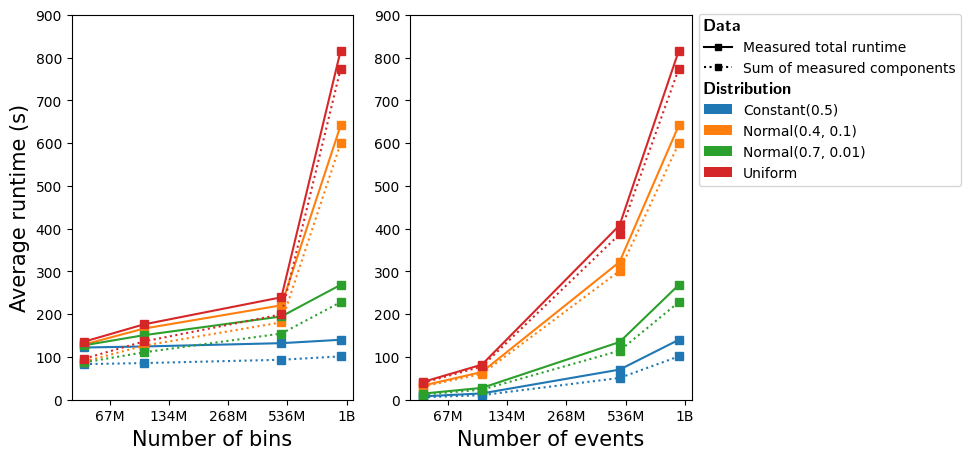

In [524]:
selected_env = "CPU" 
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distribution
selected_edges = True

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(121)

for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, selected_edges
    ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
    ttotal_std = gp_vd.std().loc[arg]["ttotal"]
    p = plt.errorbar(unique_nvals, ttotal_avg, yerr=ttotal_std, 
                 marker="s", ecolor="k", 
                 # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                 # label=f"{distr} total"
                )
    tfill_avg = gp_vd.mean().loc[arg]["tfill"]
    tfill_std = gp_vd.std().loc[arg]["tfill"]
    tusb_avg = gp_vd.mean().loc[arg]["tstats"]
    tusb_std = gp_vd.std().loc[arg]["tstats"]
    tfindbin_avg = gp_vd.mean().loc[arg]["tfindbin"]
    tfindbin_std = gp_vd.std().loc[arg]["tfindbin"]
    p = plt.errorbar(unique_nvals, 
                     tfill_avg + tusb_avg + tfindbin_avg, 
                     yerr=tfill_std + tusb_std + tfindbin_std, 
                     marker="s", ecolor="k", color=p[0].get_color(), ls=":",
                    )

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
# plt.ylim([0, 50])
plt.ylim([0,270])
plt.ylabel("Average runtime (s)")

ax = plt.subplot(122)
ax.plot(0,0, label="Measured total runtime", c="k", marker="s", markersize=5)
ax.plot(0,0, label="Sum of measured components", c="k", marker="s", ls=":",  markersize=5)
for di,distr in enumerate(selected_distr):
    arg = selected_env, distr, unique_nvals, selected_nbins, selected_bulksize, selected_edges
    ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
    ttotal_std = gp_vd.std().loc[arg]["ttotal"]
    p = plt.errorbar(unique_nvals, ttotal_avg, yerr=ttotal_std, 
                 marker="s", ecolor="k", 
                 # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                 # label=f"{distr} total"
                )
    
    tfill_avg = gp_vd.mean().loc[arg]["tfill"]
    tfill_std = gp_vd.std().loc[arg]["tfill"]
    tusb_avg = gp_vd.mean().loc[arg]["tstats"]
    tusb_std = gp_vd.std().loc[arg]["tstats"]
    tfindbin_avg = gp_vd.mean().loc[arg]["tfindbin"]
    tfindbin_std = gp_vd.std().loc[arg]["tfindbin"]
    p = plt.errorbar(unique_nvals, 
                     tfill_avg + tusb_avg + tfindbin_avg, 
                     yerr=tfill_std + tusb_std + tfindbin_std, 
                     marker="s", ecolor="k", color=p[0].get_color(), ls=":",
                    )    
    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    
plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.9, 0.71),
                    handler_map={str: LegendTitle({'fontsize':12})})
plt.ylim([0,900])

plt.savefig("../../images/total_vs_inner_overhead_explicitedges.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Total Validation

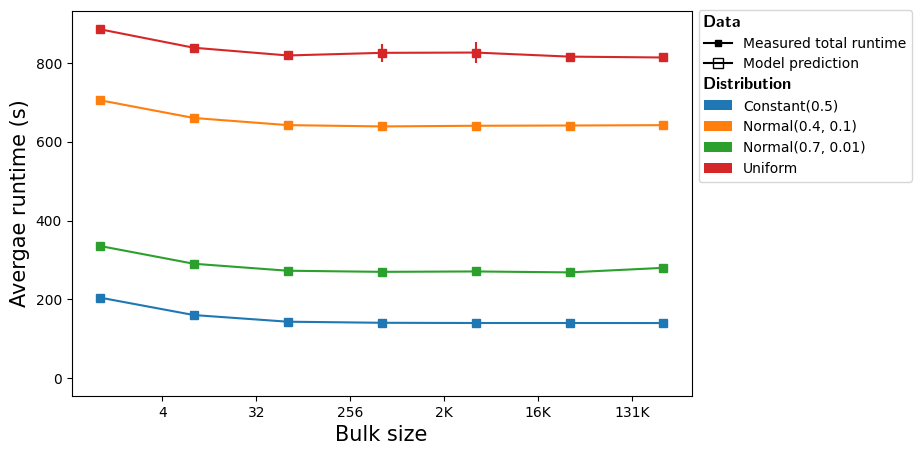

In [734]:
selected_env = "CPU" 
selected_bulksize = unique_bulksize
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distribution
selected_edges = True

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# Legend Labels
ax.plot(0,0, label="Measured total runtime", c="k", marker="s", markersize=5)
plt.plot(0,0, label="Model prediction", c="k", marker="s", markersize=7, markerfacecolor='none')

for distr in unique_distribution:
    arg = selected_env, distr, selected_nvals, selected_nbins, selected_bulksize, selected_edges
    ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
    ttotal_std = gp_vd.std().loc[arg]["ttotal"]
    p = plt.errorbar(selected_bulksize, ttotal_avg, yerr=ttotal_std, 
                 marker="s", 
                 # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
                 # label=f"{distr} total"
                )

    # In nanoseconds!
    tfill_pred = gp_vd.mean().loc[arg]["tfill"]
    tfindbin_pred = gp_vd.mean().loc[arg]["tfindbin"]    
    tusb_pred = T_updatestats
    # p = plt.errorbar(selected_bulksize, 
    #                  tfill_pred + tusb_pred + tfindbin_pred, 
    #                  marker="s", ecolor="k", color=p[0].get_color(), ls=":",
    #                 )
    
    # Legend Labels
    ax.add_patch(ptchs.Rectangle((0, 0), 0, 0, 
                                 facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
    
hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.9, 0.71),
                    handler_map={str: LegendTitle({'fontsize':12})})
# plt.legend()

# plt.tight_layout()
plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))

plt.ylabel("Avergae runtime (s)")

# plt.savefig("../../images/cpu_validation_per_bulksize.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Linear Search Benchmark

In [ ]:
filename = "../microbenchmarks/das6-cpu/gbenchmark_evaluation.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
bm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(df, "real_time", np.float64)
bm_df["func_name"] = bm_df["name"].apply(lambda s: s.split("/")[0][3:])
bm_df["time_factor"] = bm_df["time_unit"].apply(convert_unit)
# bm_df["time (s)"] = bm_df["real_time"] * bm_df["time_unit"].apply(convert_unit)
del bm_df["family_index"], bm_df["per_family_instance_index"]

gbm_df = bm_df.loc[bm_df["name"].str.contains("Search")].copy()
n_param = len(gbm_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        gbm_df[f"param_{i}"] = gbm_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0])
    else:
        gbm_df[f"param_{i}"] = gbm_df["name"].apply(lambda s: s.split("/")[i+1])

gbm_mean = gbm_df.loc[gbm_df["name"].str.contains("mean")]
gbm_std = gbm_df.loc[gbm_df["name"].str.contains("stddev")]
gbm_mean

In [ ]:
%jsroot off

unique_nbins = gbm_mean["nbins"].unique().astype(np.float64)
unique_bin = gbm_mean["bin"].unique().astype(np.float64)
unique_val = gbm_mean["bin"].unique().astype(np.float64)
unique_func = gbm_mean["func_name"].unique()

c = ROOT.TCanvas("c1", "")
rmargin = 0.35
bmargin = 0
c.SetRightMargin(rmargin)
# c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,0.55, 1, 0.9)
l.SetTextSize(0.05)
l.SetHeader("#bf{Performance Counter}")

title=""
mg = ROOT.TMultiGraph("mg", title)
for ev in [
           # "INSTRUCTIONS", 
           "L1-dcache-load-misses", 
           "L1-dcache-loads",
           "cache-misses",
           "cache-references"]:
    avg = np.array(gbm_mean[ev] / gbm_mean["repetitions"])
    g = ROOT.TGraphErrors(len(unique_nbins), unique_nbins, 
                          avg,
                          ROOT.kNone,
                          ROOT.kNone)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, ev.title())      

mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Array Size")
# xaxis.SetRangeUser(1, 10000000);
# c.SetLogx()
# c.SetLogy()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Count")
# yaxis.SetTitle("Total time (s)")columnscolumnscolumnscolumns

l.Draw()      
# c.SaveAs("../../images/mb_findbin_nbins_vs_bin.pdf")
c.DrawClone()

In [ ]:
selected_val = "0"
avg_df = gbm_mean.loc[gbm_mean["param_1"] == selected_val]
std_df = gbm_std.loc[gbm_std["param_1"] == selected_val]

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
norm = 1e3

for ev, clr, mrkr in [
           ["INSTRUCTIONS", "k", "o"],
           ["L1-dcache-loads", "k", "v"],
           ["L1-dcache-load-misses", "k", "v"],
           ["cache-references", "k", "x"],
           ["cache-misses", "k", "x"],
]:
    avg = np.array(avg_df[ev] / avg_df["repetitions"])
    std = np.array(std_df[ev] / std_df["repetitions"])
    ax.errorbar((avg_df["nbins"]*8)/norm, avg, label=ev.title(), ls=("-" if not "miss" in ev else "--"), 
                 c=clr, marker=mrkr, yerr=std, markersize=8)


hmin, hmax = ax.get_ylim()
# hmin, hmax = 1e-8, 1e8
div = 1.4
l1_size
vclr="tab:red"
plt.vlines(l1_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l1_size/norm - 7, hmax/div, "32KB L1 Cache", rotation=90, color=vclr)
plt.vlines(l2_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l2_size/norm - 140, hmax/div, "512KB L2 Cache", rotation=90, color=vclr)
plt.vlines(l3_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l3_size/norm - 3900, hmax/div, "16MB L3 Cache", rotation=90, color=vclr)

plt.xlabel("Array Size (KB)")
# plt.ylabel(f"Benchmarked time ({bm_mean['time_unit'][0]})")
plt.ylabel(f"Average count")
plt.xscale("log", base=2)
# plt.yscale("log")
plt.ylim([0, hmax])
# plt.xlim([0.0005, 32])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
# plt.ticklabel_format(axis='x', style='plain')

plt.legend(loc="upper left")
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
unit = "ns"
# ax2.set_ylim(
#     bottom=0,
    # top=,
# )
ax2.set_ylabel(f"Average runtime ({unit})", color=color)
# ax2.set_yscale("log")
avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(avg_df['time_unit'].values[0], unit)
std = np.array(std_df["real_time"] / std_df["repetitions"])
ax2.errorbar((avg_df["nbins"]*8)/norm, avg, label=ev.title(),
              c=color, marker="s", yerr=std, markersize=5)
ax2.tick_params(axis='y', labelcolor=color)


# plt.grid()
# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
# plt.savefig("../../images/linsearch_perfcnt_vs_size.pdf",format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
selected_val = gbm_mean["param_1"].unique()
# selected_val = ["0", "2", "4"]

fig = plt.figure(figsize=(10, 5))
gs =  gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
ax = plt.subplot(gs[0])
norm = 1e3

colors = cm.tab10(np.arange(len(selected_val)))
for vi, val in enumerate(selected_val):
    for ev, clr, mrkr in [
               ["INSTRUCTIONS", "k", "o"],
               ["L1-dcache-loads", "k", "v"],
               ["L1-dcache-load-misses", "k", "v"],
               ["cache-references", "k", "x"],
               ["cache-misses", "k", "x"],
    ]:
        if vi == 0:
            ax.errorbar(0,0, label=ev.title(), ls=("-" if not "miss" in ev else "--"), 
                    c=clr, marker=mrkr, markersize=8)
        
        avg_df = gbm_mean.loc[gbm_mean["param_1"] == val]
        std_df = gbm_std.loc[gbm_std["param_1"] == val]
        avg = np.array(avg_df[ev] / avg_df["repetitions"])
        std = np.array(std_df[ev] / std_df["repetitions"])
        p = ax.errorbar((avg_df["nbins"]*8)/norm, avg, c=colors[vi],
                        ls=("-" if not "miss" in ev else "--"), 
                        marker=mrkr, yerr=std, markersize=8)


hmin, hmax = ax.get_ylim()
# hmin, hmax = 1e-8, 1e8
div = 1e1
vclr="k"
plt.vlines(l1_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l1_size/norm - 13, div, "32KB L1 Cache", rotation=90, color=vclr)
plt.vlines(l2_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l2_size/norm - 180, div, "512KB L2 Cache", rotation=90, color=vclr)
plt.vlines(l3_size/norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l3_size/norm - 7000, div, "16MB L3 Cache", rotation=90, color=vclr)

plt.xlabel("Array Size (KB)")
# plt.ylabel(f"Benchmarked time ({bm_mean['ime_unit'][0]})")
plt.ylabel(f"Average count")
plt.xscale("log", base=2)
plt.yscale("symlog")
plt.ylim([0, hmax])
# plt.xlim([0.0005, 32])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
# plt.ticklabel_format(axis='x', style='plain')

yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
################################################

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = plt.subplot(gs[1])
acolor = 'k'
unit = "ms"
ax2.set_xlabel(f"Number of bins (x{int(norm)})")
ax2.set_ylabel(f"Average runtime ({unit})", color=acolor)
ax2.set_xscale("log", base=2)
# ax2.set_yscale("symlog")
ax2.tick_params(axis='y', labelcolor=acolor)
ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
for vi, val in enumerate(selected_val):
    avg_df = gbm_mean.loc[gbm_mean["param_1"] == val]
    std_df = gbm_std.loc[gbm_std["param_1"] == val]
    avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(avg_df['time_unit'].values[0], unit)
    std = np.array(std_df["real_time"] / std_df["repetitions"])
    ax2.errorbar((avg_df["nbins"])/norm, avg, 
                  c=colors[vi], marker="s", yerr=std, markersize=5)

    ax2.add_patch(ptchs.Rectangle((0, 0), 0, 0,
        facecolor=colors[vi], label=f"v = {int(val)/4.}"))

hmin, hmax = ax2.get_ylim()
div = 1
vclr="k"
ax2.vlines(l1_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l1_size/8/norm - 2.5, div, "32KB L1 Cache", rotation=90, color=vclr)
ax2.vlines(l2_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l2_size/8/norm - 42.5, div, "512KB L2 Cache", rotation=90, color=vclr)
ax2.vlines(l3_size/8/norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l3_size/8/norm - 1400, div, "16MB L3 Cache", rotation=90, color=vclr)
ax2.set_ylim([0, hmax]
    # bottom=0,
    # top=,
)
ax2.grid(True, which="both")

###################################################3

# plt.legend(loc="upper left")
# handles, labels = plt.gca().get_legend_handles_labels()
hndls = ["Performance Counters"]
hndls.extend(ax.get_legend_handles_labels()[0])
hndls.append("Bin = array_size * v")
hndls.extend(ax2.get_legend_handles_labels()[0])

lbls = [""]
lbls.extend(ax.get_legend_handles_labels()[1])
lbls.append("")
lbls.extend(ax2.get_legend_handles_labels()[1])

legend = fig.legend(hndls, lbls, loc='center left', bbox_to_anchor=(0.99, 0.71),
                    handler_map={str: LegendTitle({'fontsize':12})})

# plt.grid()
# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
# plt.savefig("../../images/linsearch_perfcnt_vs_size.pdf",format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
ax.get_legend_handles_labels()), axis=0)

In [ ]:
gbm_mean.loc[gbm_mean["param_1"] == "1"]["L1-dcache-load-misses"]/gbm_mean.loc[gbm_mean["param_1"] == "1"]["L1-dcache-loads"]*100

In [ ]:
1 * unit_to_unit_factor("ns", "s")